<a href="https://colab.research.google.com/github/sznajder/FwdMuonTrigger/blob/master/FwdMuonGraphConstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook to Construct and Analyze Forward mu hit graphs.



### Based on: 

https://github.com/jmduarte/heptrkx-gnn-tracking/blob/master/README.md

https://github.com/jmduarte/gnn-fpga/blob/master/README.md

https://github.com/jmduarte/gnn-fpga/blob/master/gnn/GraphConstructionDev.ipynb





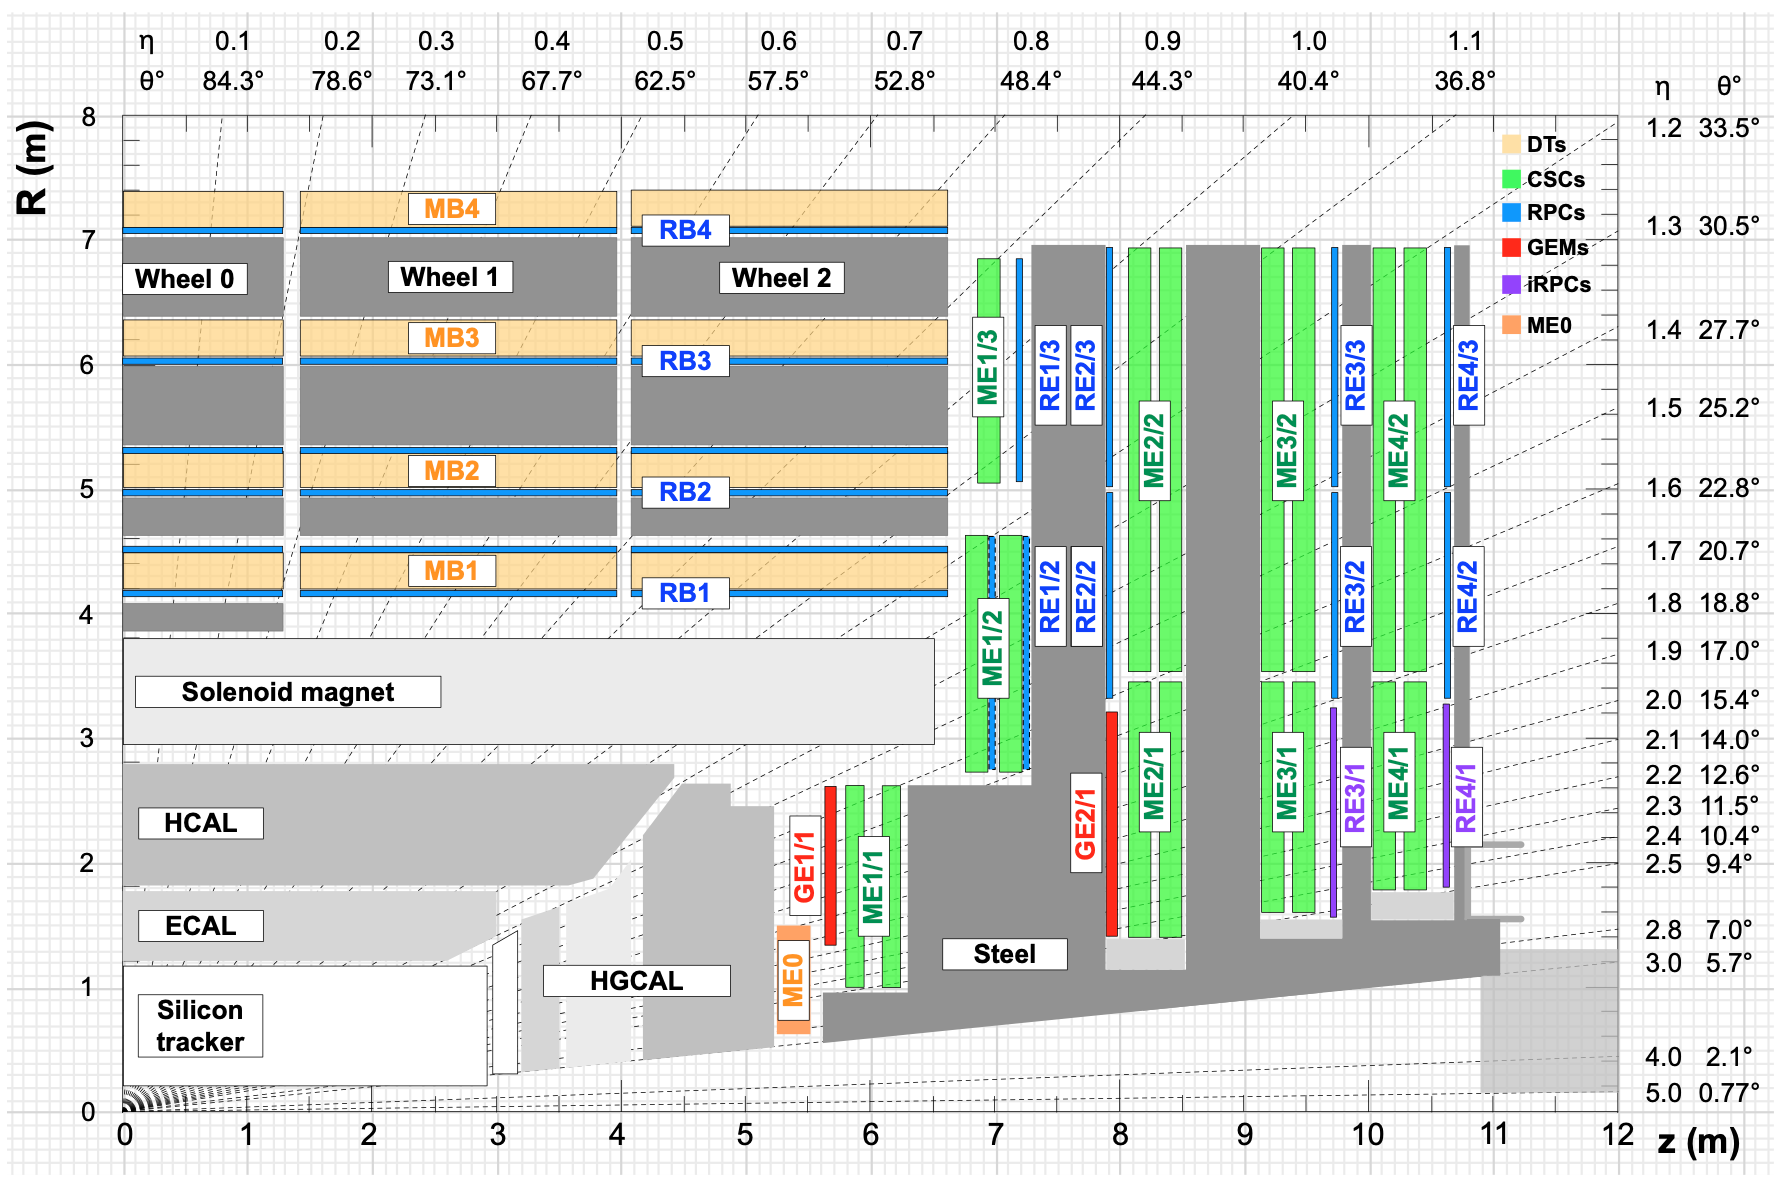

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from collections import namedtuple
import math
import h5py
import random 
import logging
from scipy.sparse import csr_matrix, find
import matplotlib.pyplot as plt
from google.colab import drive

# Mount google drive on remote Colab machine
drive.mount('/content/gdrive', force_remount=False)
sys.path.append('gdrive/My Drive/Colab Notebooks')

!ls 'gdrive/My Drive/Colab Notebooks/Data'
data_dir = 'gdrive/My Drive/Colab Notebooks/Data'

# Input and Output files and events to read
infile_mu   = data_dir+'/ntuple_SingleMuon_Endcap_9.root'
infile_pu = data_dir+'/ntuple_SingleNeutrino_PU200_63.root' 
outfile = data_dir+'/graphs/graphs.npz'
events_start=0
events_end=2000


# Install uproot
!pip install uproot
import uproot

#!pip install ipynb
#!pip install import_ipynb



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 _about.txt	     my_background.csv
 bolsas_astro.txt    my_signal.csv
 bolsas_fisica.txt   ntuple_bkg_ZZ4mu.root
 events.root	     ntuple_ggH_ZZ4mu.root
 GOOG.csv	     ntuple_qqH_ZZ4mu.root
 graphs		     ntuple_SingleMuon_Endcap_9.root
 graphs.zip	     ntuple_SingleNeutrino_PU200_63.root
 jet_images.h5	    'untitled folder'
 mlp_vbfhzz	     VBFHZZ_background.csv
 model_best.pt	     VBFHZZ_signal.csv


## Define Globals and Utility Functions

In [2]:
# Event dataframe


# Event VARS from Root tree and HITVARS
VARS = ['ve_event','vh_size','vh_type', 'vh_sector', 'vh_station', 'vh_ring','vh_chamber','vh_sim_r','vh_sim_phi','vh_sim_z', 'vh_sim_eta', 'vh_sim_theta','vh_bend','vh_sim_tp1','vh_sim_tp2']
HITVARS = ['vh_type','vh_sector', 'vh_station', 'vh_ring','vh_chamber','vh_sim_r','vh_sim_phi','vh_sim_z', 'vh_sim_eta', 'vh_sim_theta','vh_bend','vh_sim_tp1','vh_sim_tp2']

# Segments filter cuts
phi_slope_min = -0.2
phi_slope_max = 0.2
z0_max = 500.

# Graph is a namedtuple of (X, Ri, Ro, y) for convenience
#feature_names = ['vh_sim_r', 'vh_sim_phi', 'vh_sim_z']
#feature_scale = np.array([1000., 360. / 6., 1000.])
feature_names = ['vh_sim_r', 'vh_sim_phi', 'vh_sim_z', 'vh_bend']
feature_scale = np.array([1000., 360. / 6., 1000.,1000.])
#feature_names = ['vh_sim_r', 'vh_sim_phi', 'vh_sim_z','isMuon']
#feature_scale = np.array([1000., 360./6. , 1000.,1.])
#Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y_hits', 'y_segs'])

# Sparse graph uses the indices for the Ri, Ro matrices
#SparseGraph = namedtuple('SparseGraph',['X', 'Ri_rows', 'Ri_cols', 'Ro_rows', 'Ro_cols', 'y'])

'''
def graph_to_sparse(graph):
    Ri_rows, Ri_cols = graph.Ri.nonzero()
    Ro_rows, Ro_cols = graph.Ro.nonzero()
    return dict(X=graph.X, y=graph.y,
                Ri_rows=Ri_rows, Ri_cols=Ri_cols,
                Ro_rows=Ro_rows, Ro_cols=Ro_cols)

def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.uint8):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)
'''


# Muon hit type
#kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

# Muons ZONES in Eta ranges
etabins = [1.2, 1.7, 2.5]

# Number of Muon PHI sectors 
nsectors=6

# MUON Detector layers 
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

# List of Forward Muon detector layer IDs 
#csc_layers  = [ 2 , 3 , 7 , 8 , 10 ]
#csc_rpc_layers  = [ 2 , 3 , 4 , 5 , 7 , 8 , 9, 10, 11 ]
#adj_muon_layers_1.7_2.5 = [ [ME0,ME1/1], [GE1/1,ME1/1], [ME1/1,GE2/1], [GE2/1,ME2/1], [ME2/1,ME3/1], [ME3/1,RE3/1], [RE3/1,ME4/1], [ME4/1,RE4/1] ]
#adj_muon_layers_1.7_2.5 = [ [0,2]      , [1,2]        , [2,6]        , [6,7]        , [7,8]        , [8,9]        , [9,10]       , [10,11] ]

# EMTF hit layer number

emtf_lut = np.zeros((5,5,5), dtype=np.int32) - 99
emtf_lut[1,1,4] = 2  # ME1/1a
emtf_lut[1,1,1] = 2  # ME1/1b
emtf_lut[1,1,2] = 3  # ME1/2
emtf_lut[1,1,3] = 3  # ME1/3
emtf_lut[1,2,1] = 7  # ME2/1
emtf_lut[1,2,2] = 7  # ME2/2
emtf_lut[1,3,1] = 8  # ME3/1
emtf_lut[1,3,2] = 8  # ME3/2
emtf_lut[1,4,1] = 10  # ME4/1
emtf_lut[1,4,2] = 10  # ME4/2
emtf_lut[2,1,2] = 4  # RE1/2
emtf_lut[2,2,2] = 5  # RE2/2
emtf_lut[2,3,1] = 9  # RE3/1
emtf_lut[2,3,2] = 9  # RE3/2
emtf_lut[2,3,3] = 9  # RE3/3
emtf_lut[2,4,1] = 11  # RE4/1
emtf_lut[2,4,2] = 11  # RE4/2
emtf_lut[2,4,3] = 11  # RE4/3
emtf_lut[3,1,1] = 1  # GE1/1
emtf_lut[3,2,1] = 6 # GE2/1
emtf_lut[4,1,1] = 0 # ME0

muon_layers_dic= { 'ME1/1a':2 , 'ME1/1b':2 , 'ME1/2':3 , 'ME1/3':3 , 'RE1/2':4 , 'RE2/2':5 , 'ME2/1':7  , 'ME2/2':7  , 
                   'ME3/1':8 , 'ME3/2':8 , 'RE3/1':9 , 'RE3/2':9 , 'RE3/3':9 , 'ME4/1':10 , 'ME4/2':10 , 'RE4/1':11 , 'RE4/2':11 , 'RE4/3':11 }


# Get layer function
def get_layer(dtype, station, ring):
  layer = emtf_lut[dtype.astype(int),station.astype(int),ring.astype(int)] 
  return layer


# Delta phi function
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi



## Draw GRAPHS function

In [3]:
# Draw graphs function
def drawGraph(graph,labels): 
    # Select the i/o node features for each segment    
    # Prepare the figure
 
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
#    cmap = plt.get_cmap('bwr_r')

    # Get Graph info
    X = graph.X*feature_scale
    Ri = graph.Ri
    Ro = graph.Ro
    y = graph.y_segs

    # HITS features 
    R=X[:,0]
    Phi=(np.pi/180.)*X[:,1]
    Z=X[:,2] 
    XX=R*np.cos(Phi)
    YY=R*np.sin(Phi)


    # Color hits according to hits labels  ( Mu=1 or PU=0 )
    colordic={1:'blue' , 0:'red'}
    cl=[colordic.get(n) for n in labels ] # use the hit type just for coloring

    # Plot the hits
    ax0.scatter(XX,YY, s=100., color=cl )
    ax1.scatter(Z,R, s=100., color=cl )

    '''
    # Get the hits indices from the SEGMENTS arrays
    idx_i = find(np.rot90(Ri))[1]
    idx_o = find(np.rot90(Ro))[1]
  
    # Reverse to get correct hits order as in dh_hits 
    idx_i=idx_i[::-1]
    idx_o=idx_o[::-1]
   '''

  #  # Select the i/o node index for each segment
    idx_o = np.where(Ri.T)[1]
    idx_i = np.where(Ro.T)[1]

    # Get SEGMENTS begin and end hits coordinates
    R_i=X[idx_i,0]
    Phi_i=(np.pi/180.)*X[idx_i,1]
    Z_i=X[idx_i,2]
    X_i=R_i*np.cos(Phi_i)
    Y_i=R_i*np.sin(Phi_i)
  
    R_o=X[idx_o,0]
    Phi_o=(np.pi/180.)*X[idx_o,1]
    Z_o=X[idx_o,2]
    X_o=R_o*np.cos(Phi_o)
    Y_o=R_o*np.sin(Phi_o)
  
    # Create a list of SEGMENTS colors 
    cl=[colordic.get(n) for n in y]

    # Plot segments
    for j in range(y.shape[0]):
      ax0.plot([X_i[j], X_o[j]], [Y_i[j], Y_o[j]], '-', color=cl[j])
      ax1.plot([Z_i[j], Z_o[j]], [R_i[j], R_o[j]], '-', color=cl[j])


    # Show plots
    ax0.set_xlabel('X')
    ax0.set_ylabel('Y')
    ax1.set_xlabel('Z')
    ax1.set_ylabel('R')
    plt.show()

#      seg_args = dict(c=cmap(float(y[j])))
#      ax0.plot([X_i[j], X_o[j]], [Y_i[j], Y_o[j]], '-', **seg_args)
#      ax1.plot([Z_i[j], Z_o[j]], [R_i[j], R_o[j]], '-', **seg_args)


## Plot SEGMENTS

In [4]:
def plotSegments(segments):

  plt.figure(figsize=(14,6))

  all_segments = pd.concat(segments, ignore_index=True )

  true_segs = all_segments[( all_segments.isMuon_1 * all_segments.isMuon_2 ) == True]
  fake_segs = all_segments[( all_segments.isMuon_1 * all_segments.isMuon_2 ) == False]

  plt.subplot(121)
  binning=dict(bins=50, range=(-1.0, 1.0))
  plt.hist(fake_segs.phi_slope, label='fake', log=True, **binning)
  plt.hist(true_segs.phi_slope, label='true', **binning)
  plt.xlabel('$\Delta \phi / \Delta r$ [rad/mm]')
  plt.legend(loc=0)

  plt.subplot(122)
  binning=dict(bins=50, range=(-1000, 1000))
  plt.hist(fake_segs.z0, label='fake', log=True, **binning)
  plt.hist(true_segs.z0, label='true', **binning)
  plt.xlabel('$z_0$ [mm]')
  plt.legend(loc=0)

  plt.tight_layout()


# Read EVENTS function

In [5]:
# Function that reads all EVENTS from input file sand sture it in dataframes 
def readEvents():

  # Load the DATA and store selected the Root tree variables into Pandas dataframe
  upfile_mu = uproot.open(infile_mu)
  upfile_pu = uproot.open(infile_pu)
  tree_mu = upfile_mu["ntupler"]["tree"] # dictionary of NumPy arrays
  tree_pu = upfile_pu["ntupler"]["tree"] # dictionary of NumPy arrays

  #upfile_mu.keys()
  #tree_mu.show()


  # Read ROOT trees into dataframes
  df_events_mu = tree_mu.pandas.df(VARS,flatten=False, entrystart=int(events_start), entrystop=int(events_end))
  df_events_pu = tree_pu.pandas.df(VARS,flatten=False, entrystart=int(events_start), entrystop=int(events_end))
  
  # Return events dataframes
  return df_events_mu , df_events_pu

## Get HITS Function

In [6]:
# Function that builds a HITS dataframe per event containing all real muon hits and merge it with pileup hits
def getHits(event_mu,event_pu):

 # print("event_mu = ", event_mu.head())

  # Create a HITS dataframe for a given muon event 
  hits_mu = event_mu[HITVARS]        # create a DF containing only muon hits variables
  hits_mu_list = hits_mu.values.tolist()  # evaluate jagged arrays and transform to list or arrays DF ( trick for DF of jagged arrays )
  df_hits_mu = pd.DataFrame(hits_mu_list, index=hits_mu.index) # create a dataframe from a list of arrays
  df_hits_mu = df_hits_mu.transpose() # transpose dataframe to have hit variables as columns 

  # Get only true muon hits (use generator-level matching condition)!
  df_hits_mu = df_hits_mu[(df_hits_mu['vh_sim_tp1']==0) & (df_hits_mu['vh_sim_tp2']==0)]   

  # Create a HITS only dataframe for a given pileup event 
  hits_pu = event_pu[HITVARS]         # create a DF containing only pileup hits variables
  hits_pu_list = hits_pu.values.tolist()   # evaluate jagged arrays and transform to list or arrays DF ( trick for DF of jagged arrays )
  df_hits_pu = pd.DataFrame(hits_pu_list, index=hits_pu.index)   # create a dataframe from a list of arrays
  df_hits_pu = df_hits_pu.transpose() # transpose dataframe to have hit variables as columns

  # Add "isMuon" variable to dataframes
  df_hits_mu['isMuon'] = np.ones(len(df_hits_mu))
  df_hits_pu['isMuon'] = np.zeros(len(df_hits_pu))
  
  # Concatenate MUON and PU hits dataframes into a single hits dataframe
  df_hits = pd.concat([df_hits_mu, df_hits_pu],ignore_index=True) # merge muon and pileup hits
#  df_hits = df_hits_mu # only muon hits
 
  # Add hit layer info to dataframe
  df_hits['vh_layer'] = df_hits.apply(lambda row: get_layer(row['vh_type'], row['vh_station'], row['vh_ring']), axis=1)
 
  # Filter out hits without layer information
  #df_events_mu = df_events_mu[(df_events_mu["vh_layer"]>=0)]
  #df_events_pu = df_events_pu[(df_events_pu["vh_layer"]>=0)]

 # print("len(df_hits)=",len(df_hits))
 # print("df_hits head = ", df_hits.head(3) ) 

  # Add the muon event number to the hits dataframe ( hits history )
  evtid = event_mu['ve_event'][0]        # muon event number
  df_hits["evtid"]=evtid
 
  # Return the HITS dataframe 
  return df_hits
  

## Split HITS Function

In [7]:
# Split hits by detector sides (Z sign) , ETA range and PHI sector 
def splitHits(df_hits):
     
  # List of of hits dataframes per side , zone and sector 
  hits_sectors = []

#  print('ETABINS=',zip(etabins,etabins[1:]) )

  # Loop over detector sides (Z>0 and Z<0) 
  for zsign in [-1,1]:

    # Loop over ETA bins zones
    for eta_min, eta_max in zip(etabins,etabins[1:]):

      # Filter hits belonging to a given eta bin and hemisphere ( Z sign )
      df_hits_eta = df_hits[(df_hits["vh_sim_eta"]*zsign > eta_min)].copy()
      df_hits_eta = df_hits_eta[(df_hits_eta["vh_sim_eta"]*zsign < eta_max)]
  
      # Loop over PHI sectors
      for i in range(1,nsectors+1):

        # Filter only hits in a given sector
        df_hits_sec = df_hits_eta[(df_hits_eta['vh_sector']==i)].copy()

        # Reset dataframe hits index in each sector 
        df_hits_sec.reset_index(inplace=True, drop=True) 
     
        # Append to list non empty hits dataframes
        if ( len(df_hits_sec)>0 ) : hits_sectors.append(df_hits_sec)

  # Return list of dataframes hits in each detector sector
  return hits_sectors



# Build SEGMENTS Function

In [8]:

# Function that builds SEGMENTS ( hit pairs ) using Hits dataframes. SEGMENTS are defined as consecutive hit pairs ordered LAYER numbers
def buildSegments(df_hits):

  # Order df_hits by layer and reindex
  df_hits.sort_values(by=['vh_layer'], inplace=True)
  df_hits.reset_index(inplace=True, drop=True)

  print("df_hits = ")
  print(df_hits[['vh_layer', 'vh_type', 'vh_sector', 'vh_station','vh_sim_r','vh_sim_z','vh_bend','isMuon']])
  
  segments= [] # list of segments
  
  # Define detector layer sequence ( increasing |Z| )
#  muon_layers_dic= { 'ME1/1a':2 , 'ME1/1b':2 , 'ME1/2':3 , 'ME1/3':3 , 'RE1/2':4 , 'RE2/2':5 , 'GE2/1':6 , \
#                     'ME2/1':7  , 'ME2/2':7  , 'ME3/1'=8 , 'ME3/2':8 , 'RE3/1':9 , 'RE3/2':9 , 'RE3/3':9 , 'ME4/1':10 , 'ME4/2':10 , \
#                     'RE4/1':11 , 'RE4/2':11 , 'RE4/3':11 }
#  layers = [3,4,5,7,8,9,10,11] # use only layers in ETA range [1.2 , 1.7] 
  layers = [0,1,2,6,7,8,9,10,11] # use only layers in ETA range [1.7 , 2.5] 

  # Group hits dataframe by layer 
  hits_groups = df_hits.groupby("vh_layer")
   
  # Loop over layer pairs do build segments
  for l1 in layers:

    try:

      # Get hits belonging layer l1   
      df_hits1 = hits_groups.get_group(l1)

    except:  
      
      # Continue in case layer l1 is empty
      continue  

    # Get index of l1 in layers list
    idx = layers.index(l1)    

    # Loop over layer l2       
    for l2 in layers[idx+1:]:  

      if (l1==0 and l2==1): continue # skip combinations between ME0 and GE1/1
#      if (l1==0 and l2==3): continue # skip combinations between ME0 and ME1/2, ME1/3
#      if (l1==1 and l2==3): continue # skip combinations between GE1/1 and ME1/2, ME1/3
#      if (l1==2 and l2==3): continue # skip combinations between ME1/1 and ME1/2, ME1/3
 
      try:
        
        # Get hits in layer l2
        df_hits2 = hits_groups.get_group(l2)
        # print('created layer pairs (l1,l2)=',l1,' , ',l2)
        idx = layers.index(l2) # find idx for the begining of the next segment
        l1 = layers[idx-1]     # sets back one item for next value of l1 to be l2

        # Reset index of the hits dataframes to have the 'old index' added as a dataframe column before merging
        df_hits1.reset_index(inplace=True)
        df_hits2.reset_index(inplace=True)

        # Merge df_hits1 and df_hits2 in a single dataframe, adding the suffixes _1 and _2 to old labels
        #df_hit_pairs = pd.merge( df_hits1.reset_index(), df_hits2.reset_index(), how='inner', on='evtid', suffixes=('_1', '_2'))
        df_hit_pairs = pd.merge( df_hits1.reset_index(), df_hits2.reset_index(), how='outer', on='evtid', suffixes=('_1', '_2'))

        # Filter out hit pairs between  M1/1 and M1/2 , M1/3 
        # Filter out hit pairs between  ME1/1 and ME2/2 , ME3/2 , RE3/2 , RE3/3 , ME4/2 , RE4/2 , RE4/3
        # Filter out hit pairs between  ME2/1 and ME3/2 , RE3/2 , RE3/3 , ME4/2 , RE4/2 , RE4/3
        # Filter out hit pairs between  ME3/1 and RE3/2 , RE3/3 , ME4/2 , RE4/2 , RE4/3
        # Filter out hit pairs between  ME4/1 and RE4/2 , RE4/3
#        sel_mask1 = ( (df_hit_pairs.vh_station_1 == 1 and df_hit_pairs.vh_station_2 ==2 ) or 
#                     (df_hit_pairs.vh_station_1 == 1 and df_hit_pairs.vh_station_2 ==3 ) or

        # Compute segment features
        dphi = calc_dphi(df_hit_pairs.vh_sim_phi_1, df_hit_pairs.vh_sim_phi_2)
        dz = df_hit_pairs.vh_sim_z_2 - df_hit_pairs.vh_sim_z_1
        dr = df_hit_pairs.vh_sim_r_2 - df_hit_pairs.vh_sim_r_1
        phi_slope = dphi / dr
        z0 = df_hit_pairs.vh_sim_z_1 - df_hit_pairs.vh_sim_r_1 * dz / dr
     
        # Discard most of the individual hits variables and add segments( hit pairs ) variables 
        df_hit_pairs = df_hit_pairs[['evtid', 'index_1', 'index_2', 'vh_layer_1', 'vh_layer_2', 'vh_station_1', 'vh_station_2','isMuon_1','isMuon_2']].assign(dphi=dphi, dz=dz, dr=dr, phi_slope=phi_slope, z0=z0)

        # Filter segments according to criteria
        sel_mask = ((df_hit_pairs.phi_slope.abs() > phi_slope_min) &
                    (df_hit_pairs.phi_slope.abs() < phi_slope_max) &
                    (df_hit_pairs.z0.abs() < z0_max))
#        df_hit_pairs=df_hit_pairs[sel_mask]
 
        # Create a hit pairs dataframe in segments list
        segments.append(df_hit_pairs)
 
        # End inner loop over leayer l2 
        break

      except:  

        # If no hits found on current l2 layer continue to next l2 layer
        continue               

  # Create an event dataframe of segments by concatenating list of segments per sector/zone 
  df_segments = pd.DataFrame()
  if ( len(segments) > 0 ):  df_segments = pd.concat(segments, ignore_index=True)

  # Return modified df_hits and df_segments dataframes
  return df_segments


## Build GRAPHS function

In [9]:
def buildGraph(df_hits,df_segments):

  # Get number of hits and segments in event
  n_hits = df_hits.shape[0]
  n_edges = df_segments.shape[0]

  # Prepare the GRAPH tensors( matrices )
  Ri = np.zeros((n_hits, n_edges), dtype=np.uint8)  # Adjacency matrix
  Ro = np.zeros((n_hits, n_edges), dtype=np.uint8)  # Adjacency matrix
  X = (df_hits[feature_names].values / feature_scale).astype(np.float32)  # features
  y_segs = np.zeros(n_edges, dtype=np.float32)           # labels for SEGMENTS classification
  y_hits = np.zeros(n_hits, dtype=np.float32)           # labels for HITS classification
  
  # We have the segments and need to get hits positional indices in the df_hits dataframe
  # Use a series (hit_idx) to map df_hits indices onto df_segments hits indices.
  hit_idx = pd.Series(np.arange(n_hits), index=df_hits.index)
  start_idx = hit_idx.loc[df_segments.index_1].values
  end_idx = hit_idx.loc[df_segments.index_2].values

  # Now we can fill the association matrices.
  # Note that Ri maps hits onto their incoming edges,
  # which are actually segment endings.
  Ri[start_idx, np.arange(n_edges)] = 1
  Ro[end_idx, np.arange(n_edges)] = 1
  
 # For HITS classification fill the hits labels
 # pid1 = df_hits.isMuon.loc[df_segments.index_1].values
 # y[:] = [i for i in pid1]
  y_hits[:] =  df_hits.isMuon.values

  # For SEGMENT classification fill the segment labels ( for muon segments label1=label2=1 )
  label1 = df_hits.isMuon.loc[df_segments.index_1].values
  label2 = df_hits.isMuon.loc[df_segments.index_2].values
  y_segs[:] = [(i and j) for i, j in zip(label1, label2)]
  
  # Return a GRAPH (named tuple) and hits labels
  return Graph(X, Ri, Ro, y_hits,y_segs)


## MAIN program


Initializing random seed=1
Event= 0    Sector= 1
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         4      2.0        1.0  ...  -725.950012    -99.0     0.0
1         6      3.0        1.0  ...  -793.598755      1.0     0.0
2         7      1.0        1.0  ...  -814.835388      1.0     0.0
3        11      2.0        1.0  ... -1065.694946    -99.0     0.0

[4 rows x 8 columns]
Event= 0    Sector= 1


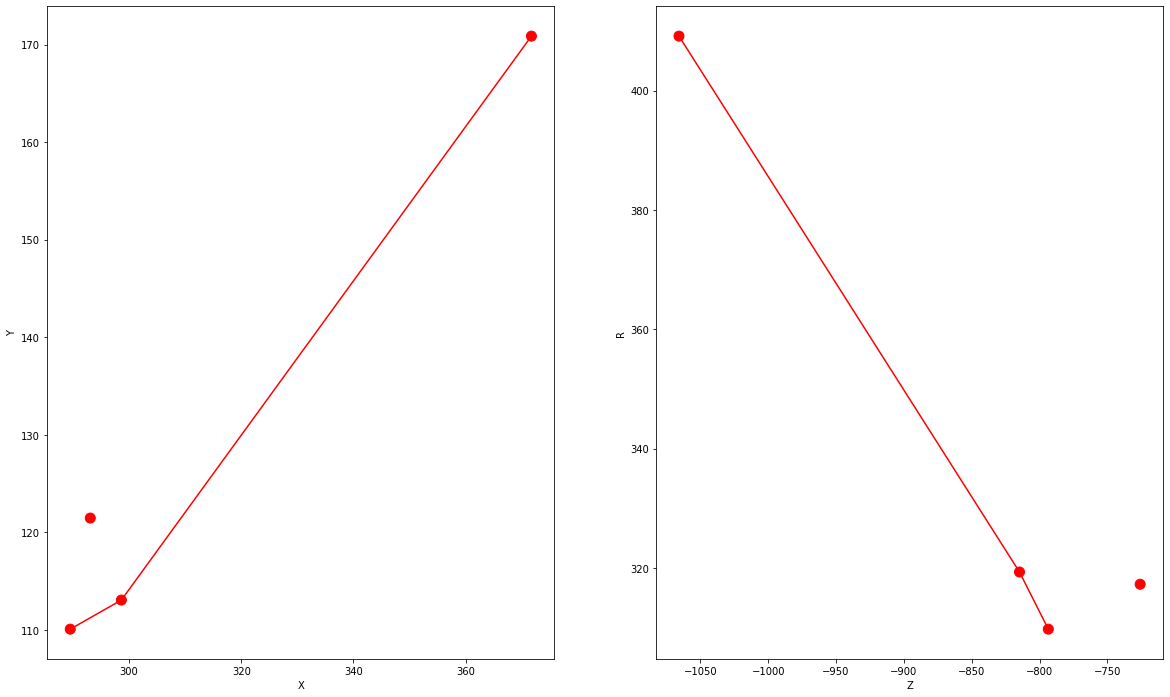

Event= 0    Sector= 2
df_hits = 
   vh_layer  vh_type  vh_sector  ...   vh_sim_z  vh_bend  isMuon
0         4      2.0        3.0  ... -694.93457    -99.0     0.0

[1 rows x 8 columns]
Event= 0    Sector= 3
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ...  -615.699829     10.0     0.0
1         9      2.0        1.0  ...  -975.200012    -99.0     0.0
2        10      1.0        1.0  ... -1013.629150    -16.0     0.0

[3 rows x 8 columns]
Event= 0    Sector= 3


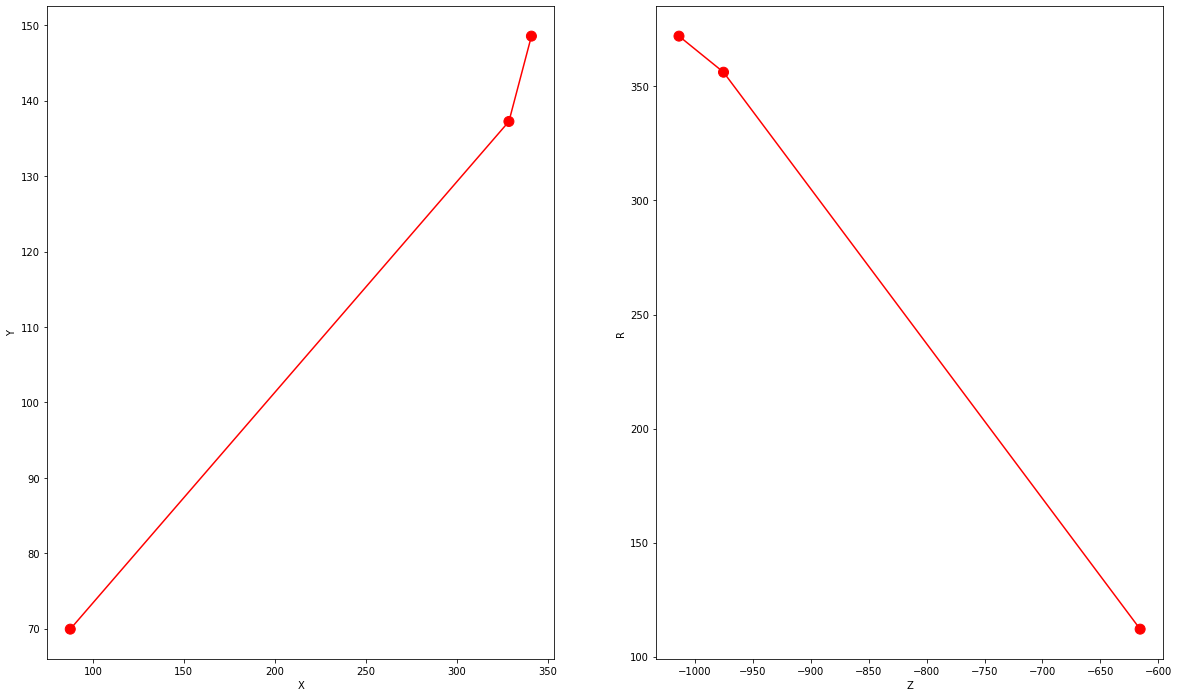

Event= 0    Sector= 4
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ... -615.649902     16.0     0.0

[1 rows x 8 columns]
Event= 0    Sector= 5
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ... -615.629578     10.0     0.0

[1 rows x 8 columns]
Event= 0    Sector= 6
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         3      1.0        3.0  ...  683.865723     23.0     0.0
1         3      1.0        3.0  ...  711.366394     21.0     0.0

[2 rows x 8 columns]
Event= 0    Sector= 7
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ...   615.786438    -32.0     0.0
1         7      1.0        1.0  ...   814.923889    -14.0     0.0
2         9      2.0        1.0  ...   968.900024    -99.0     0.0
3        10      1.0        1.0  ...  1038.710571     -6.0     0.0
4    

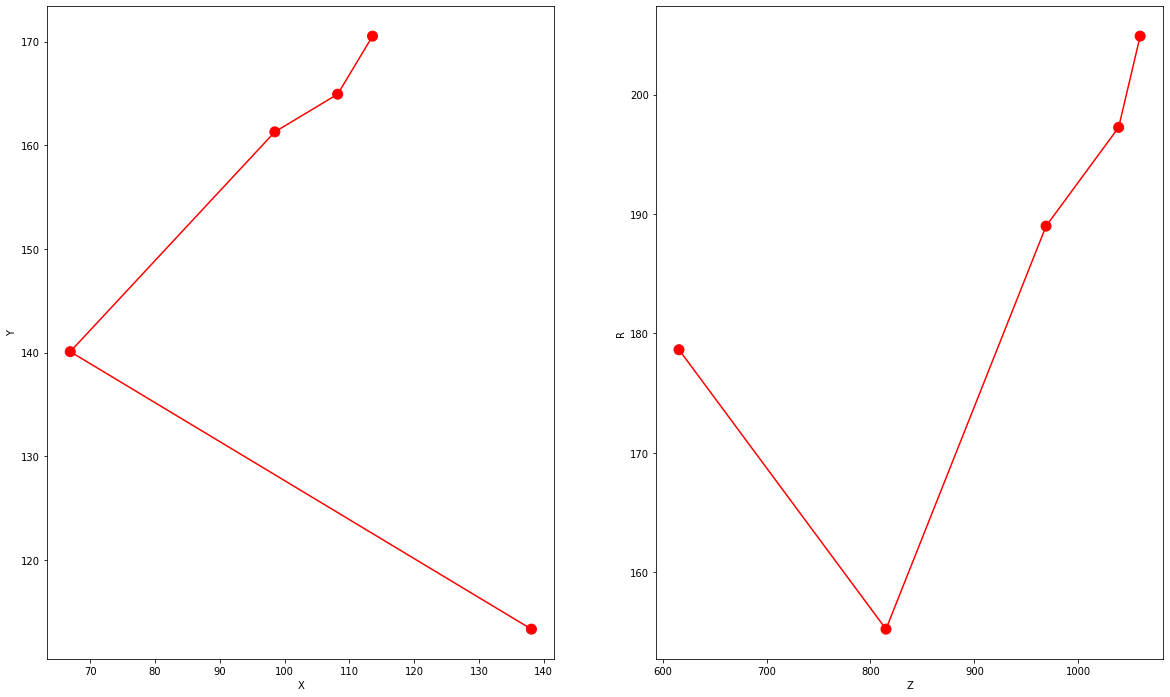

Event= 0    Sector= 8
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         7      1.0        2.0  ...   814.923889    -14.0     0.0
1         9      2.0        2.0  ...   968.900024    -99.0     0.0
2        10      1.0        2.0  ...  1038.710571     -6.0     0.0
3        11      2.0        2.0  ...  1059.395020    -99.0     0.0
4        11      2.0        2.0  ...  1054.994995    -99.0     0.0

[5 rows x 8 columns]
Event= 0    Sector= 8


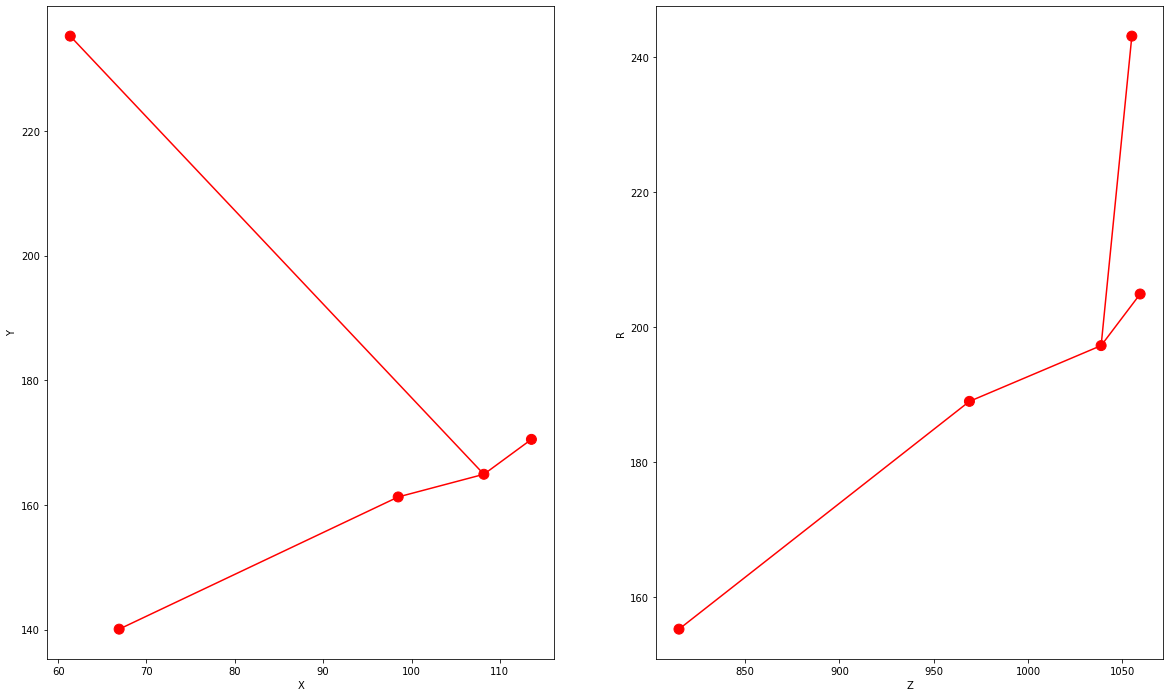

Event= 0    Sector= 9
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ...  615.711121     29.0     0.0

[1 rows x 8 columns]
Event= 0    Sector= 10
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         0      4.0        5.0  ...  539.349976     -8.0     0.0

[1 rows x 8 columns]
Event= 0    Sector= 11
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         0      4.0        6.0  ...   539.349976    -23.0     1.0
1         2      1.0        6.0  ...   615.741394    -16.0     0.0
2         6      3.0        6.0  ...   796.001221      2.0     1.0
3         7      1.0        6.0  ...   839.848145     -4.0     1.0
4         7      1.0        6.0  ...   839.808411    -10.0     0.0
5         8      1.0        6.0  ...   923.918091      2.0     0.0
6         9      2.0        6.0  ...   964.500000    -99.0     0.0
7        11      2.0        6.0  ...  1054.994995    -9

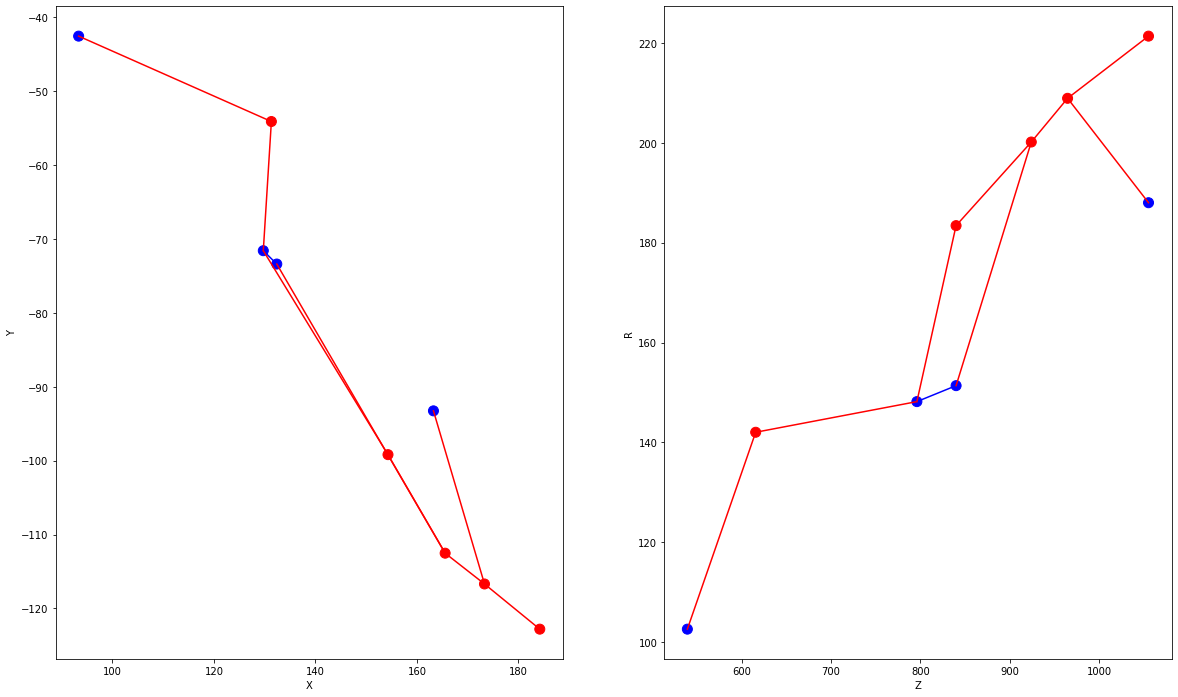

Event= 1    Sector= 1
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         3      1.0        3.0  ... -711.642334    -25.0     0.0
1         5      2.0        3.0  ... -793.200012    -99.0     0.0
2         9      2.0        3.0  ... -975.200012    -99.0     0.0

[3 rows x 8 columns]
Event= 1    Sector= 2
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         4      2.0        5.0  ... -725.950012    -99.0     0.0

[1 rows x 8 columns]
Event= 1    Sector= 3
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ... -615.688477     18.0     0.0
1         2      1.0        1.0  ... -615.724854      5.0     0.0

[2 rows x 8 columns]
Event= 1    Sector= 4
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        3.0  ... -615.745605    -19.0     0.0

[1 rows x 8 columns]
Event= 1    Sector= 5
df_hits = 
   vh_layer  vh_type 

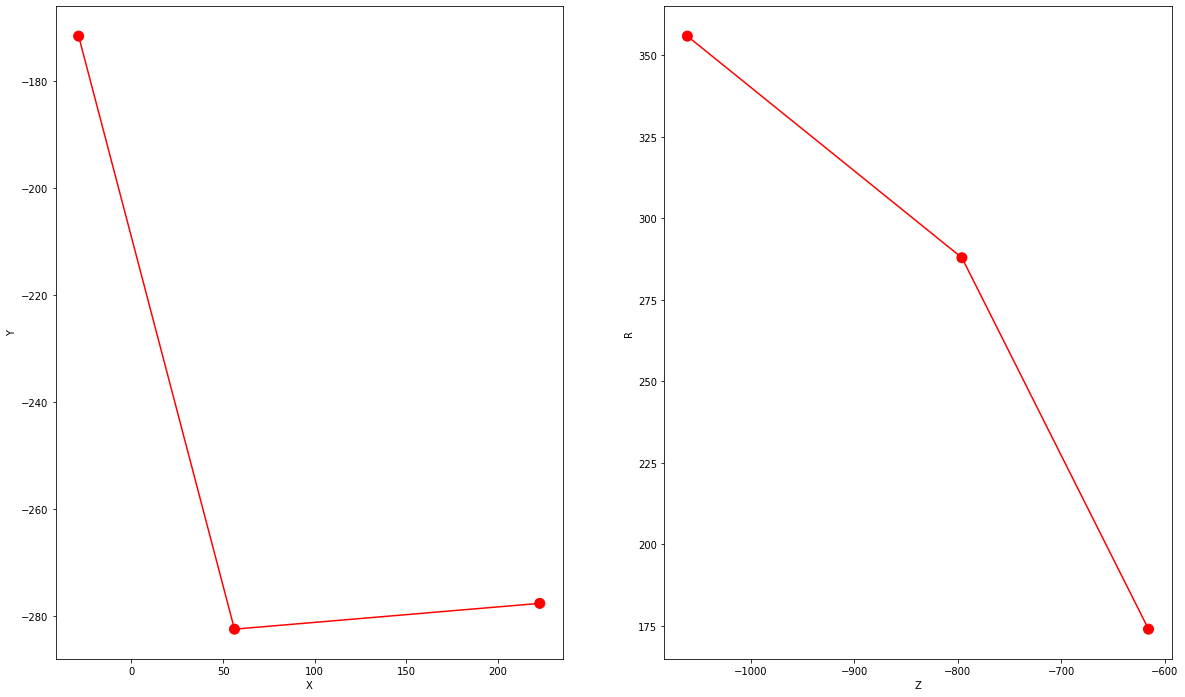

Event= 1    Sector= 7
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         4      2.0        6.0  ...  725.950012    -99.0     0.0
1         5      2.0        6.0  ...  793.200012    -99.0     0.0
2         7      1.0        6.0  ...  839.673645     13.0     0.0
3         8      1.0        6.0  ...  924.224609     31.0     0.0
4         9      2.0        6.0  ...  975.200012    -99.0     0.0

[5 rows x 8 columns]
Event= 1    Sector= 7


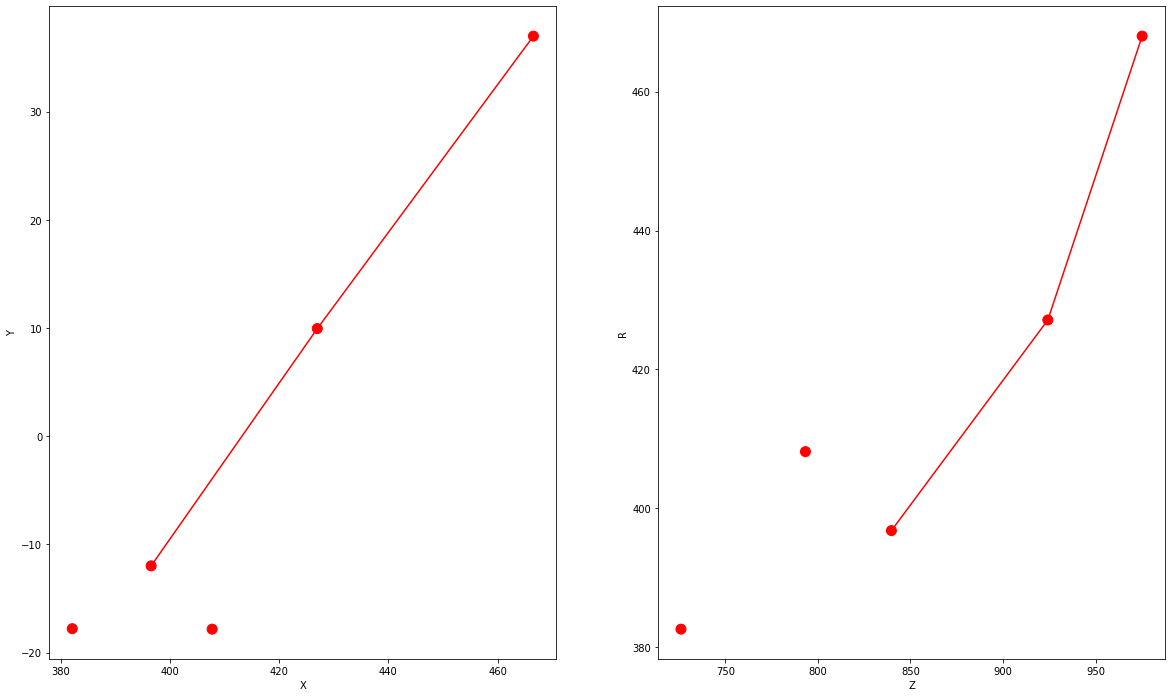

Event= 1    Sector= 8
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         1      3.0        1.0  ...   567.971252     -2.0     1.0
1         2      1.0        1.0  ...   615.760864     -9.0     1.0
2         6      3.0        1.0  ...   793.598755     -1.0     1.0
3         8      1.0        1.0  ...   948.810364     -1.0     1.0
4         9      2.0        1.0  ...   975.200012    -99.0     1.0
5        11      2.0        1.0  ...  1065.694946    -99.0     1.0

[6 rows x 8 columns]
Event= 1    Sector= 8


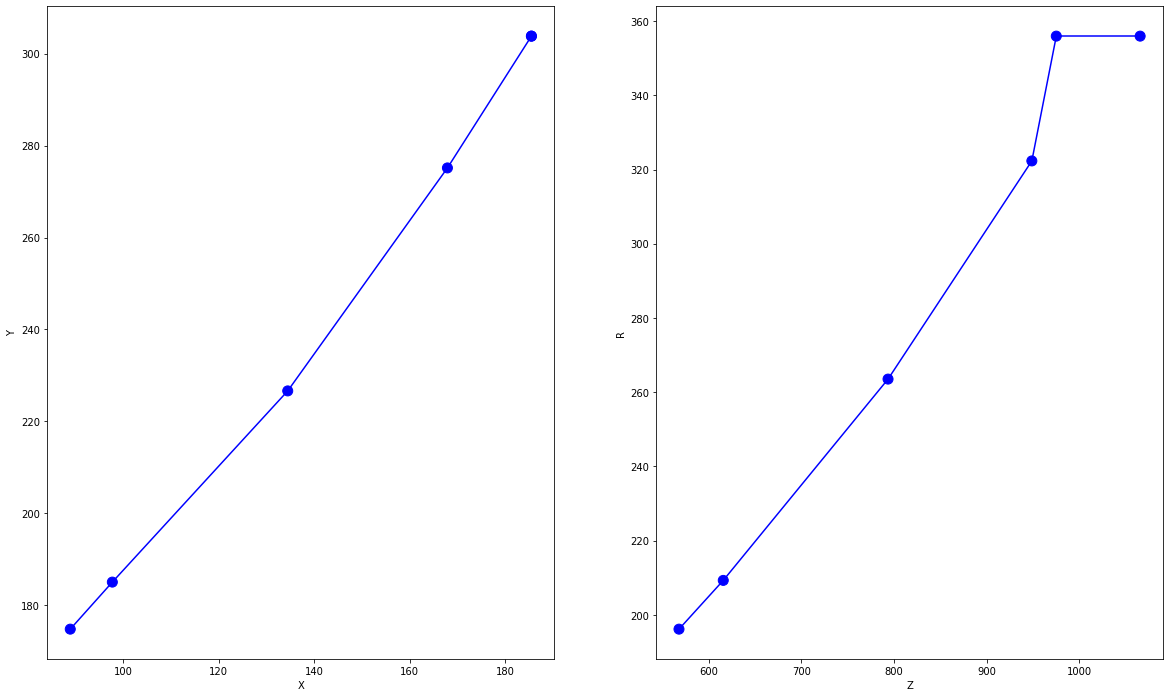

Event= 1    Sector= 9
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        2.0  ...   615.795105    -14.0     0.0
1         2      1.0        2.0  ...   586.477051    -17.0     0.0
2         6      3.0        2.0  ...   793.598755     -1.0     1.0
3         7      1.0        2.0  ...   839.903320      0.0     0.0
4         8      1.0        2.0  ...   948.810364     -1.0     1.0
5         8      1.0        2.0  ...   924.046814      4.0     0.0
6         9      2.0        2.0  ...   964.500000    -99.0     0.0
7        11      2.0        2.0  ...  1054.994995    -99.0     0.0

[8 rows x 8 columns]
Event= 1    Sector= 9


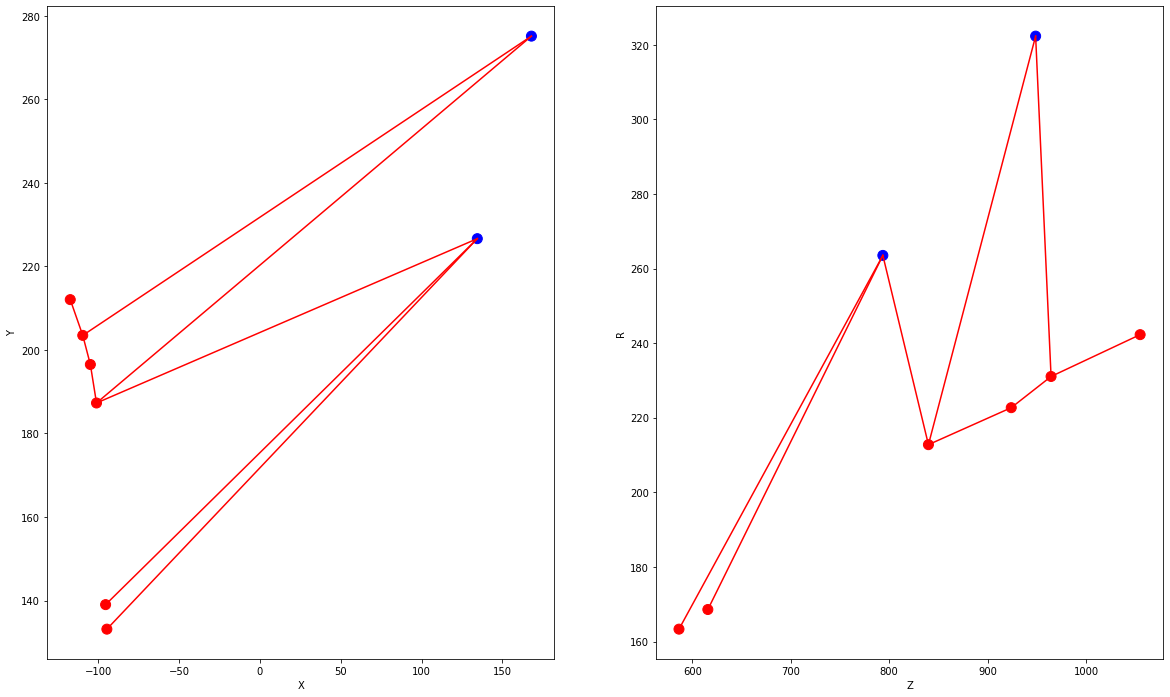

Event= 1    Sector= 10
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        3.0  ...   586.477051    -17.0     0.0
1         7      1.0        3.0  ...   839.903320      0.0     0.0
2         8      1.0        3.0  ...   924.046814      4.0     0.0
3         9      2.0        3.0  ...   964.500000    -99.0     0.0
4        11      2.0        3.0  ...  1054.994995    -99.0     0.0

[5 rows x 8 columns]
Event= 1    Sector= 10


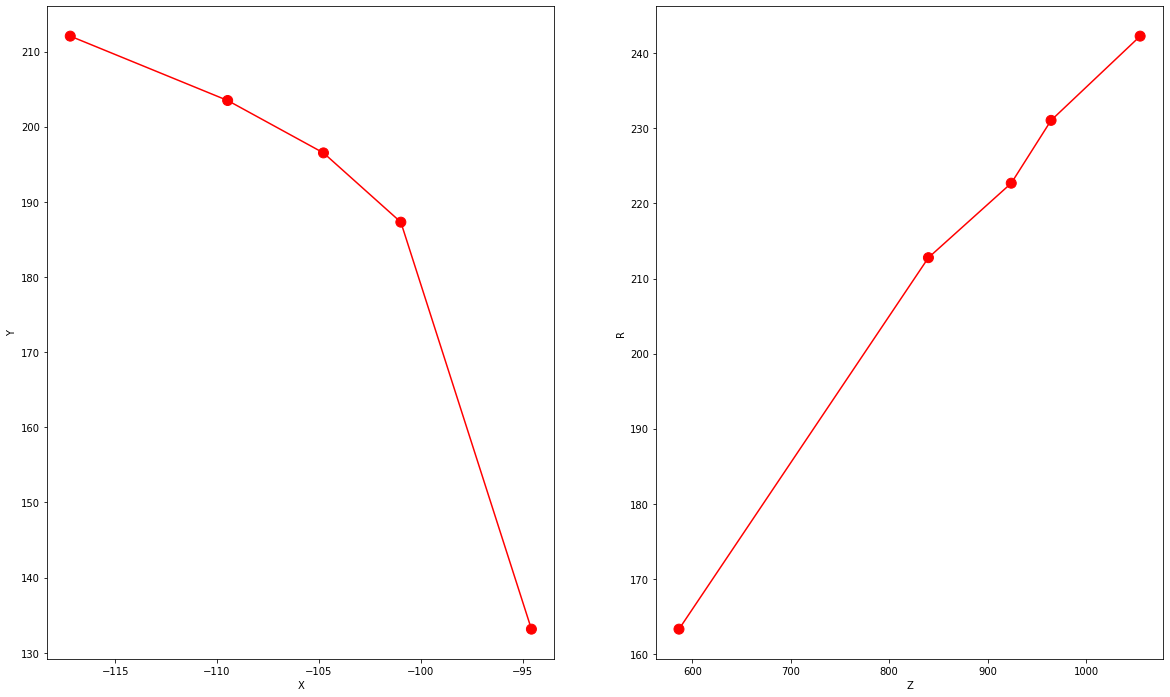

Event= 1    Sector= 11
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        5.0  ...  615.772339     -8.0     0.0

[1 rows x 8 columns]
Event= 1    Sector= 12
df_hits = 
   vh_layer  vh_type  vh_sector  ...  vh_sim_z  vh_bend  isMuon
0         9      2.0        6.0  ...     964.5    -99.0     0.0

[1 rows x 8 columns]
Event= 2    Sector= 1
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         4      2.0        2.0  ... -725.950012    -99.0     0.0

[1 rows x 8 columns]
Event= 2    Sector= 2
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         9      2.0        5.0  ... -970.799988    -99.0     0.0

[1 rows x 8 columns]
Event= 2    Sector= 3
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ... -615.711304     22.0     0.0

[1 rows x 8 columns]
Event= 2    Sector= 4
df_hits = 
   vh_layer  vh_type  vh_sector  .

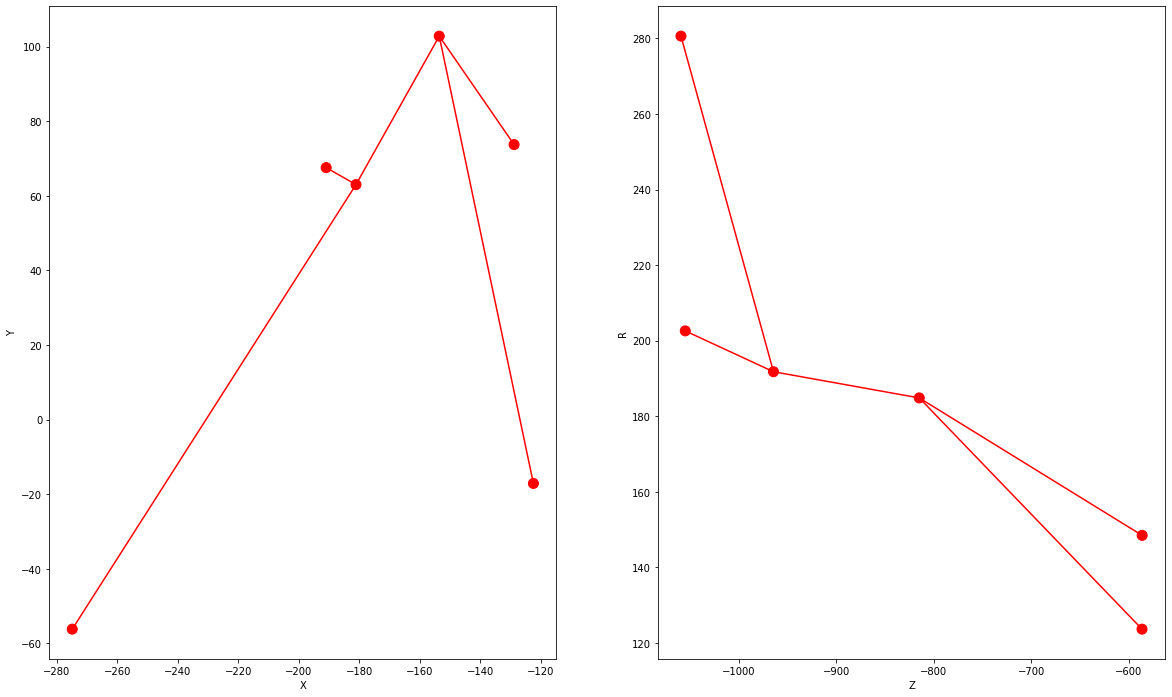

Event= 2    Sector= 6
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ...  -586.449646     27.0     0.0
1        11      2.0        4.0  ... -1059.395020    -99.0     0.0

[2 rows x 8 columns]
Event= 2    Sector= 6


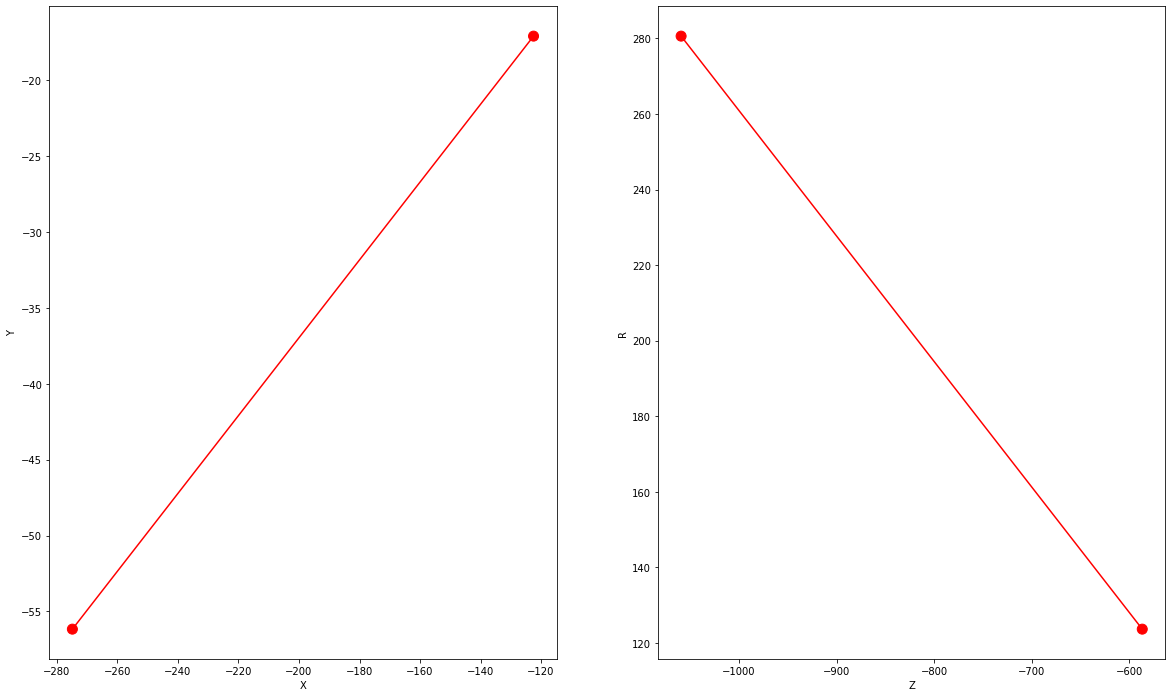

Event= 2    Sector= 7
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        5.0  ... -615.647522    -29.0     0.0
1         2      1.0        5.0  ... -615.749146      9.0     0.0
2         2      1.0        5.0  ... -615.757812     23.0     0.0
3         6      3.0        5.0  ... -796.001221      0.0     0.0

[4 rows x 8 columns]
Event= 2    Sector= 7


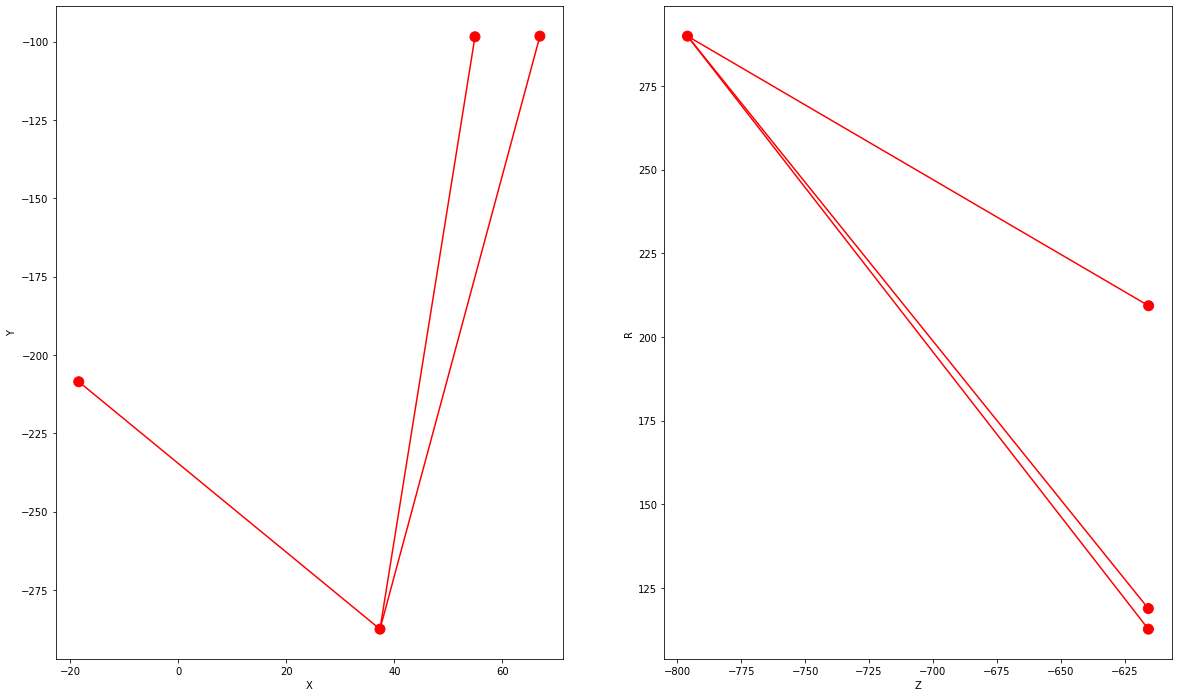

Event= 2    Sector= 8
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ... -586.374451    -22.0     0.0
1         2      1.0        6.0  ... -615.687622     16.0     0.0

[2 rows x 8 columns]
Event= 2    Sector= 9
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         1      3.0        3.0  ...   565.368774      0.0     1.0
1         2      1.0        3.0  ...   586.325073      4.0     1.0
2         6      3.0        3.0  ...   793.598755      0.0     1.0
3         7      1.0        3.0  ...   815.135132      2.0     1.0
4        11      2.0        3.0  ...  1061.295044    -99.0     1.0

[5 rows x 8 columns]
Event= 2    Sector= 9


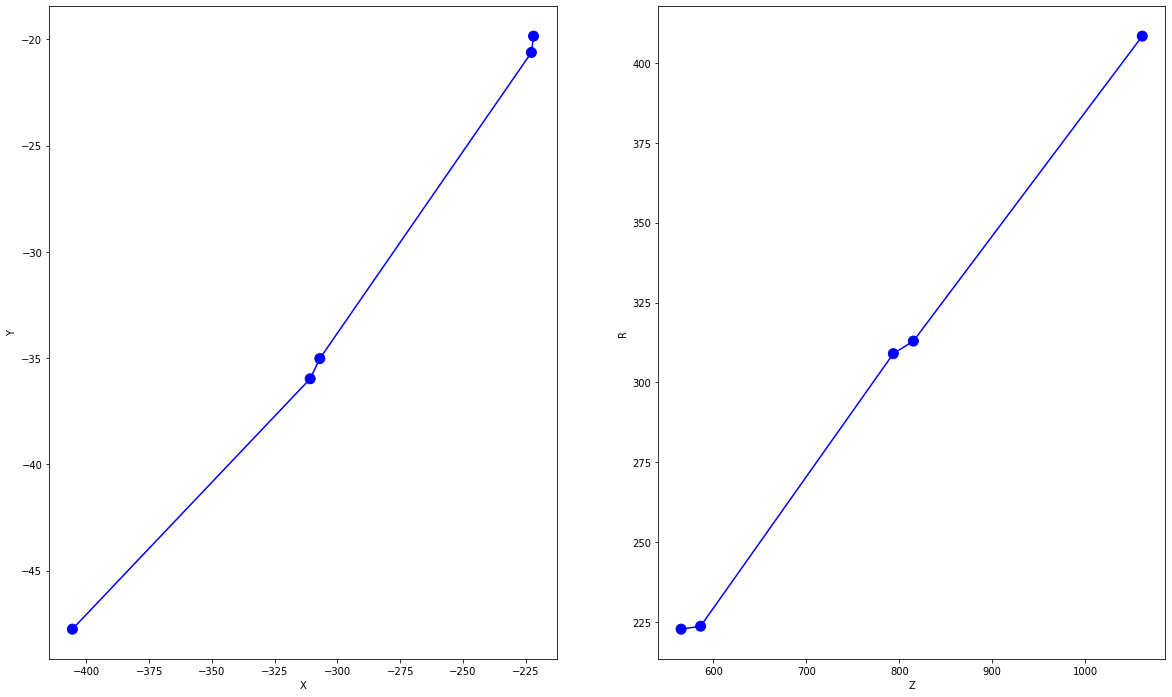

Event= 2    Sector= 10
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         1      3.0        4.0  ...   565.368774      0.0     1.0
1         2      1.0        4.0  ...   586.325073      4.0     1.0
2         6      3.0        4.0  ...   793.598755      0.0     1.0
3         7      1.0        4.0  ...   815.135132      2.0     1.0
4        11      2.0        4.0  ...  1061.295044    -99.0     1.0

[5 rows x 8 columns]
Event= 2    Sector= 10


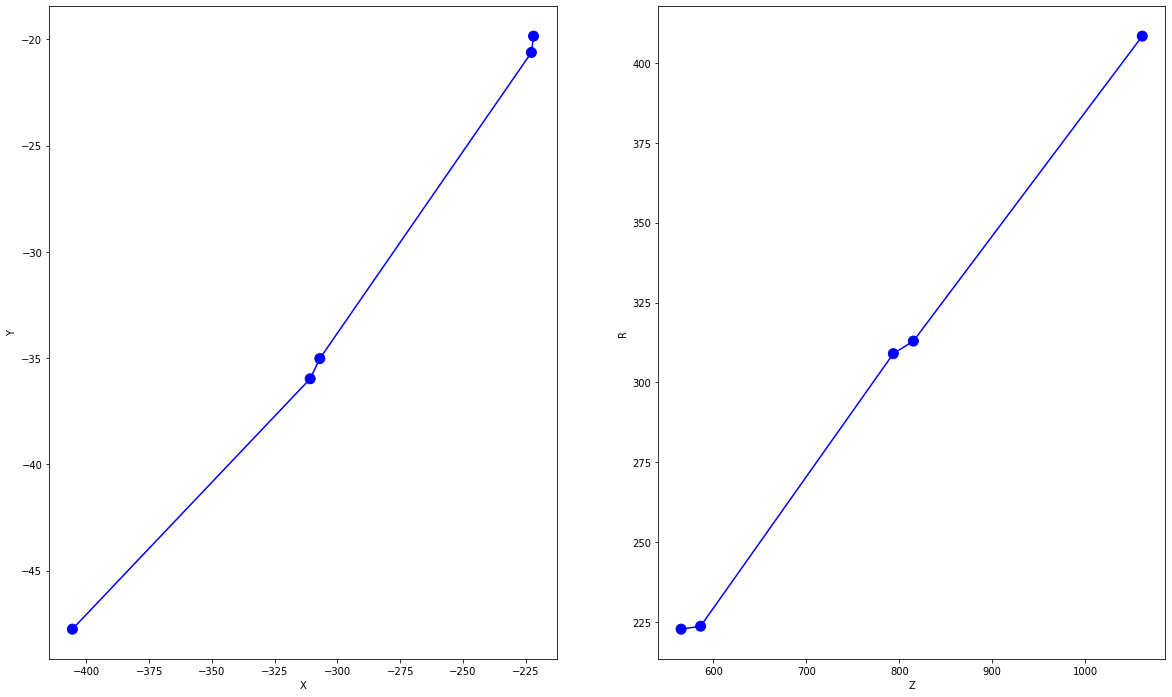

Event= 2    Sector= 11
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         3      1.0        6.0  ...  683.805298      2.0     0.0

[1 rows x 8 columns]
Event= 2    Sector= 12
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ...  586.387512      4.0     0.0

[1 rows x 8 columns]
Event= 2    Sector= 13
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        2.0  ...  586.400085      5.0     0.0

[1 rows x 8 columns]
Event= 2    Sector= 14
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        3.0  ...   586.332214      4.0     1.0
1         9      2.0        3.0  ...   970.799988    -99.0     1.0
2        10      1.0        3.0  ...  1038.379761     -7.0     1.0

[3 rows x 8 columns]
Event= 2    Sector= 14


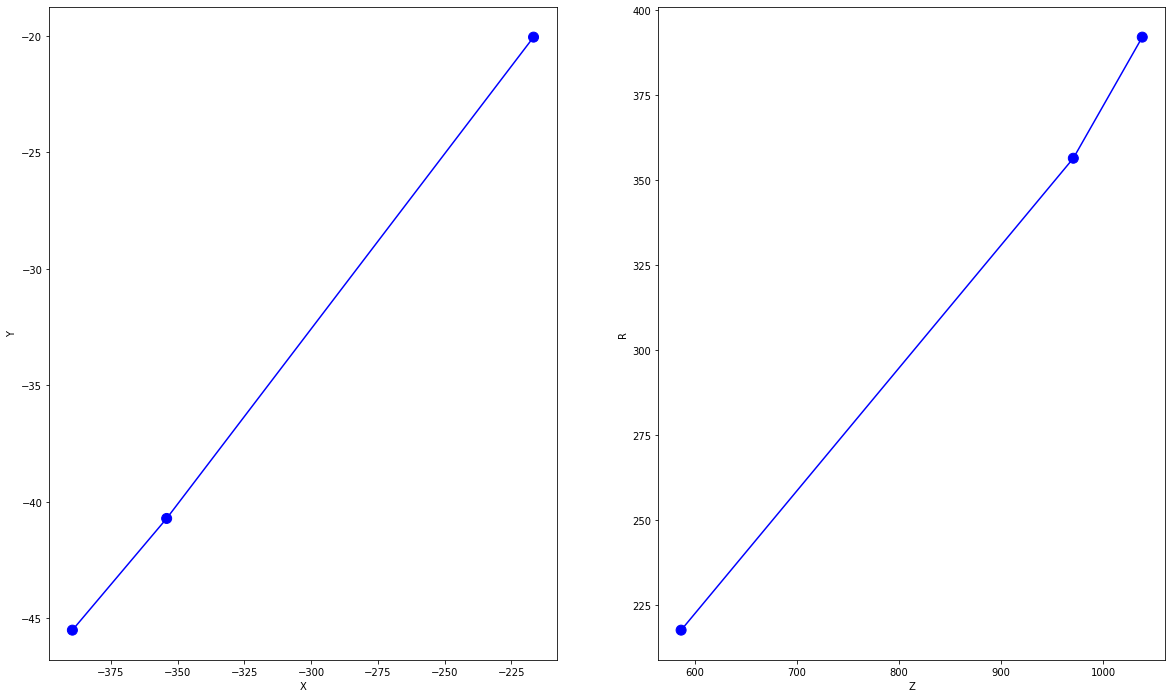

Event= 2    Sector= 15
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ...   586.332214      4.0     1.0
1         9      2.0        4.0  ...   970.799988    -99.0     1.0
2        10      1.0        4.0  ...  1038.379761     -7.0     1.0

[3 rows x 8 columns]
Event= 2    Sector= 15


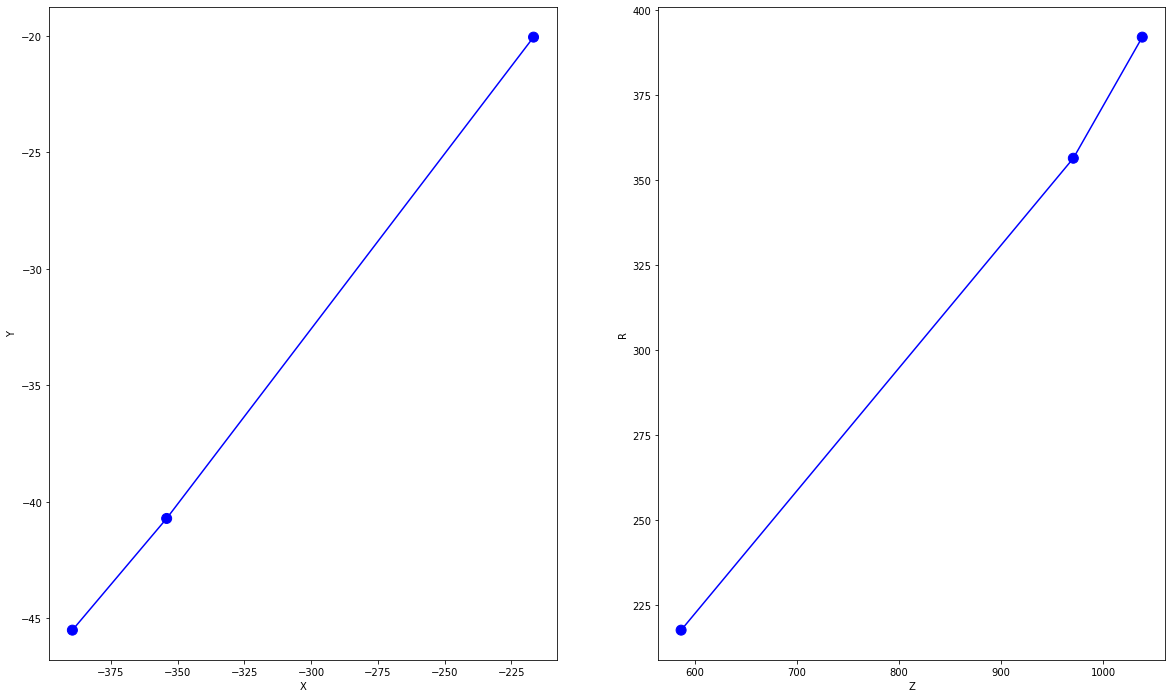

Event= 2    Sector= 16
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        5.0  ...  615.701233     -3.0     0.0

[1 rows x 8 columns]
Event= 2    Sector= 17
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         0      4.0        6.0  ...  539.349976     39.0     0.0
1         2      1.0        6.0  ...  586.391663     26.0     0.0

[2 rows x 8 columns]
Event= 2    Sector= 17


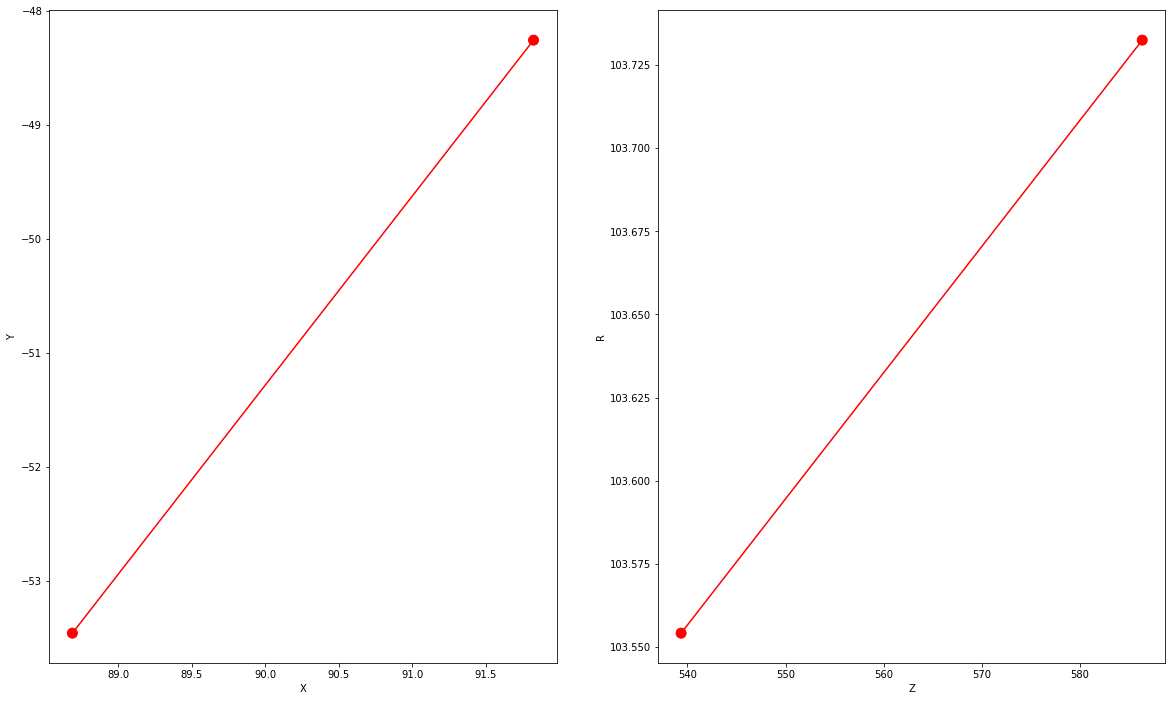

Event= 3    Sector= 1
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         4      2.0        2.0  ...  -694.934570    -99.0     0.0
1         6      3.0        2.0  ...  -793.598755      0.0     0.0
2        10      1.0        2.0  ... -1038.429199    -32.0     0.0
3        11      2.0        2.0  ... -1065.694946    -99.0     0.0

[4 rows x 8 columns]
Event= 3    Sector= 1


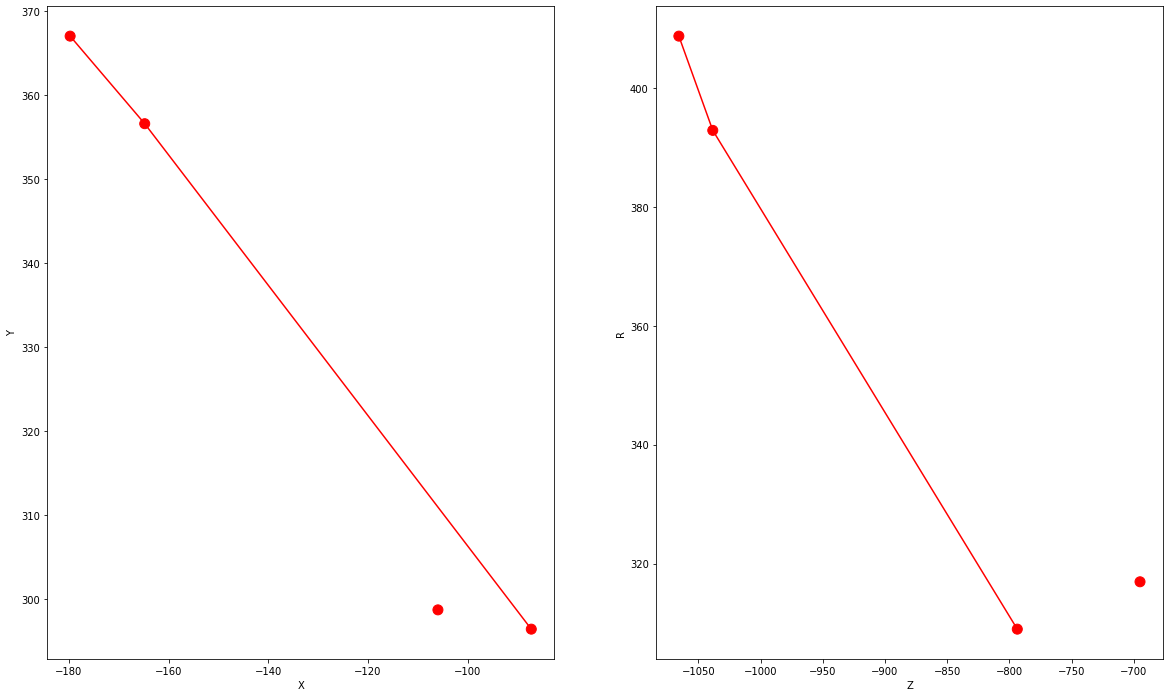

Event= 3    Sector= 2
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ... -586.350586     24.0     0.0

[1 rows x 8 columns]
Event= 3    Sector= 3
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ...  -615.685486     26.0     0.0
1         9      2.0        1.0  ...  -964.500000    -99.0     0.0
2         9      2.0        1.0  ...  -964.500000    -99.0     0.0
3        10      1.0        1.0  ... -1013.401001    -21.0     0.0
4        11      2.0        1.0  ... -1054.994995    -99.0     0.0

[5 rows x 8 columns]
Event= 3    Sector= 3


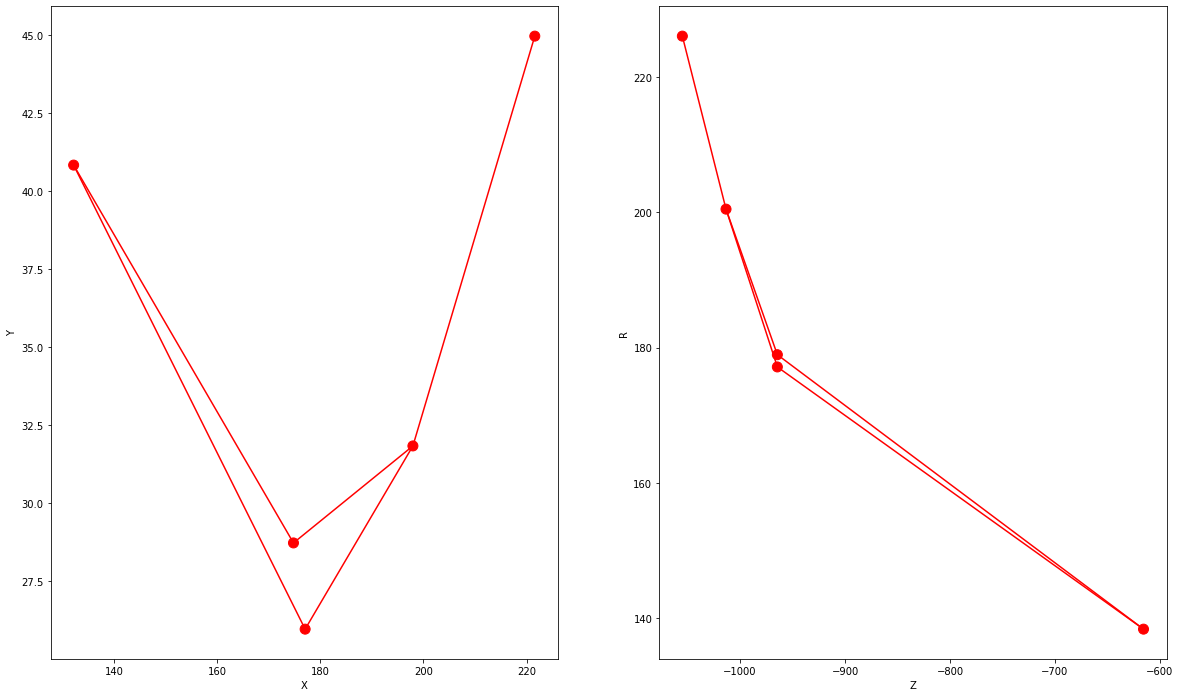

Event= 3    Sector= 4
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         0      4.0        2.0  ... -539.349976     32.0     0.0
1         2      1.0        2.0  ... -615.664795     12.0     0.0
2         7      1.0        2.0  ... -814.947388      0.0     0.0
3         9      2.0        2.0  ... -970.799988    -99.0     0.0

[4 rows x 8 columns]
Event= 3    Sector= 4


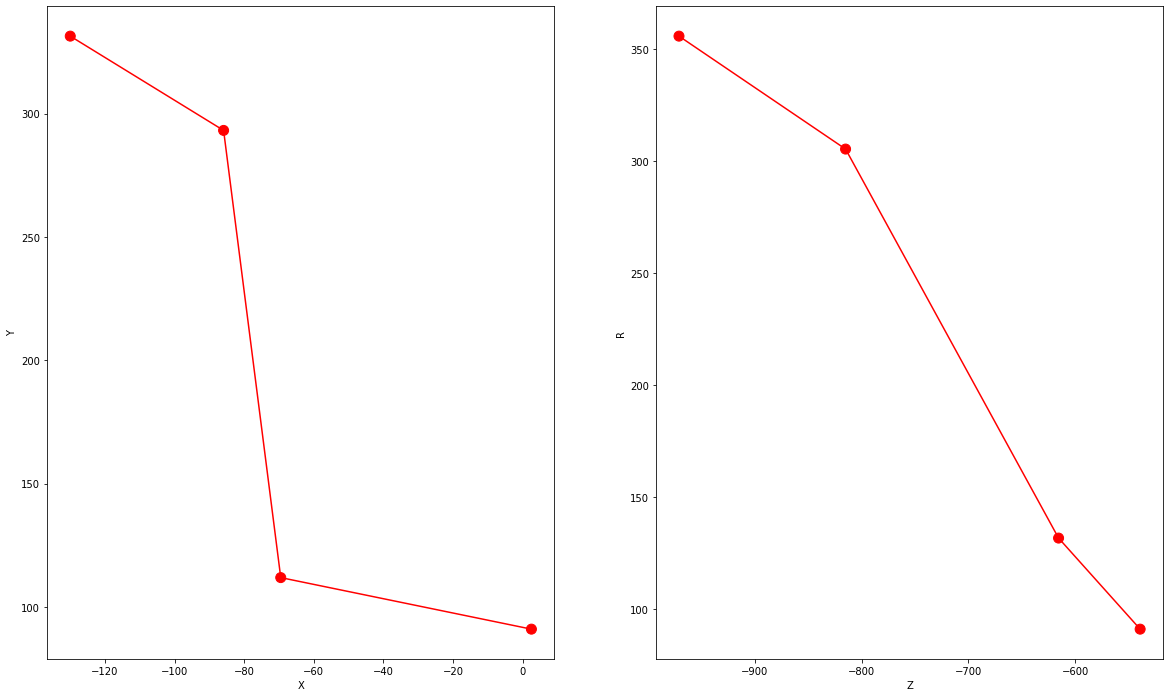

Event= 3    Sector= 5
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         9      2.0        6.0  ...  -964.500000    -99.0     0.0
1         9      2.0        6.0  ...  -964.500000    -99.0     0.0
2         9      2.0        6.0  ...  -964.500000    -99.0     0.0
3        10      1.0        6.0  ... -1013.401001    -21.0     0.0
4        11      2.0        6.0  ... -1054.994995    -99.0     0.0
5        11      2.0        6.0  ... -1054.994995    -99.0     0.0

[6 rows x 8 columns]
Event= 3    Sector= 5


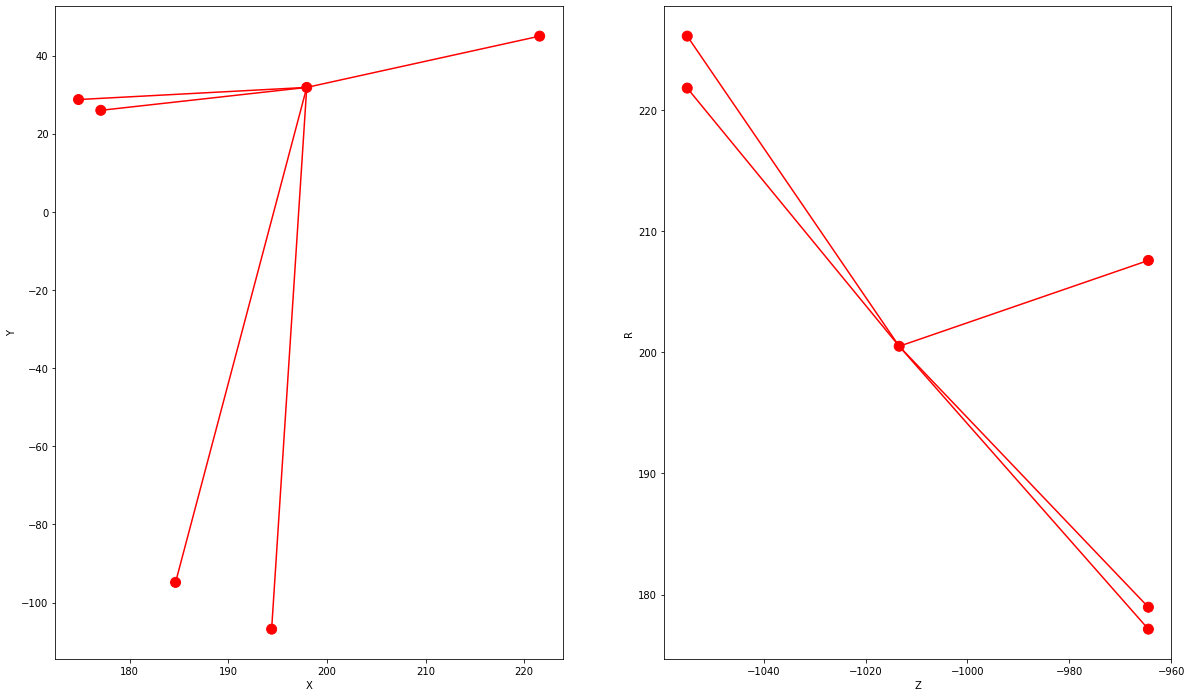

Event= 3    Sector= 6
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         3      1.0        2.0  ...   683.791199      0.0     1.0
1         4      2.0        2.0  ...   694.934570    -99.0     1.0
2         7      1.0        2.0  ...   814.876526      0.0     1.0
3         8      1.0        2.0  ...   949.052734      0.0     1.0
4         9      2.0        2.0  ...   970.799988    -99.0     1.0
5        10      1.0        2.0  ...  1038.379761      0.0     1.0
6        11      2.0        2.0  ...  1061.295044    -99.0     1.0

[7 rows x 8 columns]
Event= 3    Sector= 6


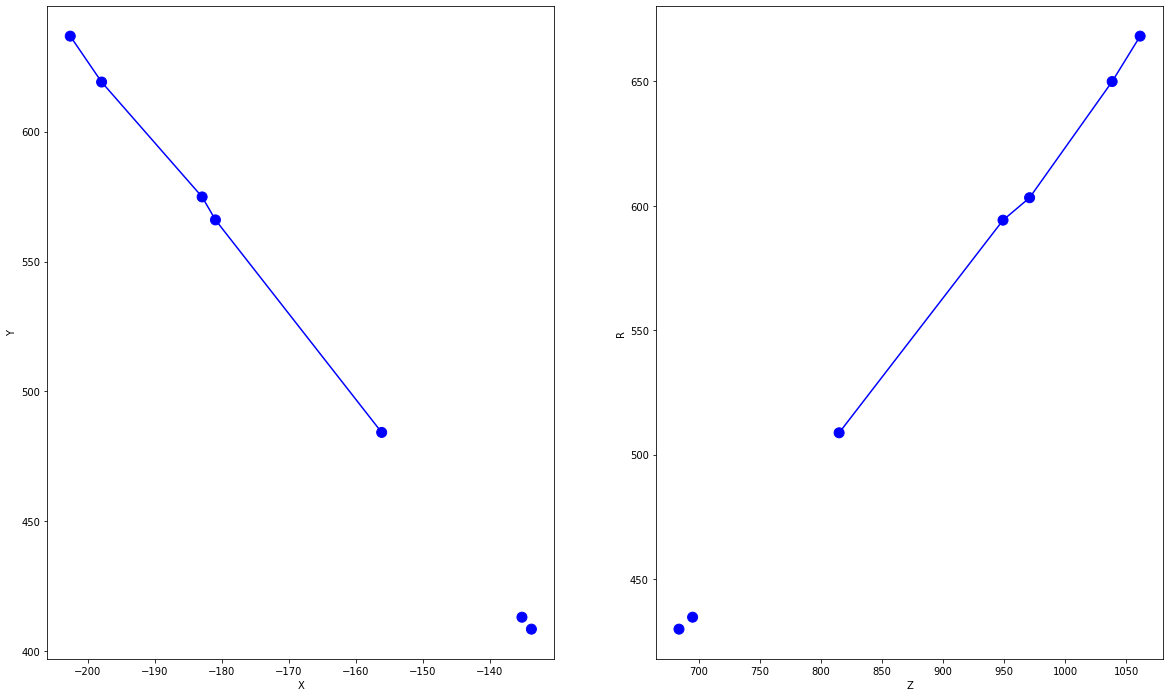

Event= 3    Sector= 7
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         1      3.0        5.0  ...  565.368774     -2.0     0.0

[1 rows x 8 columns]
Event= 3    Sector= 8
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         1      3.0        6.0  ...  565.368774     -2.0     0.0

[1 rows x 8 columns]
Event= 3    Sector= 9
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ...  615.682739    -17.0     0.0
1         2      1.0        1.0  ...  586.405151     12.0     0.0
2         7      1.0        1.0  ...  814.884766     10.0     0.0

[3 rows x 8 columns]
Event= 3    Sector= 9


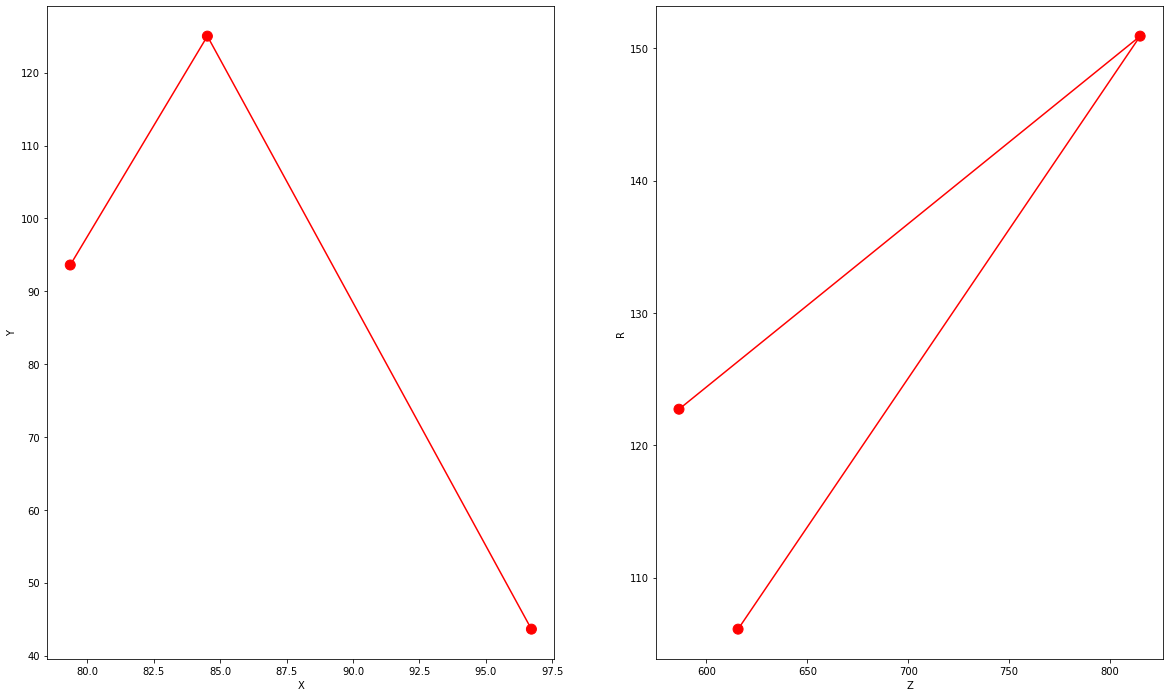

Event= 3    Sector= 10
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         7      1.0        2.0  ...  814.884766     10.0     0.0

[1 rows x 8 columns]
Event= 3    Sector= 11
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        3.0  ...  615.746155     -5.0     0.0

[1 rows x 8 columns]
Event= 3    Sector= 12
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ...   615.793518    -10.0     0.0
1         8      1.0        6.0  ...   948.600037      0.0     0.0
2         9      2.0        6.0  ...   968.900024    -99.0     0.0
3        10      1.0        6.0  ...  1038.437134      3.0     0.0
4        11      2.0        6.0  ...  1059.395020    -99.0     0.0

[5 rows x 8 columns]
Event= 3    Sector= 12


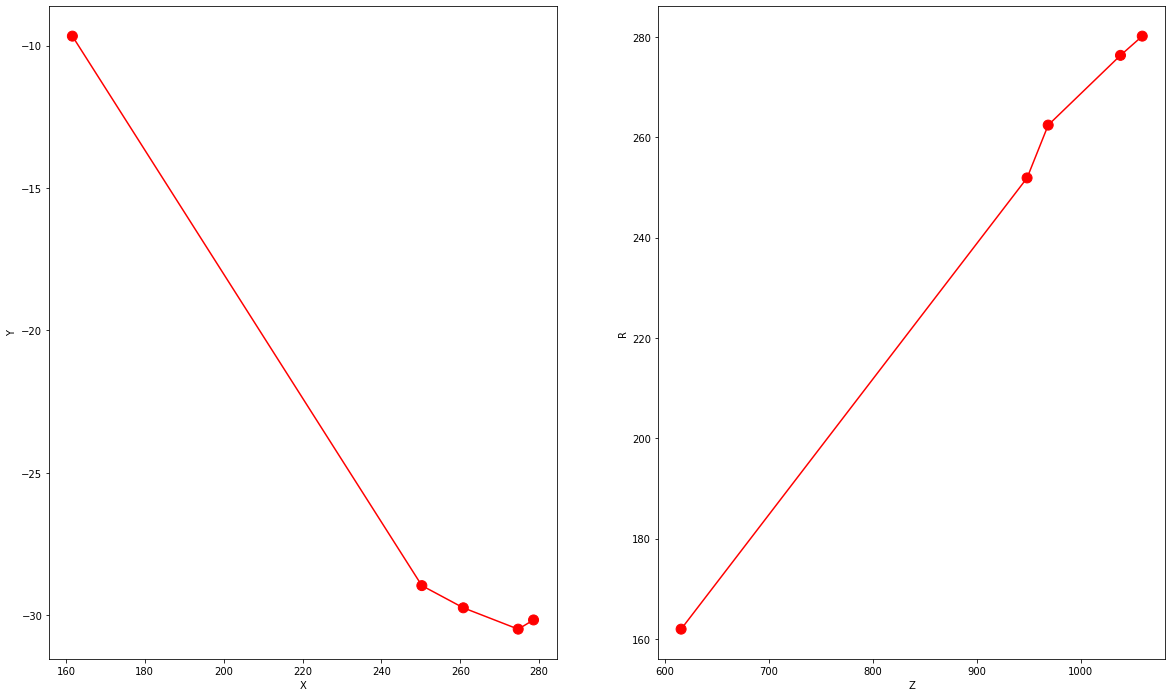

Event= 4    Sector= 1
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         0      4.0        1.0  ...  -539.349976     26.0     0.0
1         1      3.0        1.0  ...  -567.971252     -2.0     0.0
2         7      1.0        1.0  ...  -839.683472     -1.0     0.0
3         8      1.0        1.0  ...  -924.176025      7.0     0.0
4         9      2.0        1.0  ...  -964.500000    -99.0     0.0
5        10      1.0        1.0  ... -1013.528625     11.0     0.0
6        11      2.0        1.0  ... -1054.994995    -99.0     0.0

[7 rows x 8 columns]
Event= 4    Sector= 1


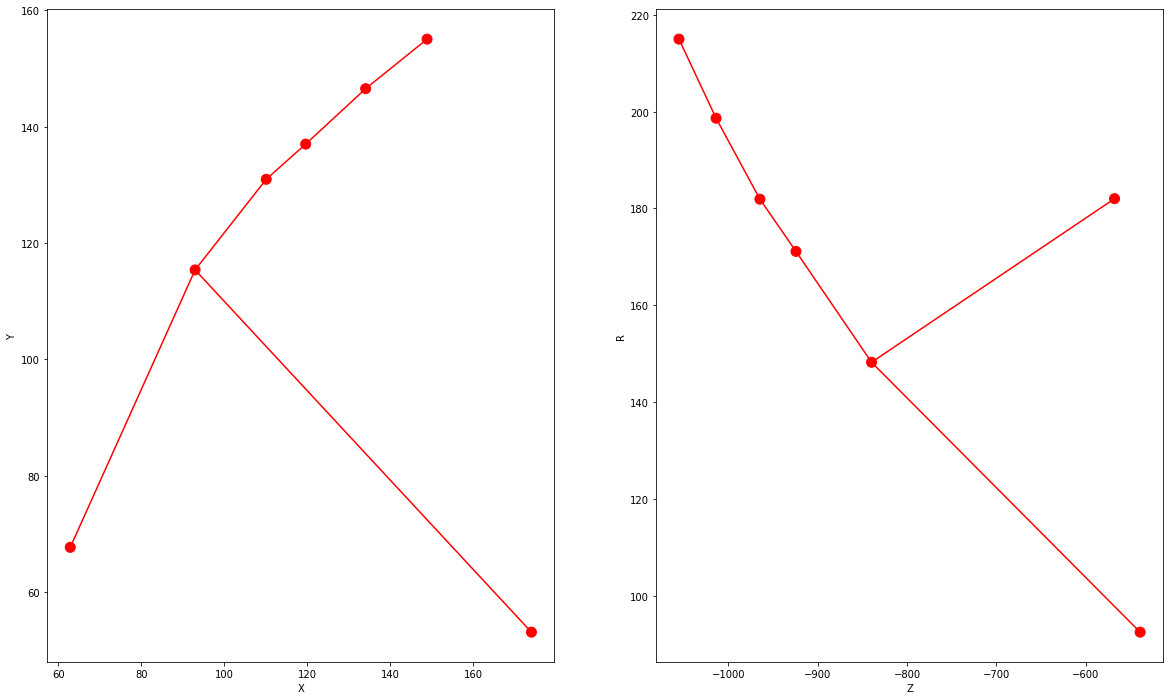

Event= 4    Sector= 2
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         0      4.0        2.0  ...  -539.349976    -27.0     0.0
1         1      3.0        2.0  ...  -567.971252     -2.0     0.0
2         2      1.0        2.0  ...  -586.384094     12.0     0.0
3         2      1.0        2.0  ...  -615.676270    -16.0     0.0
4         6      3.0        2.0  ...  -796.001221     -1.0     0.0
5         8      1.0        2.0  ...  -924.213623      6.0     0.0
6         9      2.0        2.0  ...  -964.500000    -99.0     0.0
7        10      1.0        2.0  ... -1013.478333      8.0     0.0
8        11      2.0        2.0  ... -1065.694946    -99.0     0.0

[9 rows x 8 columns]
Event= 4    Sector= 2


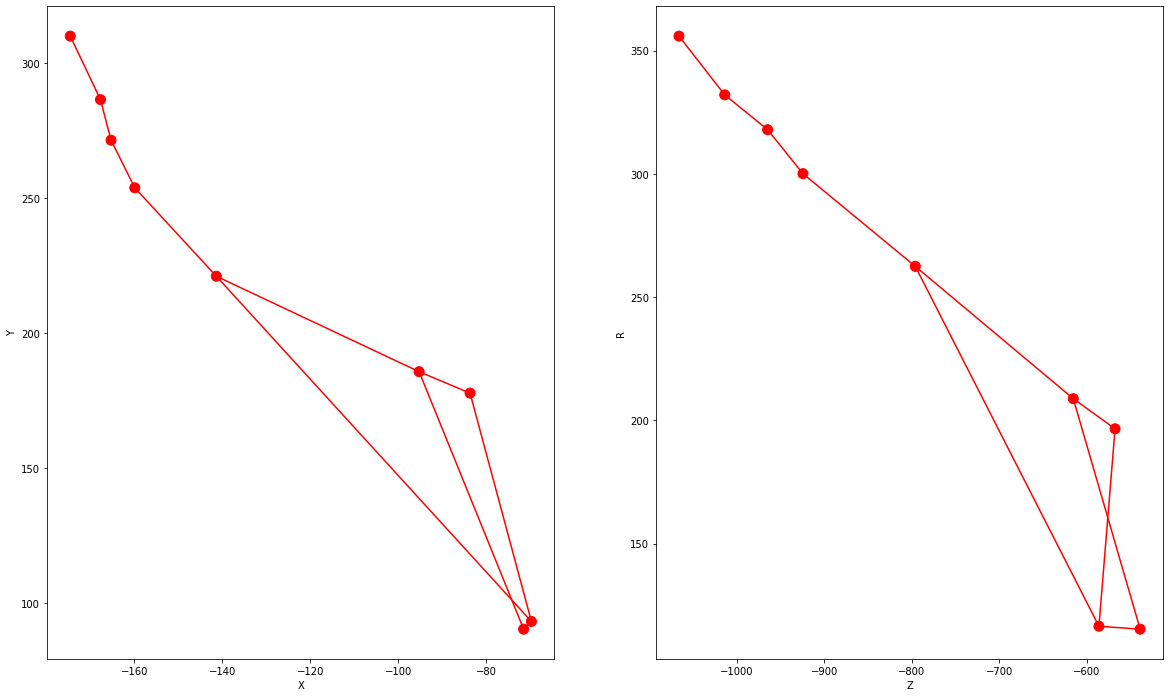

Event= 4    Sector= 3
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         0      4.0        3.0  ...  -539.349976    -27.0     0.0
1         2      1.0        3.0  ...  -586.384094     12.0     0.0
2         6      3.0        3.0  ...  -796.001221     -1.0     0.0
3         8      1.0        3.0  ...  -924.213623      6.0     0.0
4         9      2.0        3.0  ...  -964.500000    -99.0     0.0
5        10      1.0        3.0  ... -1013.478333      8.0     0.0

[6 rows x 8 columns]
Event= 4    Sector= 3


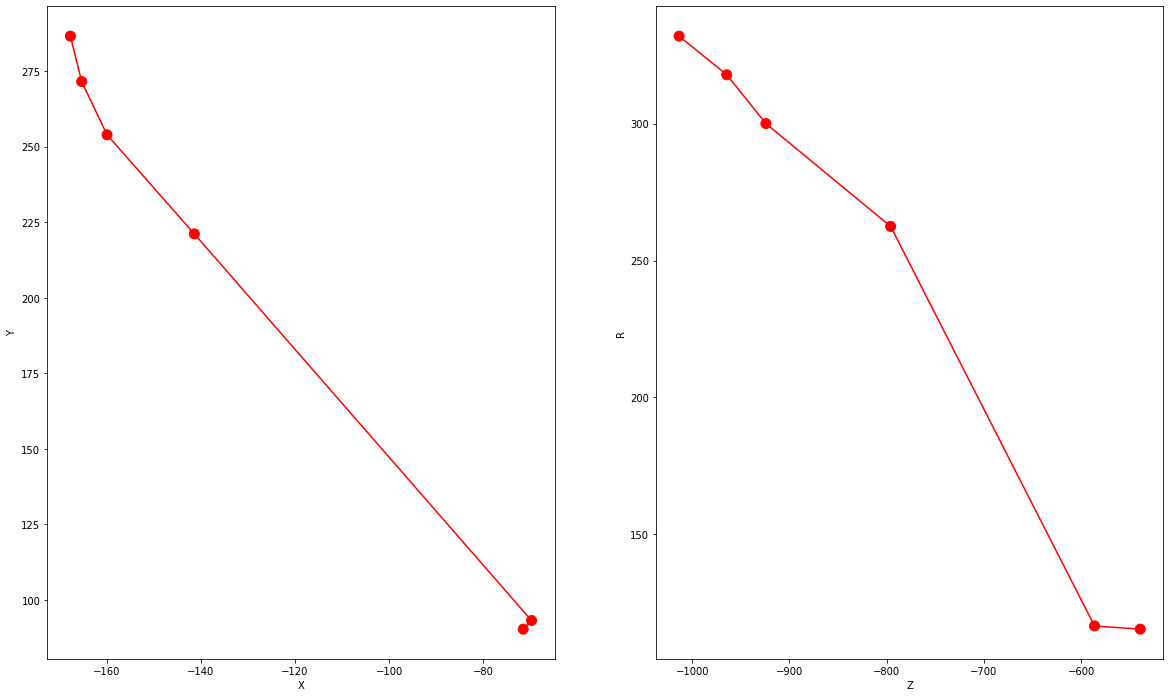

Event= 4    Sector= 4
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        5.0  ...  -615.696899     11.0     0.0
1         2      1.0        5.0  ...  -615.703979     11.0     0.0
2         7      1.0        5.0  ...  -814.898254      4.0     0.0
3         8      1.0        5.0  ...  -948.909424      0.0     0.0
4         9      2.0        5.0  ...  -968.900024    -99.0     0.0
5         9      2.0        5.0  ...  -968.900024    -99.0     0.0
6        10      1.0        5.0  ... -1038.403076      0.0     0.0
7        11      2.0        5.0  ... -1059.395020    -99.0     0.0
8        11      2.0        5.0  ... -1059.395020    -99.0     0.0

[9 rows x 8 columns]
Event= 4    Sector= 4


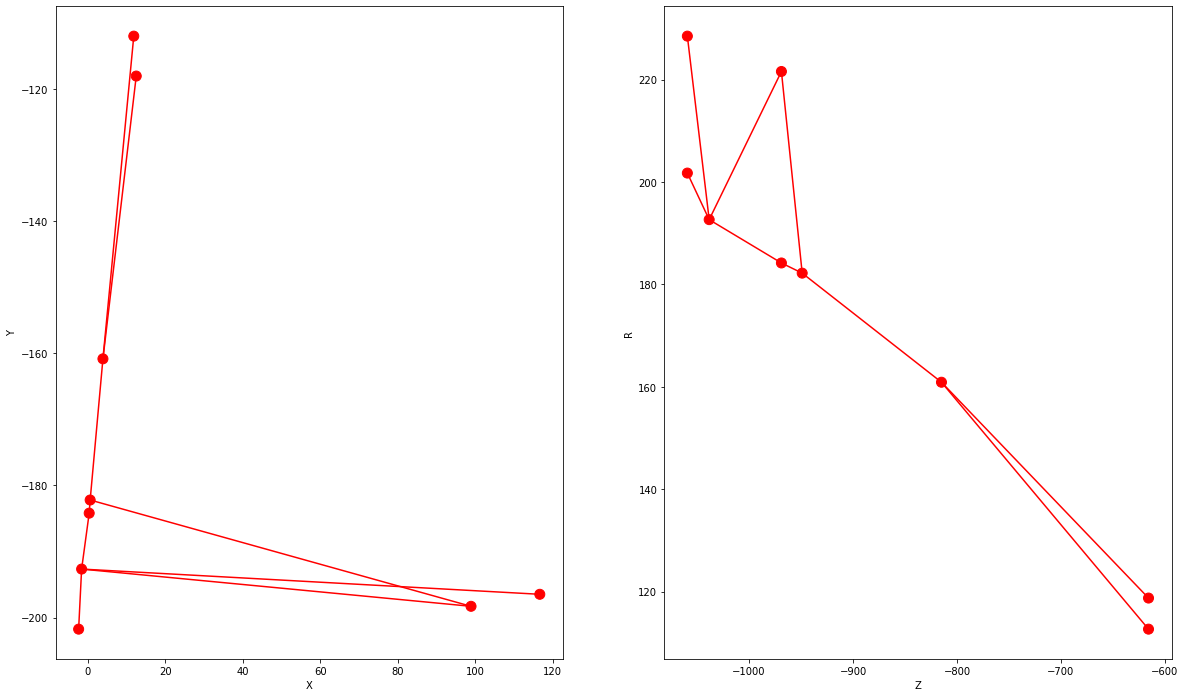

Event= 4    Sector= 5
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ...  615.726440     20.0     0.0
1         2      1.0        1.0  ...  615.711426    -12.0     0.0
2         7      1.0        1.0  ...  814.945312    -20.0     0.0

[3 rows x 8 columns]
Event= 4    Sector= 5


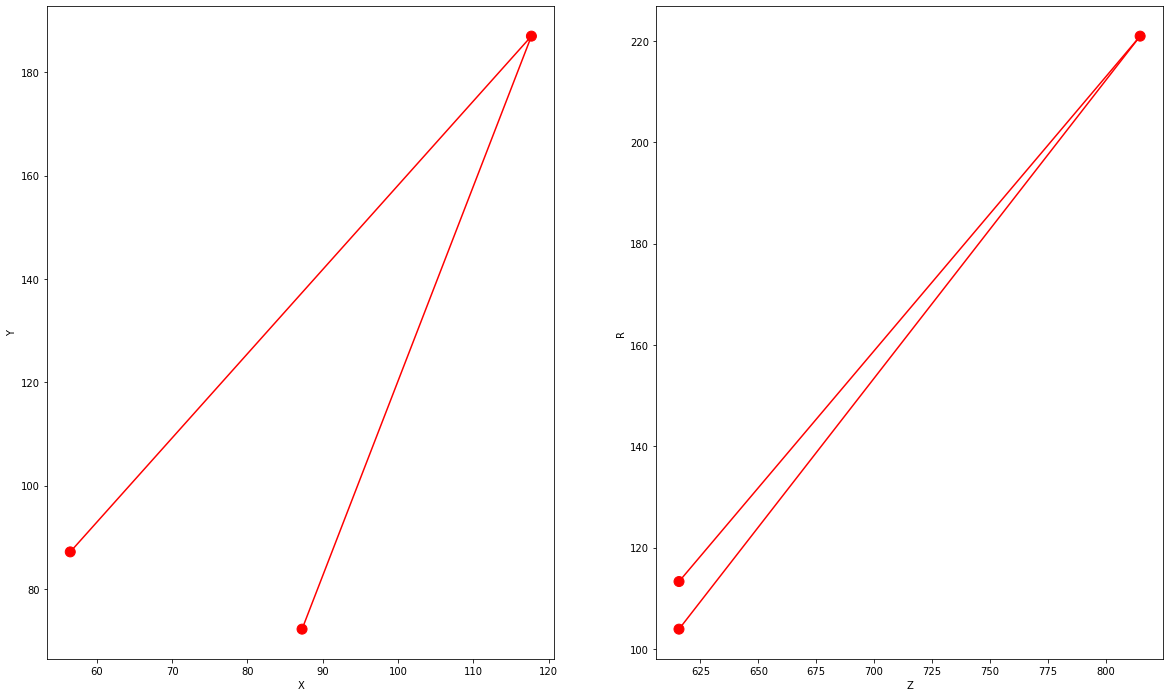

Event= 4    Sector= 6
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         0      4.0        2.0  ...   539.349976     26.0     1.0
1         2      1.0        2.0  ...   615.662842      9.0     1.0
2         2      1.0        2.0  ...   615.677795     29.0     0.0
3         6      3.0        2.0  ...   793.598755      0.0     1.0
4         7      1.0        2.0  ...   815.090332      4.0     1.0
5         7      1.0        2.0  ...   814.945312    -20.0     0.0
6         8      1.0        2.0  ...   948.719666      0.0     1.0
7         9      2.0        2.0  ...   968.900024    -99.0     1.0
8        10      1.0        2.0  ...  1038.667480     -4.0     1.0
9        11      2.0        2.0  ...  1059.395020    -99.0     1.0

[10 rows x 8 columns]
Event= 4    Sector= 6


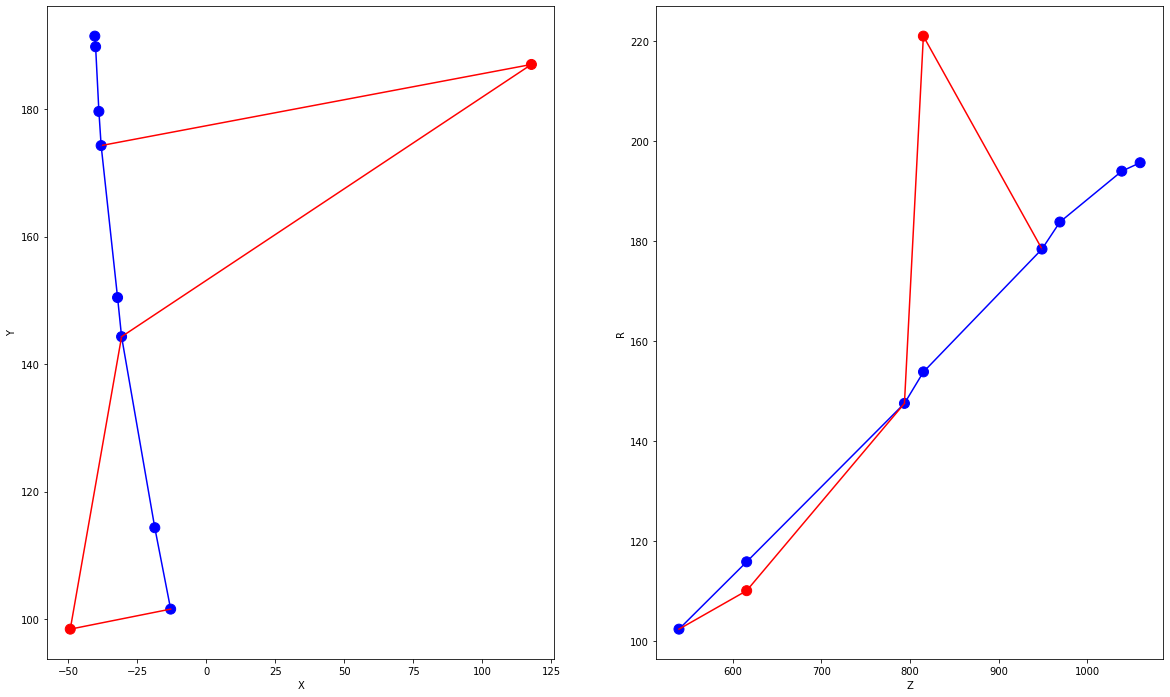

Event= 4    Sector= 7
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ...  586.385986     31.0     0.0
1         2      1.0        4.0  ...  586.498535      3.0     0.0
2         2      1.0        4.0  ...  586.503967     24.0     0.0
3         2      1.0        4.0  ...  586.500061      3.0     0.0
4         2      1.0        4.0  ...  586.505249     24.0     0.0
5         2      1.0        4.0  ...  615.714355     10.0     0.0

[6 rows x 8 columns]
Event= 4    Sector= 8
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        5.0  ...  586.361938     -8.0     0.0
1         2      1.0        5.0  ...  615.683594     -5.0     0.0
2         2      1.0        5.0  ...  615.672058     11.0     0.0
3         7      1.0        5.0  ...  839.791626     -7.0     0.0

[4 rows x 8 columns]
Event= 4    Sector= 8


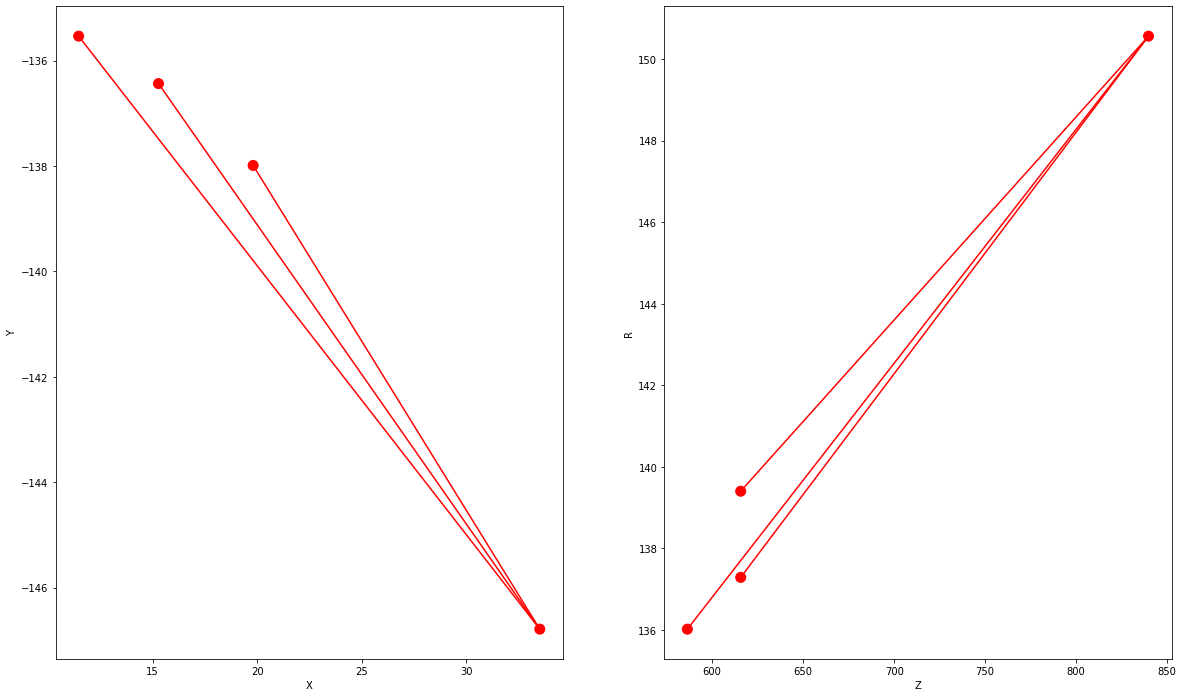

Event= 4    Sector= 9
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ...  615.799683    -10.0     0.0

[1 rows x 8 columns]
Event= 5    Sector= 1
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         9      2.0        3.0  ... -975.200012    -99.0     0.0

[1 rows x 8 columns]
Event= 5    Sector= 2
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         0      4.0        1.0  ... -539.349976    -26.0     0.0
1         2      1.0        1.0  ... -586.276978    -21.0     0.0

[2 rows x 8 columns]
Event= 5    Sector= 2


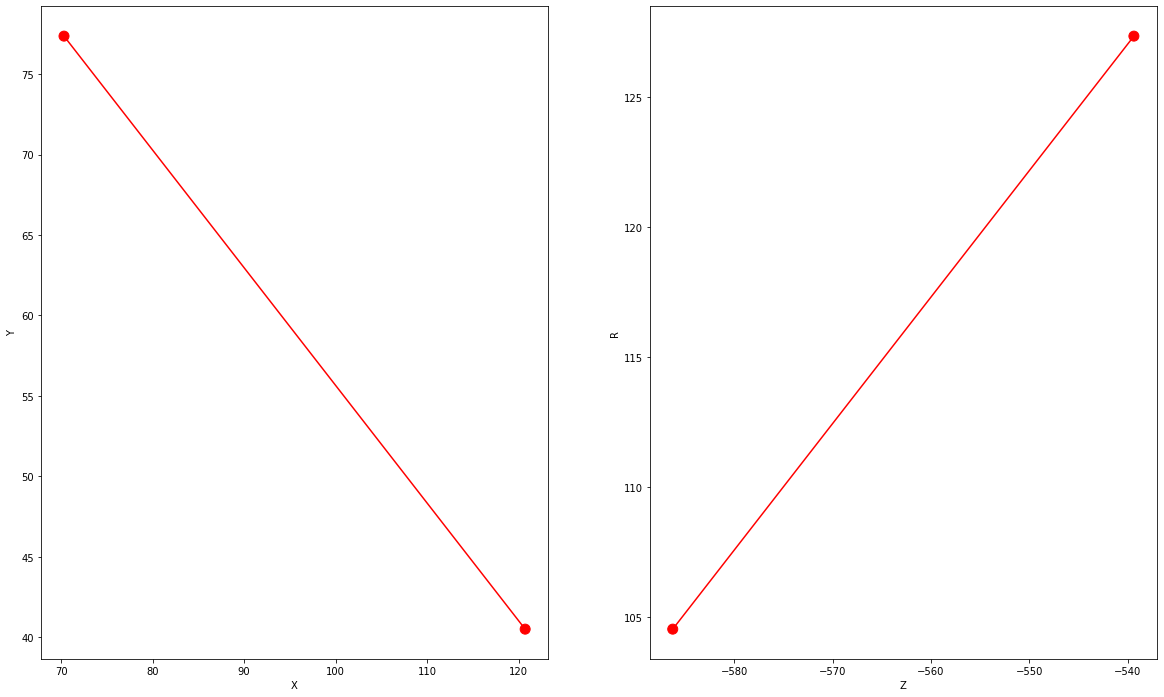

Event= 5    Sector= 3
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        3.0  ...  -586.355408    -32.0     0.0
1         2      1.0        3.0  ...  -586.482361    -26.0     0.0
2         2      1.0        3.0  ...  -586.351746     16.0     0.0
3        11      2.0        3.0  ... -1059.395020    -99.0     0.0

[4 rows x 8 columns]
Event= 5    Sector= 3


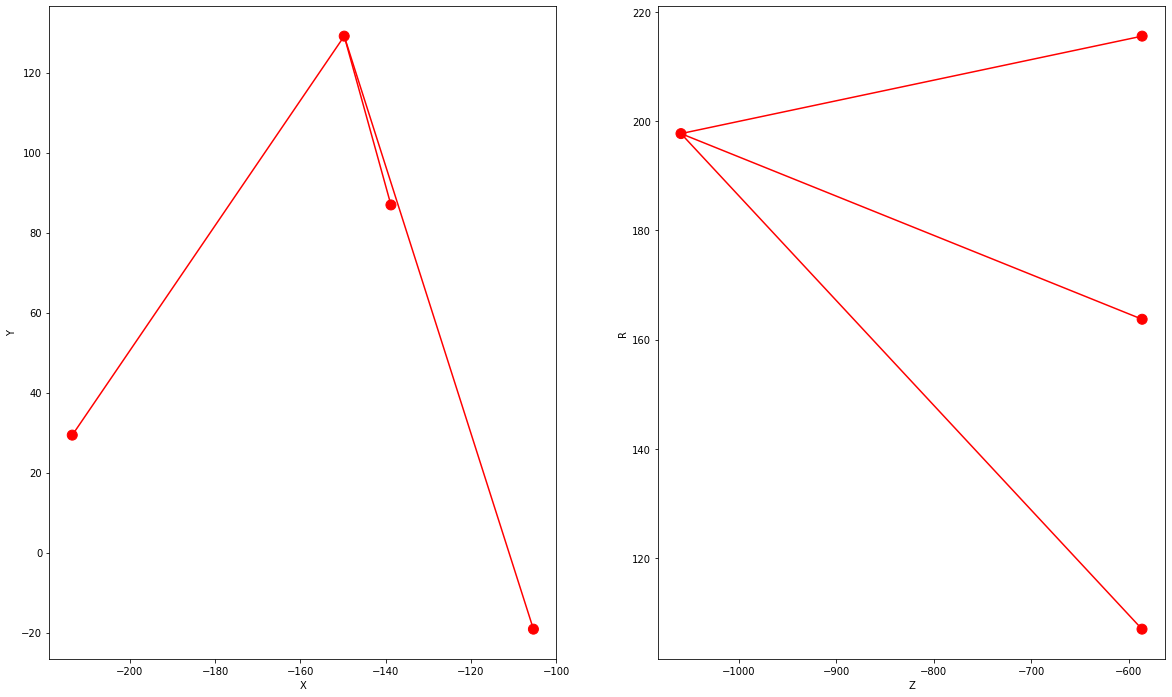

Event= 5    Sector= 4
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ... -586.482361    -26.0     0.0

[1 rows x 8 columns]
Event= 5    Sector= 5
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         1      3.0        6.0  ... -565.368774      3.0     0.0

[1 rows x 8 columns]
Event= 5    Sector= 6
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ...   586.423157    -32.0     0.0
1         2      1.0        1.0  ...   615.879883    -32.0     0.0
2         9      2.0        1.0  ...   964.500000    -99.0     0.0
3        11      2.0        1.0  ...  1054.994995    -99.0     0.0

[4 rows x 8 columns]
Event= 5    Sector= 6


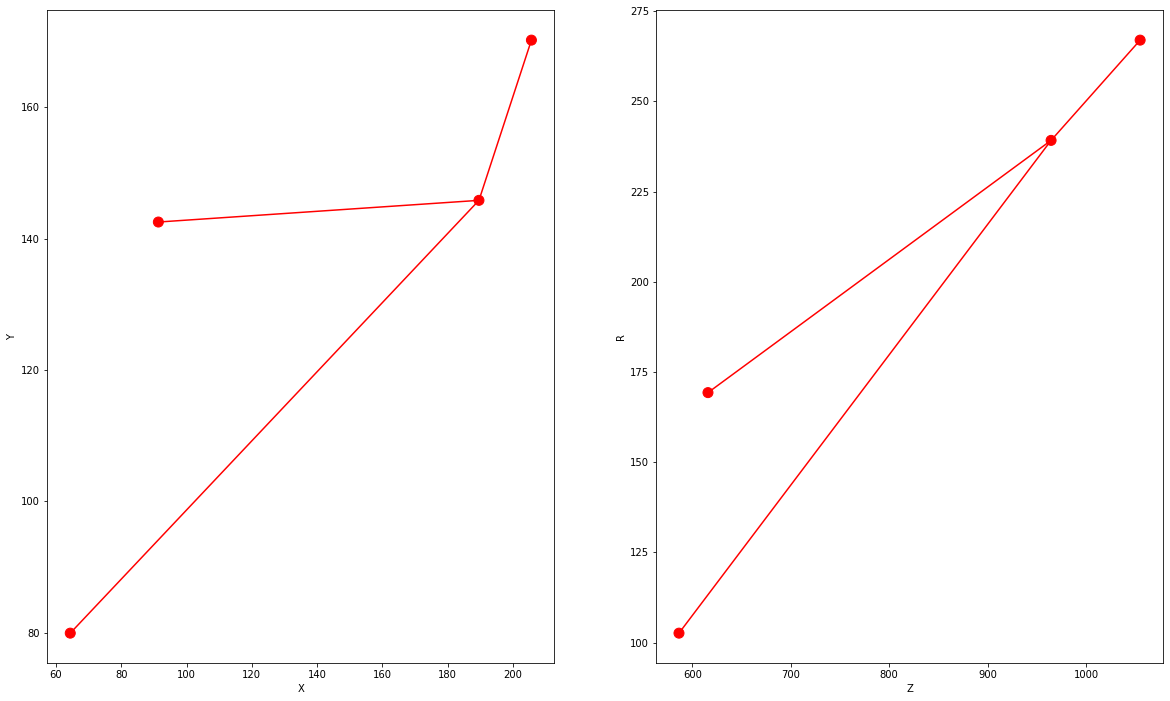

Event= 5    Sector= 7
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        2.0  ...   615.727966     16.0     0.0
1         7      1.0        2.0  ...   839.767334     12.0     0.0
2         9      2.0        2.0  ...   964.500000    -99.0     0.0
3        10      1.0        2.0  ...  1013.803284      0.0     0.0
4        11      2.0        2.0  ...  1054.994995    -99.0     0.0

[5 rows x 8 columns]
Event= 5    Sector= 7


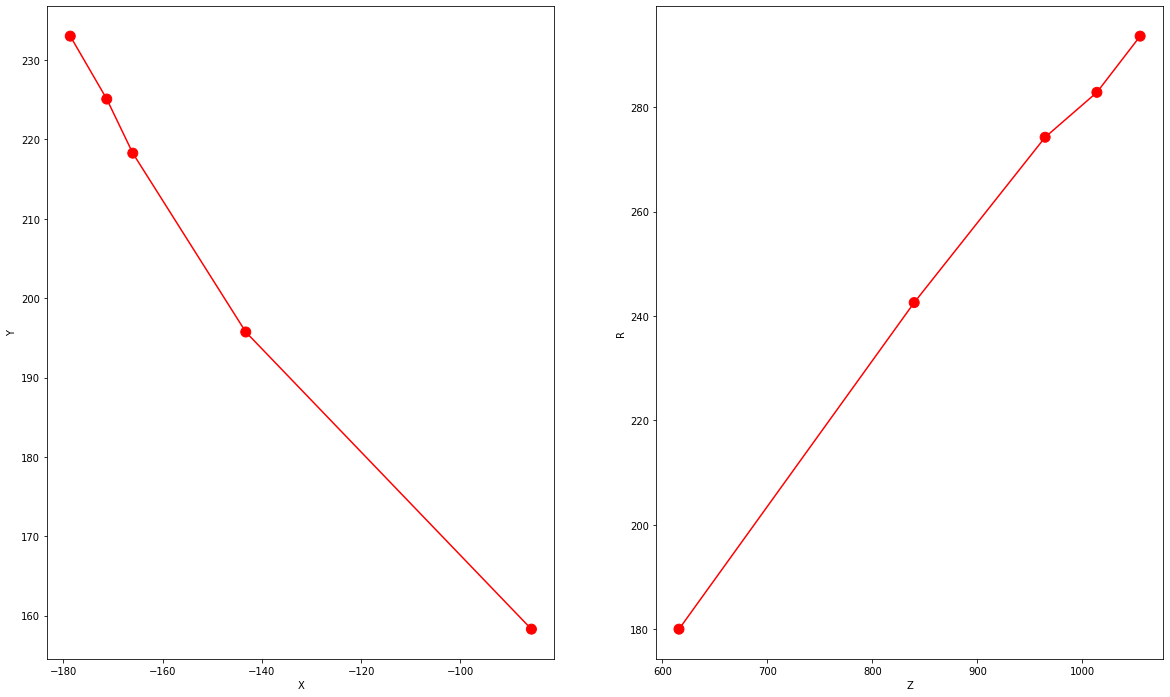

Event= 5    Sector= 8
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         7      1.0        3.0  ...   839.767334     12.0     0.0
1         9      2.0        3.0  ...   964.500000    -99.0     0.0
2        10      1.0        3.0  ...  1013.803284      0.0     0.0
3        11      2.0        3.0  ...  1054.994995    -99.0     0.0

[4 rows x 8 columns]
Event= 5    Sector= 8


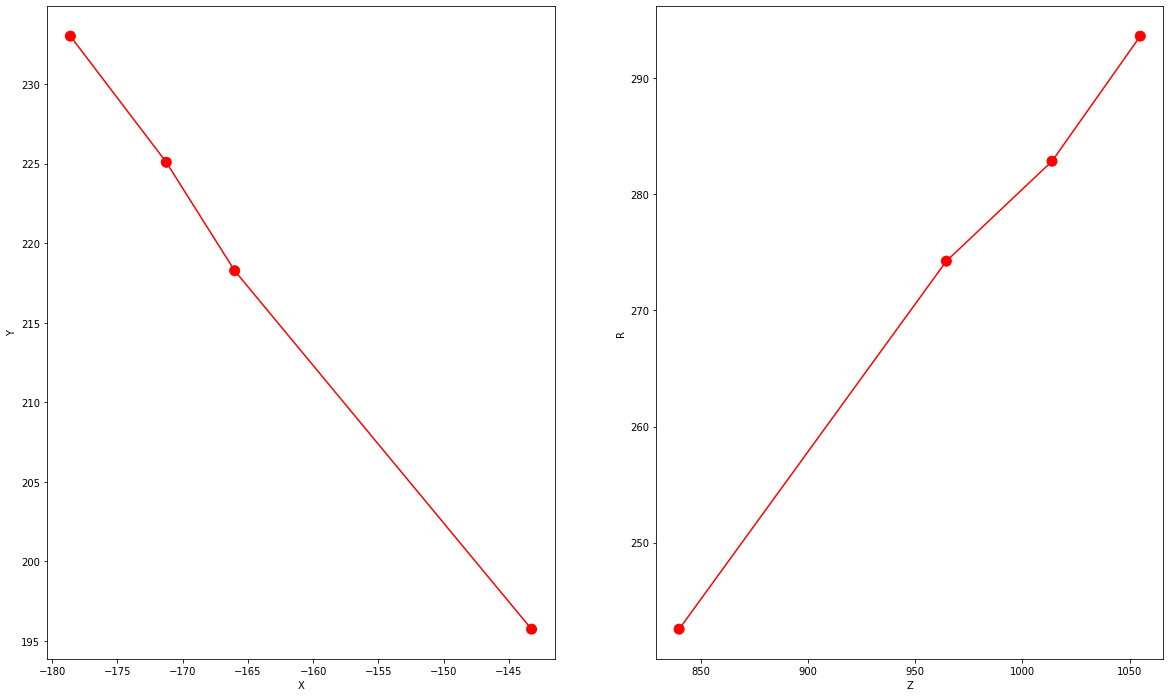

Event= 5    Sector= 9
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         1      3.0        5.0  ...  565.368774      1.0     1.0
1         1      3.0        5.0  ...  567.971252      1.0     0.0
2         2      1.0        5.0  ...  586.396179      5.0     1.0

[3 rows x 8 columns]
Event= 5    Sector= 9


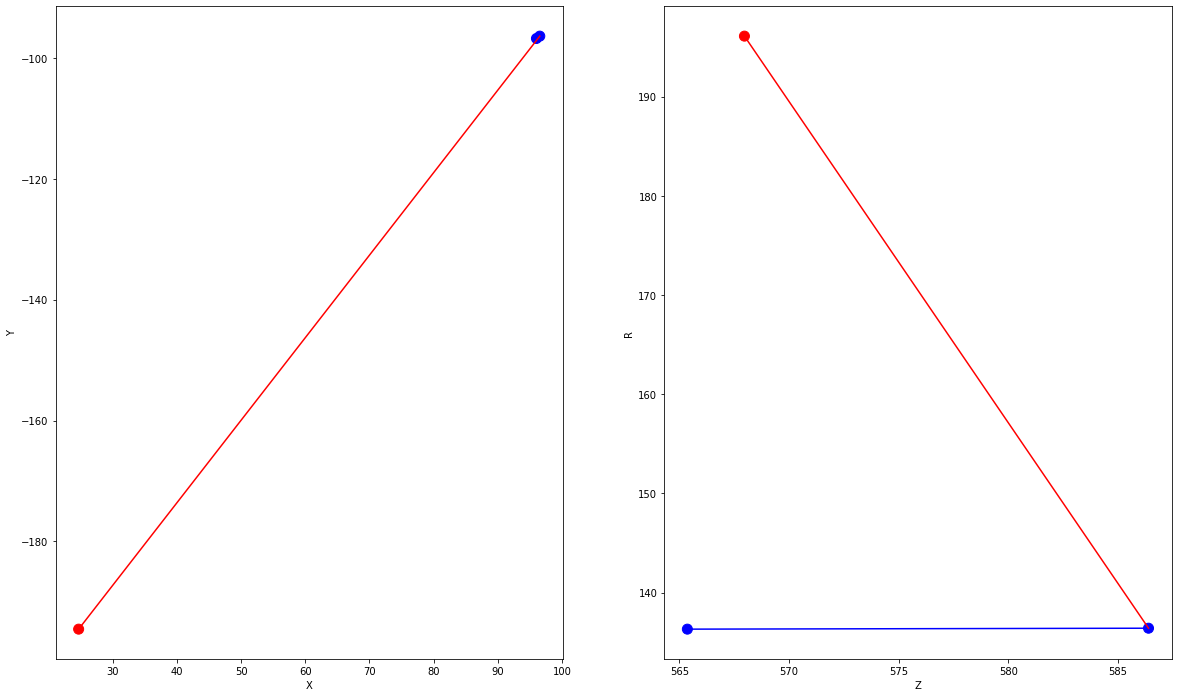

Event= 5    Sector= 10
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         0      4.0        6.0  ...   539.349976     12.0     1.0
1         1      3.0        6.0  ...   565.368774      1.0     1.0
2         2      1.0        6.0  ...   615.699524      3.0     1.0
3         2      1.0        6.0  ...   586.396179      5.0     1.0
4         6      3.0        6.0  ...   796.001221      0.0     1.0
5         7      1.0        6.0  ...   839.706360      0.0     1.0
6         8      1.0        6.0  ...   923.831177      2.0     1.0
7         9      2.0        6.0  ...   964.500000    -99.0     1.0
8        10      1.0        6.0  ...  1013.774780      0.0     1.0
9        11      2.0        6.0  ...  1054.994995    -99.0     1.0

[10 rows x 8 columns]
Event= 5    Sector= 10


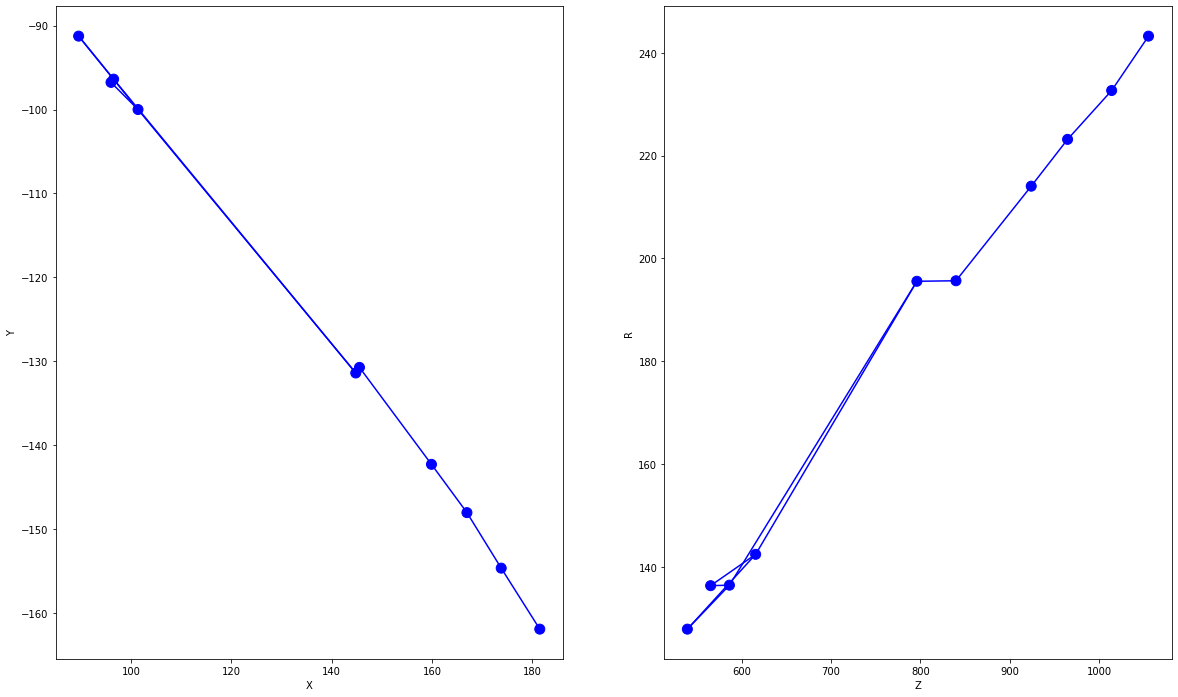

Event= 6    Sector= 1
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ...  -615.652344      6.0     0.0
1         2      1.0        1.0  ...  -615.621033    -32.0     0.0
2         2      1.0        1.0  ...  -586.454285    -27.0     0.0
3        10      1.0        1.0  ... -1013.448059     20.0     0.0

[4 rows x 8 columns]
Event= 6    Sector= 1


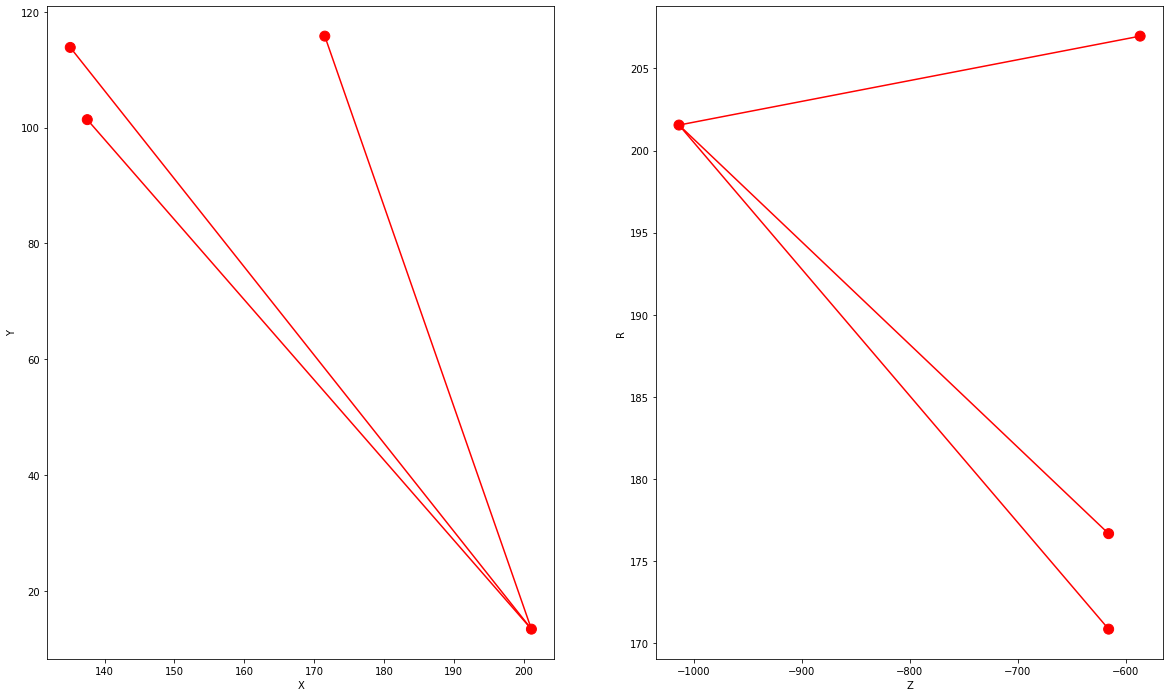

Event= 6    Sector= 2
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        3.0  ... -586.394836     -2.0     0.0

[1 rows x 8 columns]
Event= 6    Sector= 3
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0        11      2.0        4.0  ... -1061.295044    -99.0     0.0

[1 rows x 8 columns]
Event= 6    Sector= 4
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         0      4.0        5.0  ... -539.349976     14.0     0.0

[1 rows x 8 columns]
Event= 6    Sector= 5
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         0      4.0        6.0  ...  -539.349976     14.0     0.0
1        10      1.0        6.0  ... -1013.448059     20.0     0.0
2        11      2.0        6.0  ... -1054.994995    -99.0     0.0

[3 rows x 8 columns]
Event= 6    Sector= 5


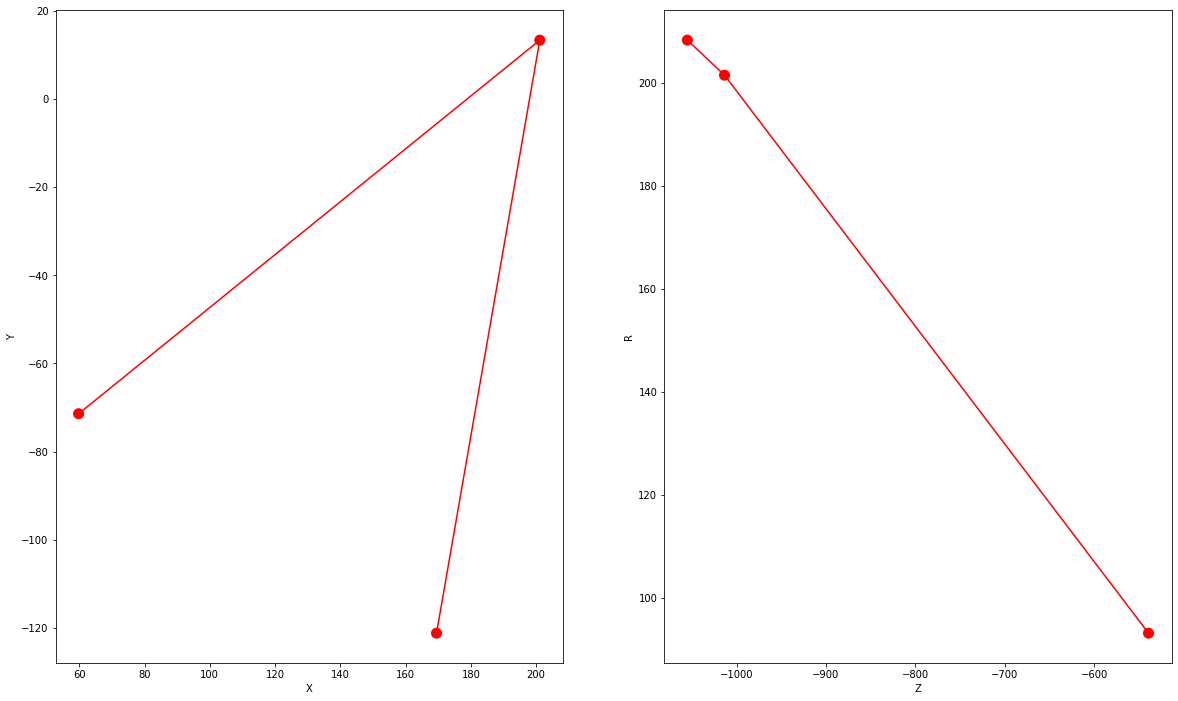

Event= 6    Sector= 6
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         4      2.0        1.0  ...  725.950012    -99.0     0.0

[1 rows x 8 columns]
Event= 6    Sector= 7
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ...   615.798767    -12.0     0.0
1         2      1.0        1.0  ...   586.354614     -6.0     0.0
2         2      1.0        1.0  ...   586.306458    -20.0     0.0
3         9      2.0        1.0  ...   964.500000    -99.0     0.0
4         9      2.0        1.0  ...   968.900024    -99.0     0.0
5        11      2.0        1.0  ...  1054.994995    -99.0     0.0

[6 rows x 8 columns]
Event= 6    Sector= 7


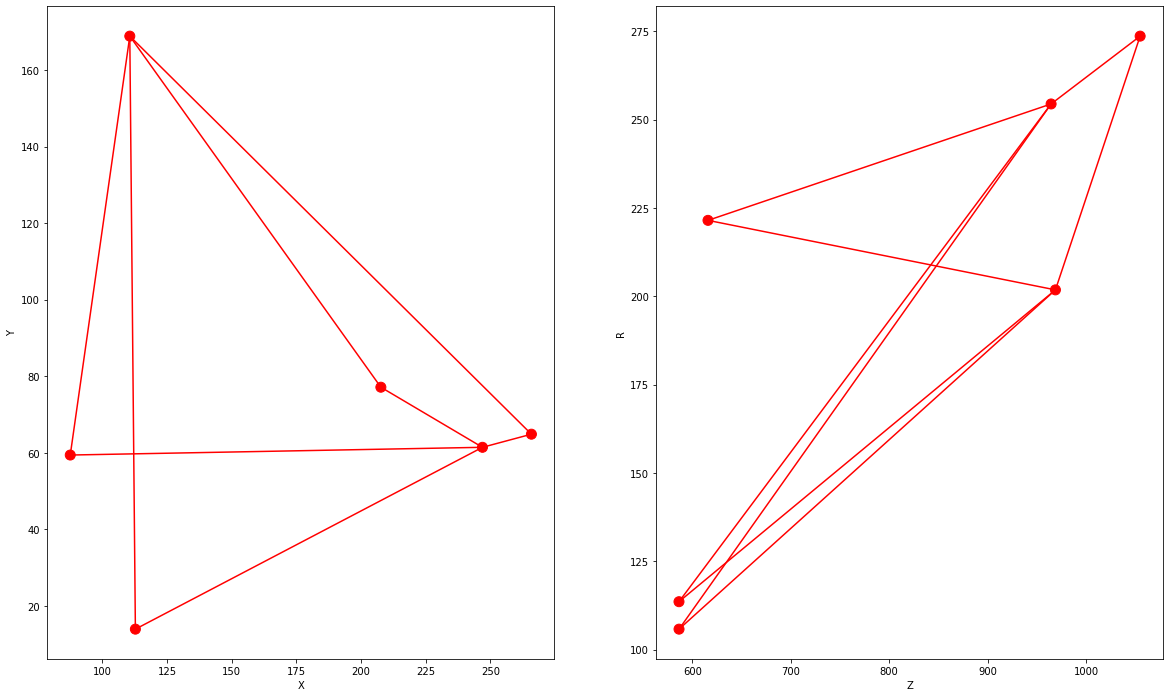

Event= 6    Sector= 8
df_hits = 
    vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0          0      4.0        2.0  ...   539.349976    -12.0     1.0
1          2      1.0        2.0  ...   615.652710     -4.0     1.0
2          2      1.0        2.0  ...   586.502014    -26.0     0.0
3          6      3.0        2.0  ...   796.001221      0.0     1.0
4          7      1.0        2.0  ...   839.772095     -3.0     1.0
5          8      1.0        2.0  ...   923.791809      0.0     1.0
6          9      2.0        2.0  ...   964.500000    -99.0     1.0
7          9      2.0        2.0  ...   968.900024    -99.0     0.0
8         10      1.0        2.0  ...  1013.881226      0.0     1.0
9         11      2.0        2.0  ...  1054.994995    -99.0     1.0
10        11      2.0        2.0  ...  1054.994995    -99.0     0.0

[11 rows x 8 columns]
Event= 6    Sector= 8


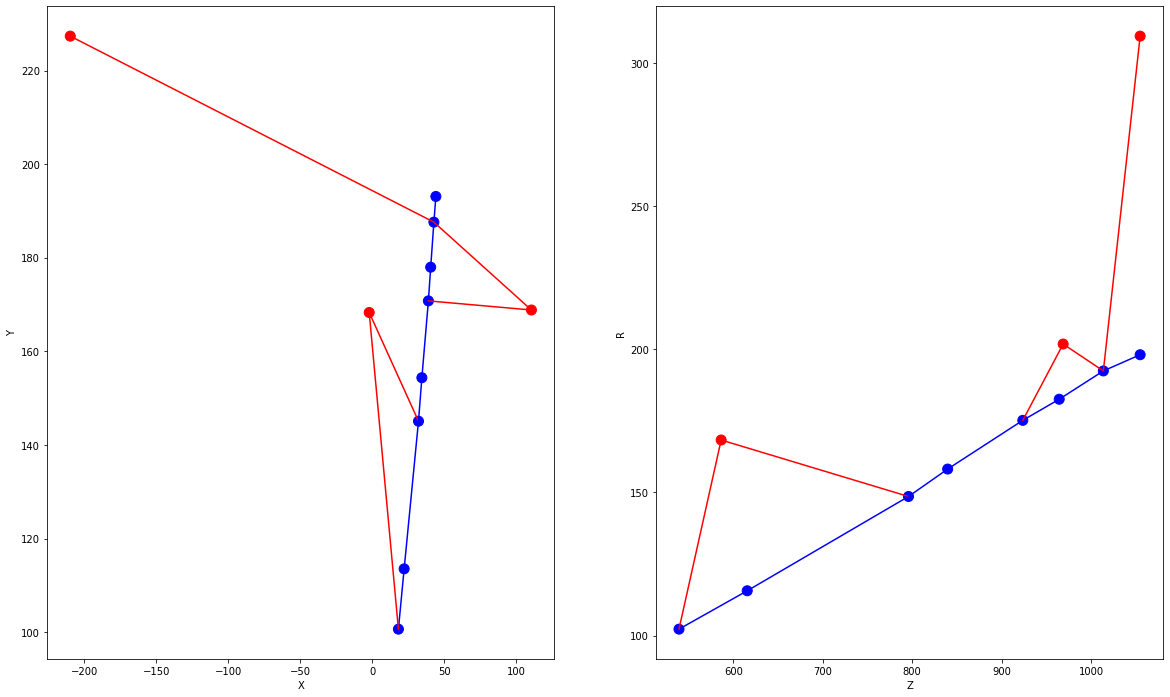

Event= 6    Sector= 9
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        3.0  ...   586.476501    -16.0     0.0
1         7      1.0        3.0  ...   839.820435     13.0     0.0
2        11      2.0        3.0  ...  1054.994995    -99.0     0.0

[3 rows x 8 columns]
Event= 6    Sector= 9


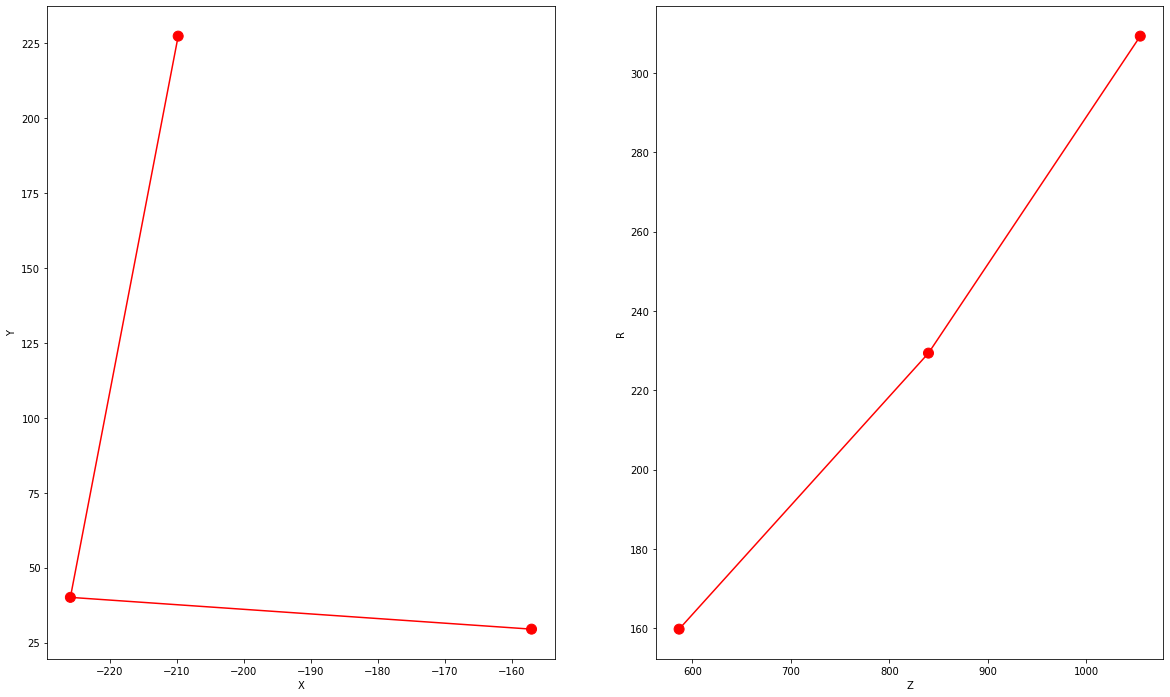

Event= 6    Sector= 10
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        5.0  ...  615.731873     29.0     0.0
1         2      1.0        5.0  ...  615.774414    -10.0     0.0
2         2      1.0        5.0  ...  615.713135     21.0     0.0
3         2      1.0        5.0  ...  586.361267    -28.0     0.0

[4 rows x 8 columns]
Event= 6    Sector= 11
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ...   586.361267    -28.0     0.0
1         2      1.0        6.0  ...   615.700256     22.0     0.0
2         2      1.0        6.0  ...   586.306458    -20.0     0.0
3         9      2.0        6.0  ...   964.500000    -99.0     0.0
4        11      2.0        6.0  ...  1054.994995    -99.0     0.0

[5 rows x 8 columns]
Event= 6    Sector= 11


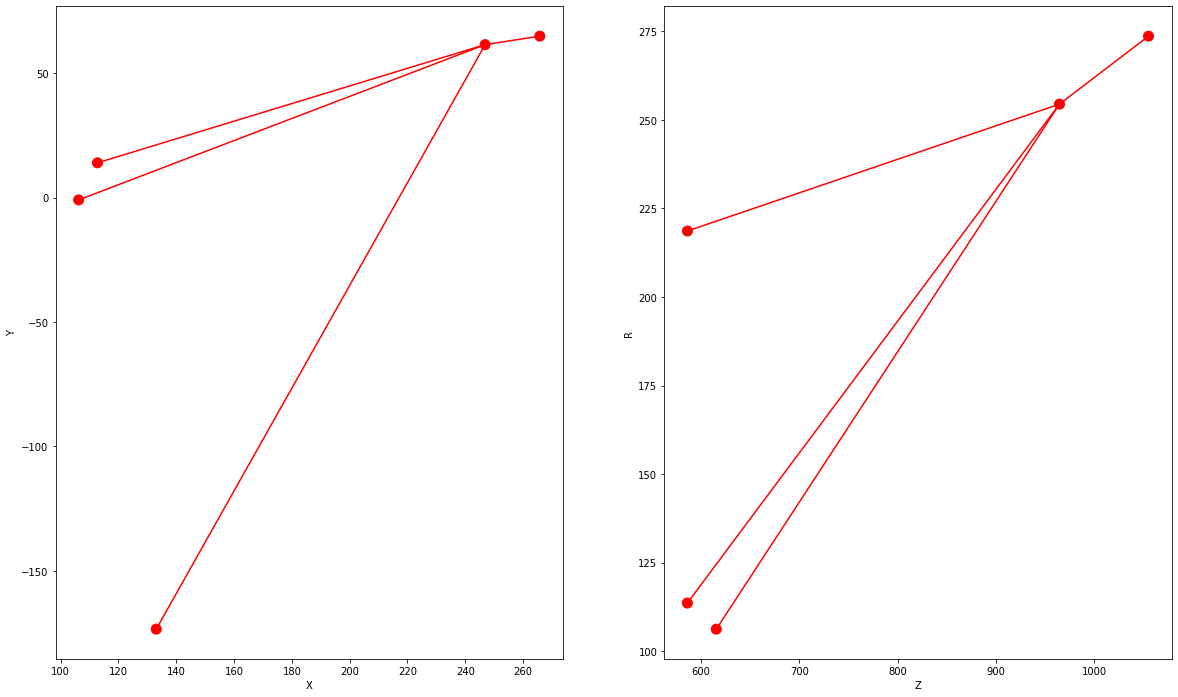

Event= 7    Sector= 1
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         1      3.0        3.0  ... -565.368774      0.0     0.0
1         3      1.0        3.0  ... -684.328796     31.0     0.0
2         4      2.0        3.0  ... -725.950012    -99.0     0.0

[3 rows x 8 columns]
Event= 7    Sector= 2
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ... -615.698425    -11.0     0.0
1         2      1.0        1.0  ... -586.519836    -11.0     0.0

[2 rows x 8 columns]
Event= 7    Sector= 3
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        2.0  ... -586.405029     16.0     0.0

[1 rows x 8 columns]
Event= 7    Sector= 4
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ... -615.739685     28.0     0.0
1         2      1.0        4.0  ... -615.768433     16.0     0.0
2         

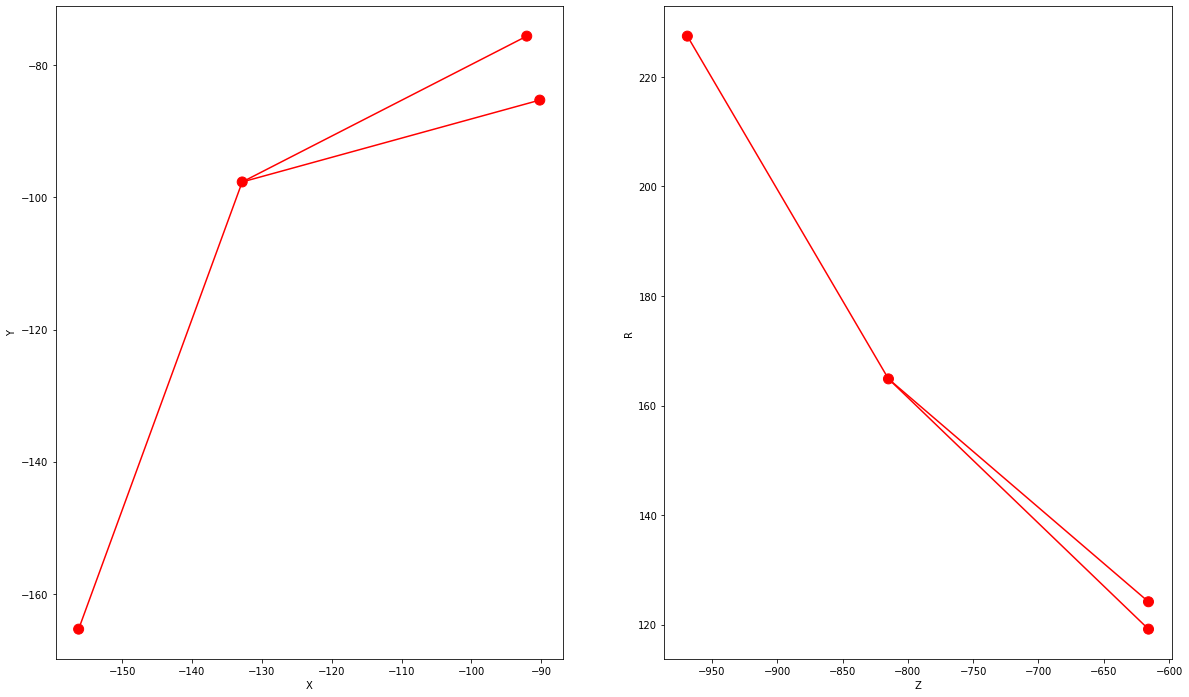

Event= 7    Sector= 5
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        5.0  ... -615.712708     -5.0     0.0
1         2      1.0        5.0  ... -615.683472     -5.0     0.0

[2 rows x 8 columns]
Event= 7    Sector= 6
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ... -586.519836    -11.0     0.0

[1 rows x 8 columns]
Event= 7    Sector= 7
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         3      1.0        1.0  ...   683.776917     10.0     1.0
1         5      2.0        1.0  ...   788.799988    -99.0     1.0
2         7      1.0        1.0  ...   839.591858      0.0     1.0
3         7      1.0        1.0  ...   814.815979      0.0     1.0
4         8      1.0        1.0  ...   948.965759     -4.0     1.0
5         8      1.0        1.0  ...   924.372314      0.0     1.0
6        10      1.0        1.0  ...  1038.379761     -4.0

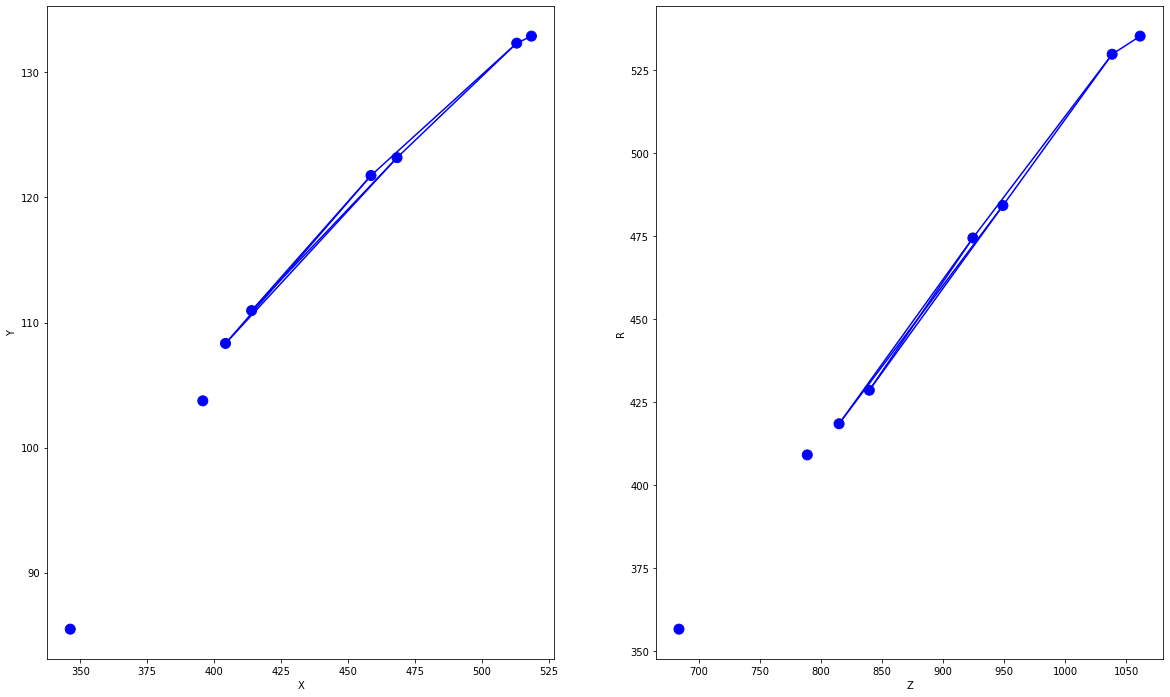

Event= 7    Sector= 8
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ...   615.672974     19.0     0.0
1         3      1.0        6.0  ...   683.776917     10.0     1.0
2         5      2.0        6.0  ...   788.799988    -99.0     1.0
3         7      1.0        6.0  ...   814.815979      0.0     1.0
4         8      1.0        6.0  ...   948.965759     -4.0     1.0
5        10      1.0        6.0  ...  1038.379761     -4.0     1.0
6        11      2.0        6.0  ...  1061.295044    -99.0     1.0

[7 rows x 8 columns]
Event= 7    Sector= 8


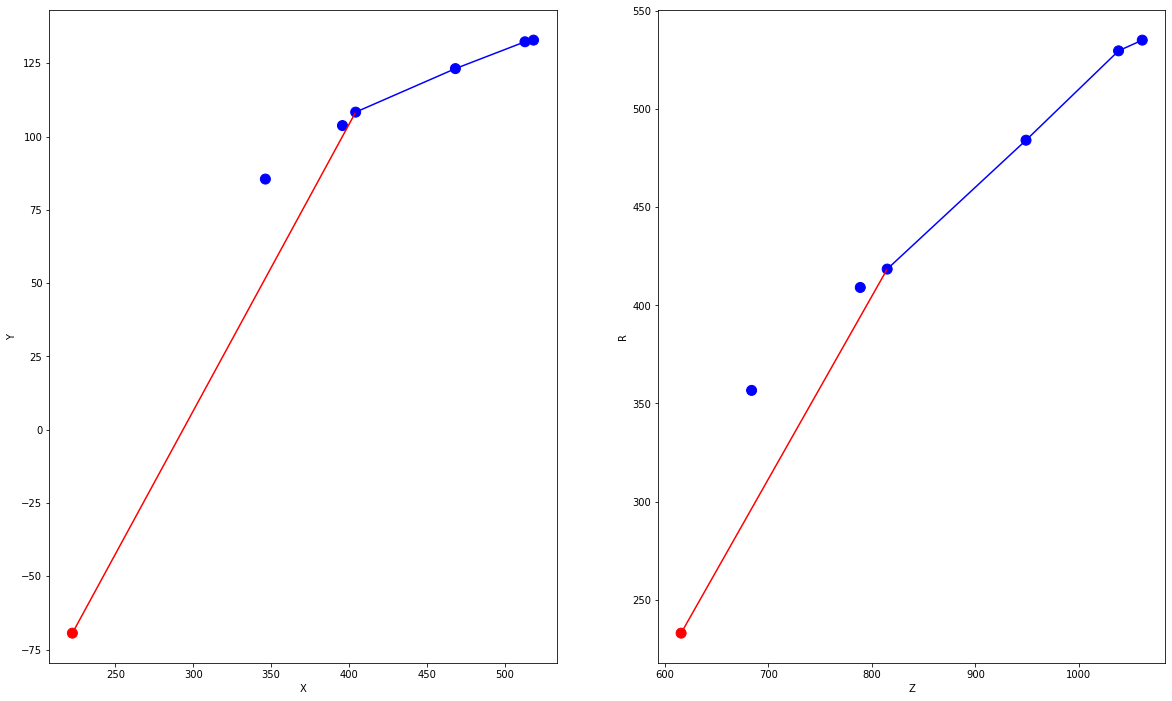

Event= 7    Sector= 9
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        3.0  ...  586.419128     29.0     0.0

[1 rows x 8 columns]
Event= 7    Sector= 10
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ...  615.709106    -32.0     0.0
1         2      1.0        4.0  ...  586.508423     20.0     0.0
2         7      1.0        4.0  ...  839.806213      0.0     0.0
3         8      1.0        4.0  ...  923.832825      4.0     0.0

[4 rows x 8 columns]
Event= 7    Sector= 10


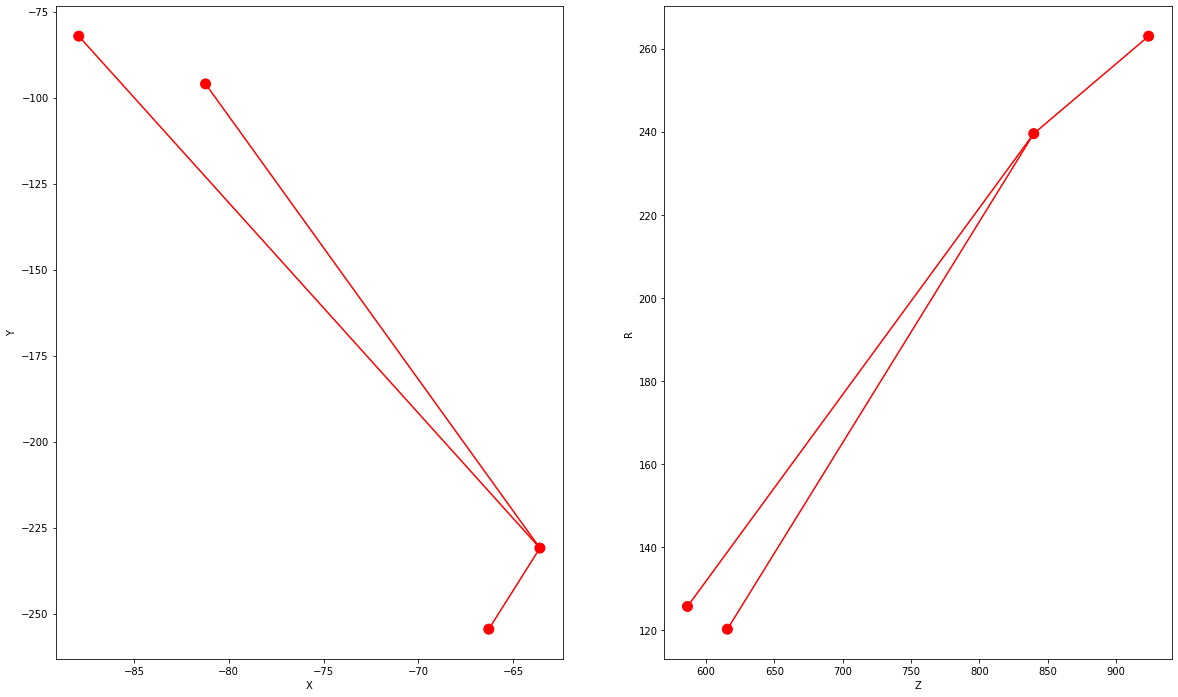

Event= 7    Sector= 11
df_hits = 
    vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0          2      1.0        5.0  ...   615.737793     -2.0     0.0
1          2      1.0        5.0  ...   615.741394    -10.0     0.0
2          2      1.0        5.0  ...   615.741760    -32.0     0.0
3          7      1.0        5.0  ...   815.219299      0.0     0.0
4          7      1.0        5.0  ...   839.806213      0.0     0.0
5          8      1.0        5.0  ...   948.703430      4.0     0.0
6          8      1.0        5.0  ...   923.832825      4.0     0.0
7          9      2.0        5.0  ...   968.900024    -99.0     0.0
8         10      1.0        5.0  ...  1038.439331     16.0     0.0
9         11      2.0        5.0  ...  1059.395020    -99.0     0.0
10        11      2.0        5.0  ...  1059.395020    -99.0     0.0

[11 rows x 8 columns]
Event= 7    Sector= 11


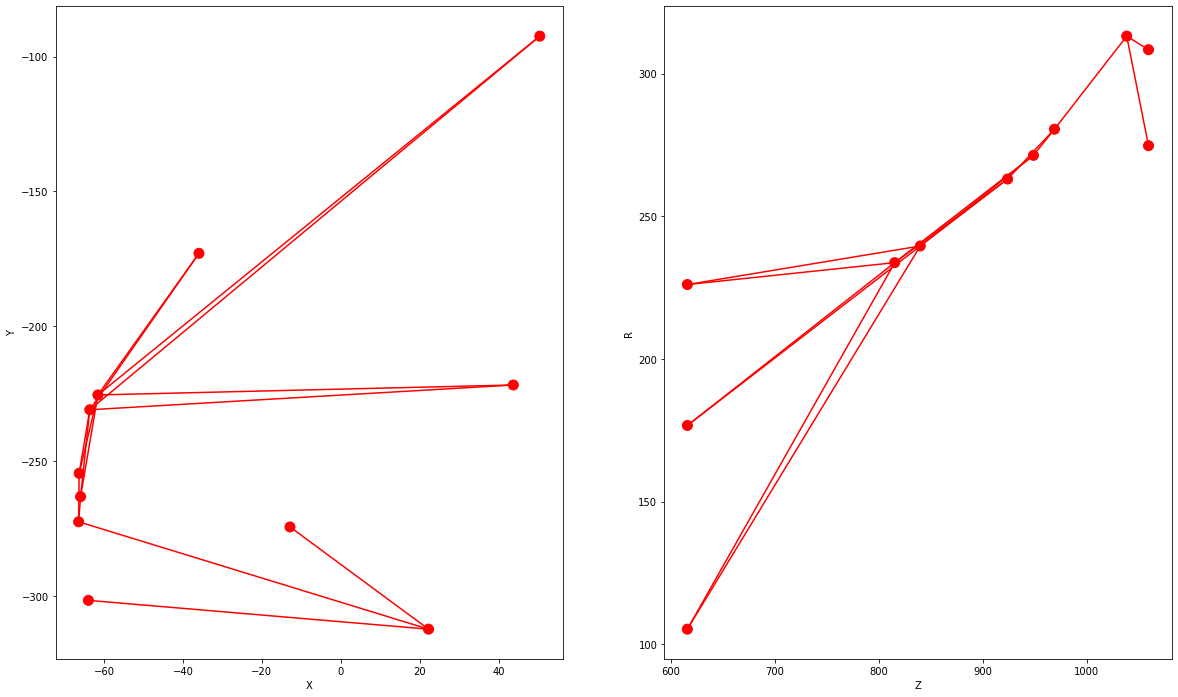

Event= 7    Sector= 12
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ...  615.780151      0.0     0.0
1         2      1.0        6.0  ...  615.788879     27.0     0.0

[2 rows x 8 columns]
Event= 8    Sector= 1
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         3      1.0        2.0  ... -684.396118    -16.0     0.0

[1 rows x 8 columns]
Event= 8    Sector= 2
df_hits = 
   vh_layer  vh_type  vh_sector  ...   vh_sim_z  vh_bend  isMuon
0         4      2.0        3.0  ... -694.93457    -99.0     0.0

[1 rows x 8 columns]
Event= 8    Sector= 3
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         1      3.0        4.0  ... -567.971252      2.0     0.0

[1 rows x 8 columns]
Event= 8    Sector= 4
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ... -586.335205    -15.0     0.0
1         2      1.0  

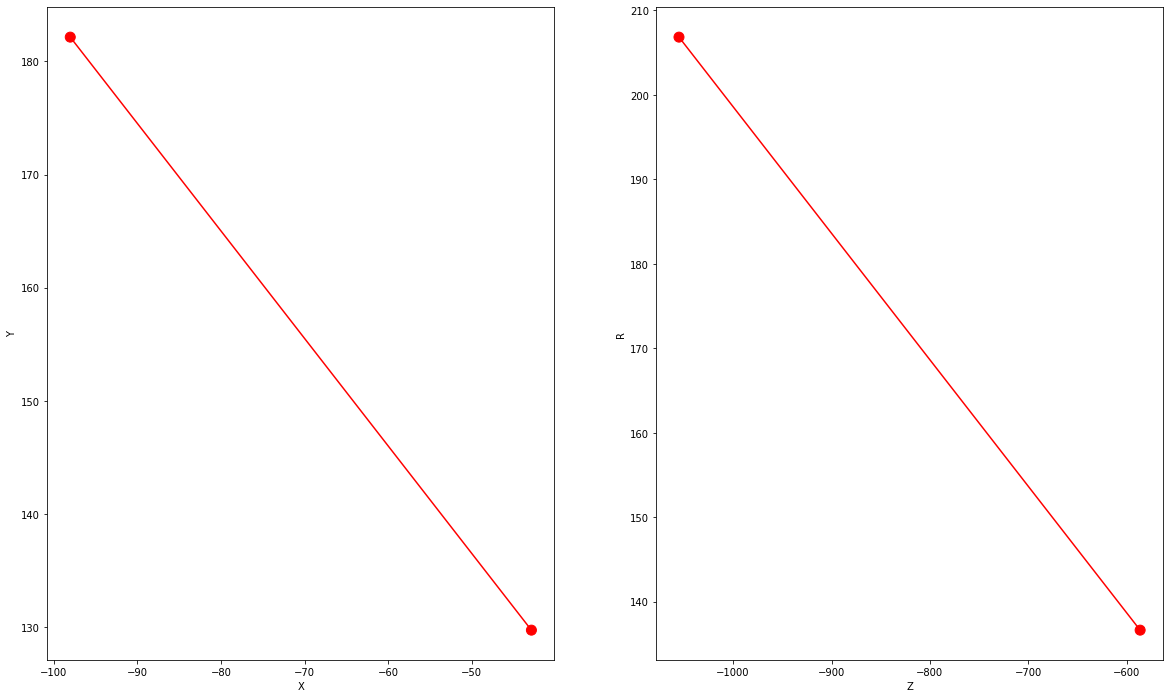

Event= 8    Sector= 6
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         7      1.0        3.0  ...  -839.543518      3.0     0.0
1         8      1.0        3.0  ...  -924.269165    -15.0     0.0
2         9      2.0        3.0  ...  -975.200012    -99.0     0.0
3        11      2.0        3.0  ... -1054.994995    -99.0     0.0

[4 rows x 8 columns]
Event= 8    Sector= 6


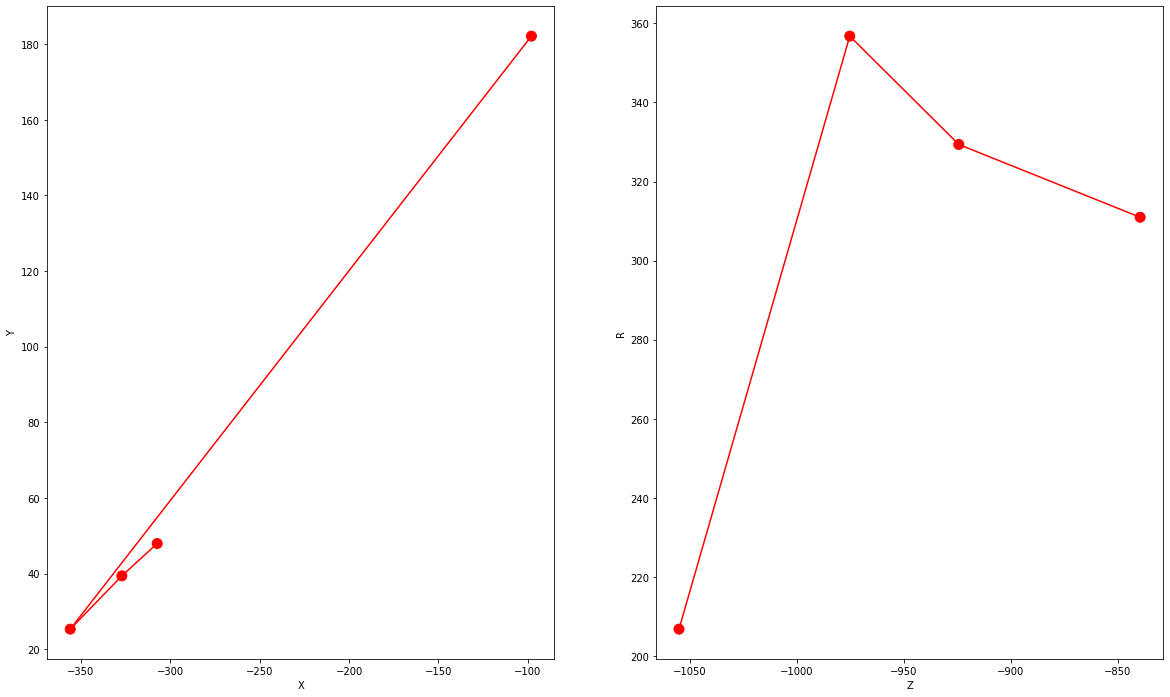

Event= 8    Sector= 7
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ... -615.778015     14.0     0.0
1         2      1.0        4.0  ... -586.420105    -20.0     0.0

[2 rows x 8 columns]
Event= 8    Sector= 8
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        5.0  ...  -586.420105    -20.0     0.0
1         2      1.0        5.0  ...  -615.601440      4.0     0.0
2         7      1.0        5.0  ...  -814.945984      9.0     0.0
3         8      1.0        5.0  ...  -949.113281      0.0     0.0
4         9      2.0        5.0  ...  -968.900024    -99.0     0.0
5         9      2.0        5.0  ...  -964.500000    -99.0     0.0
6        10      1.0        5.0  ... -1038.097900      0.0     0.0
7        11      2.0        5.0  ... -1065.694946    -99.0     0.0

[8 rows x 8 columns]
Event= 8    Sector= 8


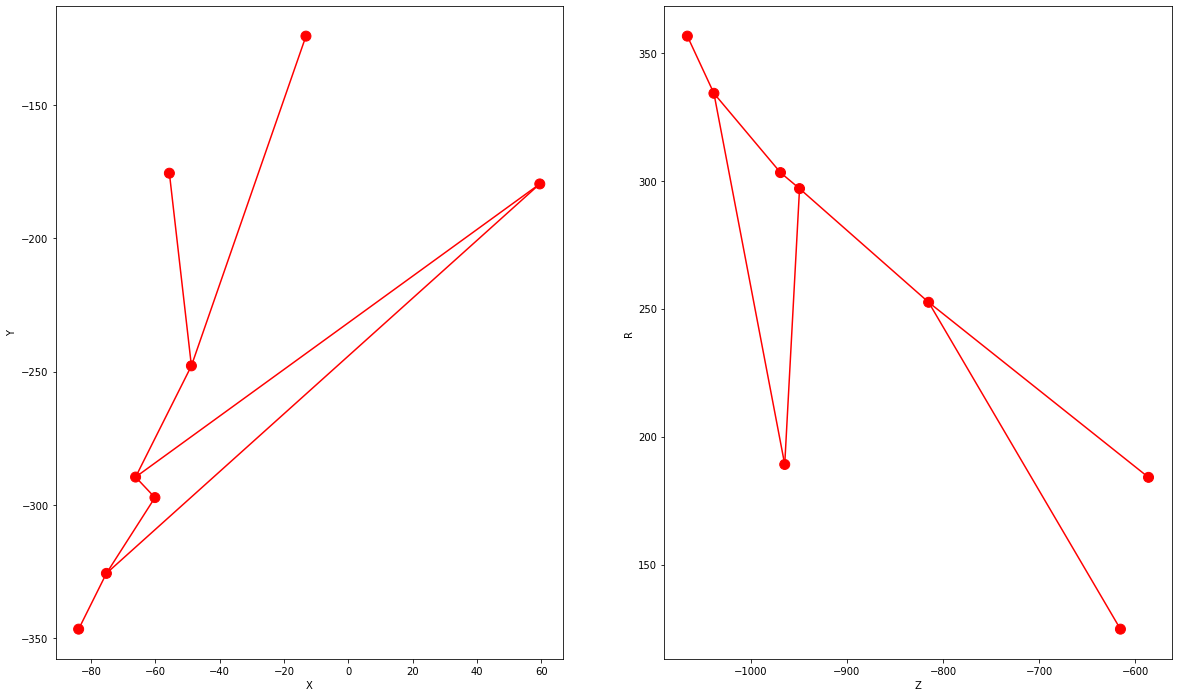

Event= 8    Sector= 9
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ... -615.626587     28.0     0.0
1         2      1.0        6.0  ... -586.451477     17.0     0.0
2         2      1.0        6.0  ... -586.425232     -6.0     0.0

[3 rows x 8 columns]
Event= 8    Sector= 10
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ...  586.314819     14.0     0.0

[1 rows x 8 columns]
Event= 8    Sector= 11
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        2.0  ...  586.427795    -22.0     0.0
1         9      2.0        2.0  ...  964.500000    -99.0     0.0

[2 rows x 8 columns]
Event= 8    Sector= 11


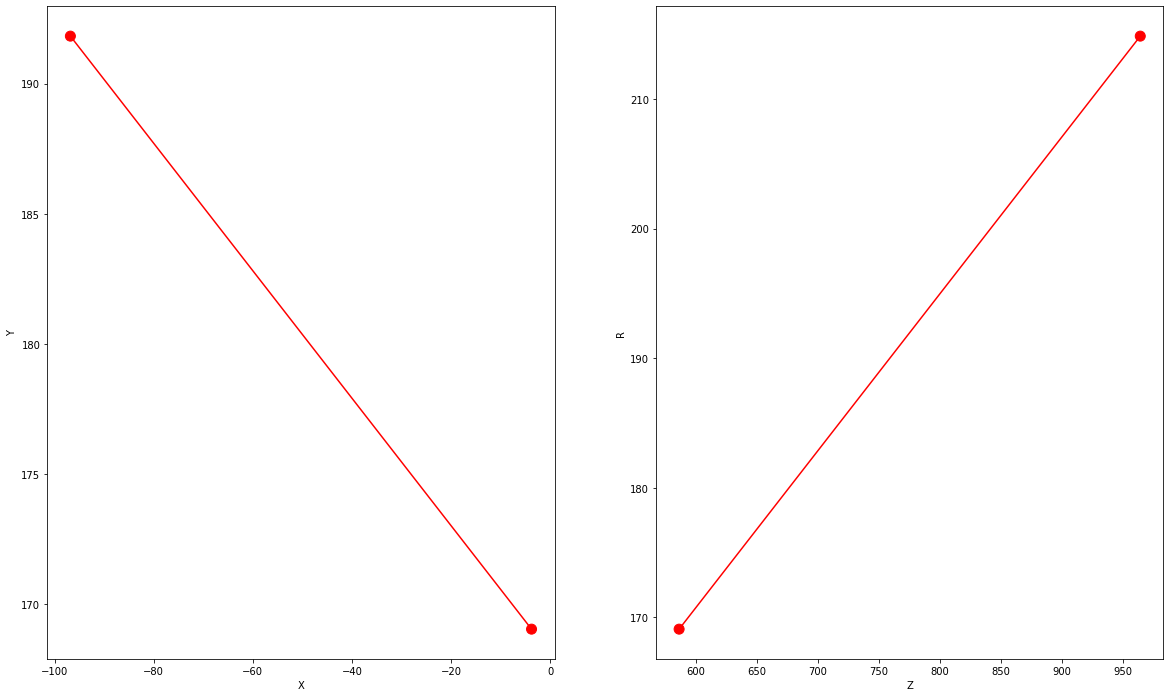

Event= 8    Sector= 12
df_hits = 
    vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0          0      4.0        6.0  ...   539.349976    -11.0     1.0
1          2      1.0        6.0  ...   615.761475     -3.0     1.0
2          2      1.0        6.0  ...   586.314819     14.0     0.0
3          6      3.0        6.0  ...   796.001221      0.0     1.0
4          6      3.0        6.0  ...   793.598755     -1.0     1.0
5          7      1.0        6.0  ...   839.880554     -3.0     1.0
6          7      1.0        6.0  ...   814.977112      0.0     1.0
7          8      1.0        6.0  ...   924.008606      0.0     1.0
8          9      2.0        6.0  ...   964.500000    -99.0     1.0
9         10      1.0        6.0  ...  1013.789246     -2.0     1.0
10        11      2.0        6.0  ...  1054.994995    -99.0     1.0

[11 rows x 8 columns]
Event= 8    Sector= 12


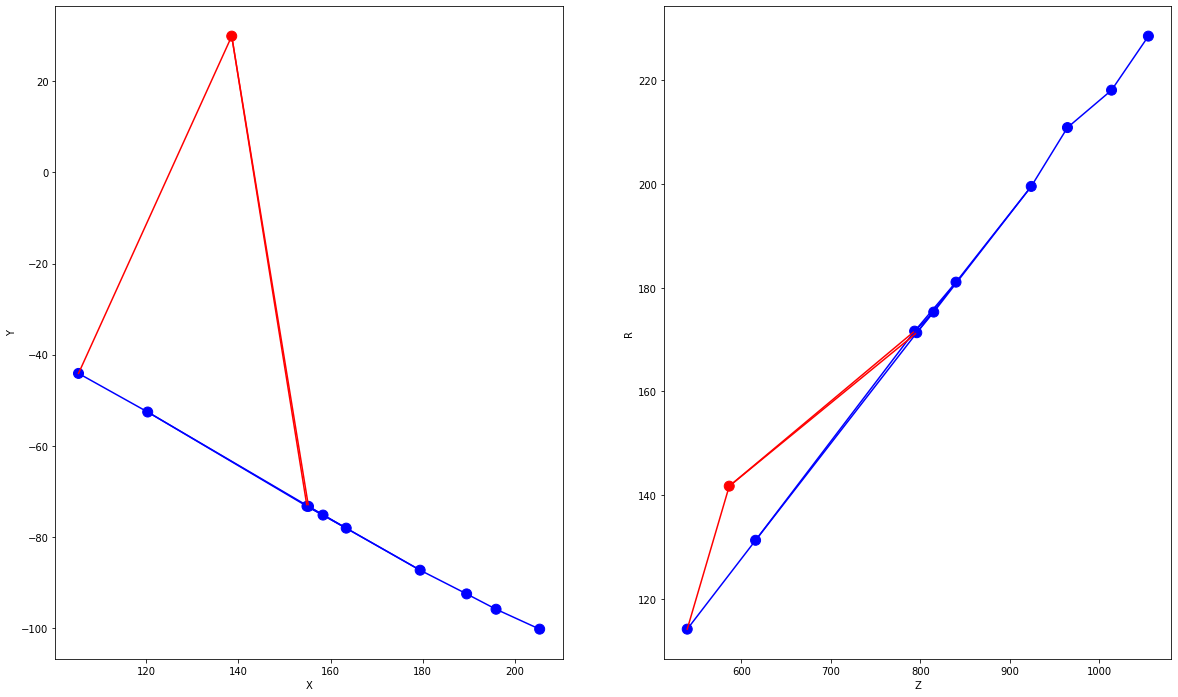

Event= 9    Sector= 1
df_hits = 
   vh_layer  vh_type  vh_sector  ...   vh_sim_z  vh_bend  isMuon
0         4      2.0        2.0  ... -694.93457    -99.0     0.0
1         4      2.0        2.0  ... -694.93457    -99.0     0.0

[2 rows x 8 columns]
Event= 9    Sector= 2
df_hits = 
   vh_layer  vh_type  vh_sector  ...   vh_sim_z  vh_bend  isMuon
0         4      2.0        3.0  ... -694.93457    -99.0     0.0

[1 rows x 8 columns]
Event= 9    Sector= 3
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         5      2.0        4.0  ... -788.799988    -99.0     0.0

[1 rows x 8 columns]
Event= 9    Sector= 4
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         5      2.0        5.0  ... -788.799988    -99.0     0.0

[1 rows x 8 columns]
Event= 9    Sector= 5
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        2.0  ... -615.656006    -32.0     0.0
1         2      1.0      

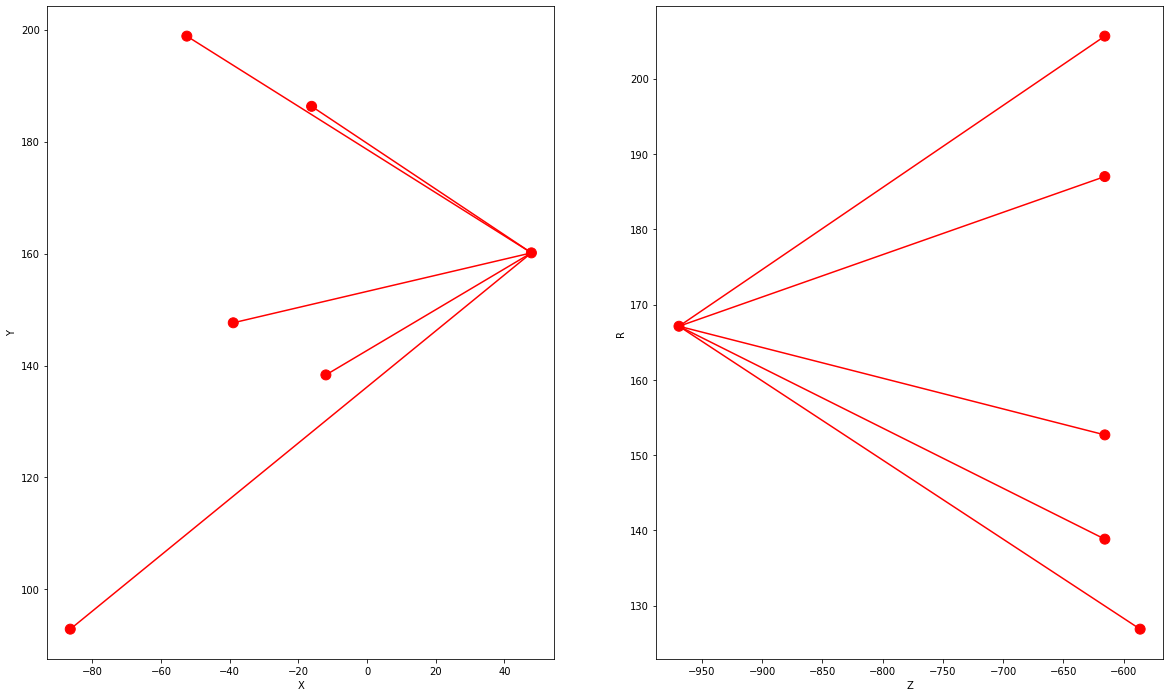

Event= 9    Sector= 6
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         0      4.0        3.0  ...  -539.349976     27.0     0.0
1         1      3.0        3.0  ...  -567.971252     -2.0     0.0
2         2      1.0        3.0  ...  -586.408569    -19.0     0.0
3         2      1.0        3.0  ...  -615.685730    -25.0     0.0
4         2      1.0        3.0  ...  -586.378723    -16.0     0.0
5         7      1.0        3.0  ...  -814.916504      6.0     0.0
6         7      1.0        3.0  ...  -839.726868     -4.0     0.0
7         9      2.0        3.0  ...  -964.500000    -99.0     0.0
8        10      1.0        3.0  ... -1013.498230      8.0     0.0

[9 rows x 8 columns]
Event= 9    Sector= 6


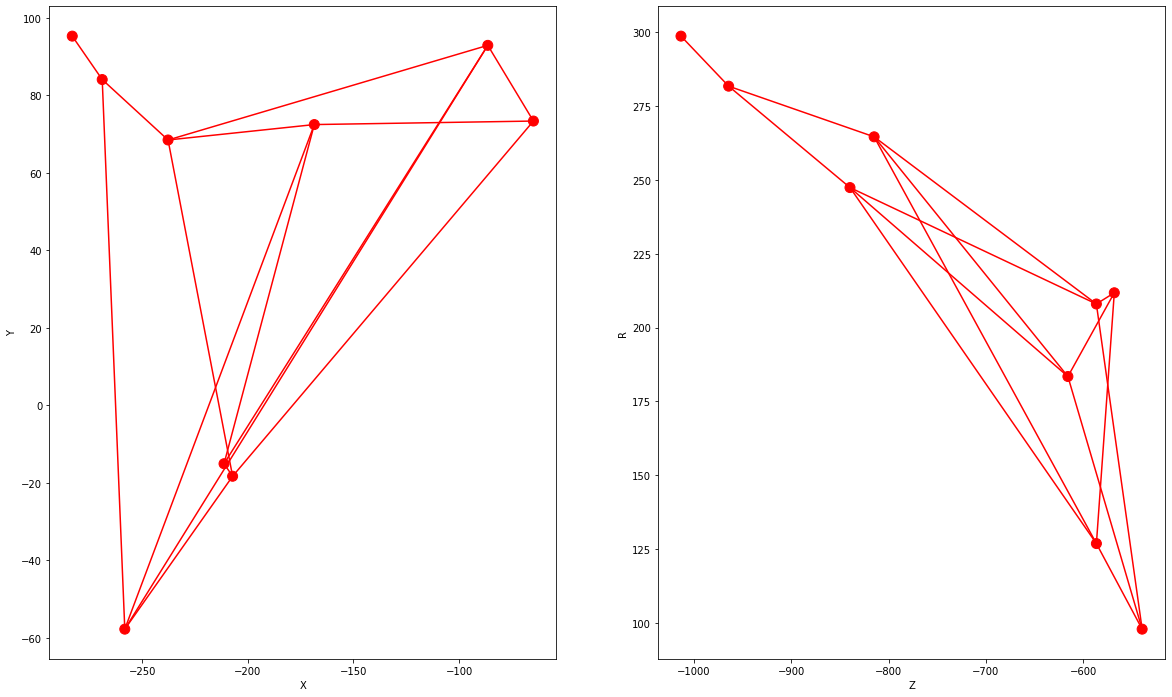

Event= 9    Sector= 7
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ... -586.408569    -19.0     0.0
1         2      1.0        4.0  ... -586.468567      4.0     0.0
2         7      1.0        4.0  ... -814.916504      6.0     0.0

[3 rows x 8 columns]
Event= 9    Sector= 7


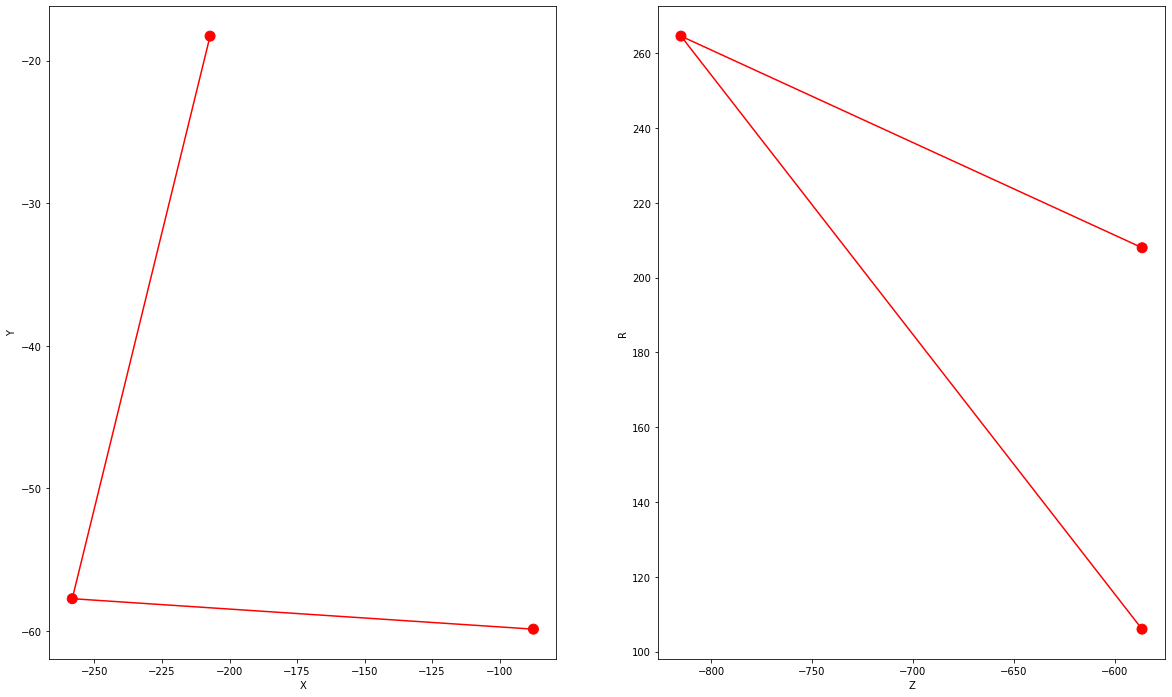

Event= 9    Sector= 8
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        5.0  ...  -615.691406     23.0     0.0
1         2      1.0        5.0  ...  -615.616455    -20.0     0.0
2         2      1.0        5.0  ...  -615.735168      0.0     0.0
3         2      1.0        5.0  ...  -586.445007     -7.0     0.0
4         7      1.0        5.0  ...  -814.948486     -3.0     0.0
5         9      2.0        5.0  ...  -975.200012    -99.0     0.0
6        11      2.0        5.0  ... -1054.994995    -99.0     0.0
7        11      2.0        5.0  ... -1061.295044    -99.0     0.0

[8 rows x 8 columns]
Event= 9    Sector= 8


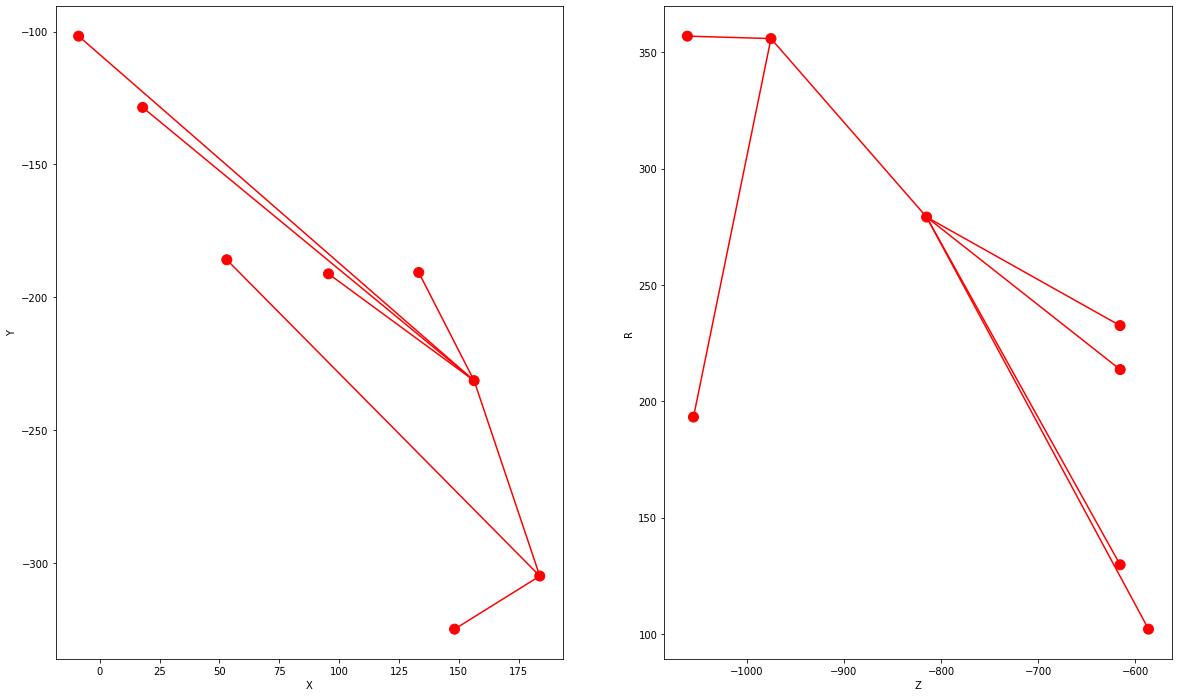

Event= 9    Sector= 9
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         7      1.0        6.0  ... -814.948486     -3.0     0.0

[1 rows x 8 columns]
Event= 9    Sector= 10
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        2.0  ...  586.513855    -32.0     0.0
1         4      2.0        2.0  ...  694.934570    -99.0     0.0

[2 rows x 8 columns]
Event= 9    Sector= 11
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         4      2.0        3.0  ...   694.934570    -99.0     0.0
1        11      2.0        3.0  ...  1065.694946    -99.0     0.0

[2 rows x 8 columns]
Event= 9    Sector= 12
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ...  586.506226    -27.0     0.0

[1 rows x 8 columns]
Event= 9    Sector= 13
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2  

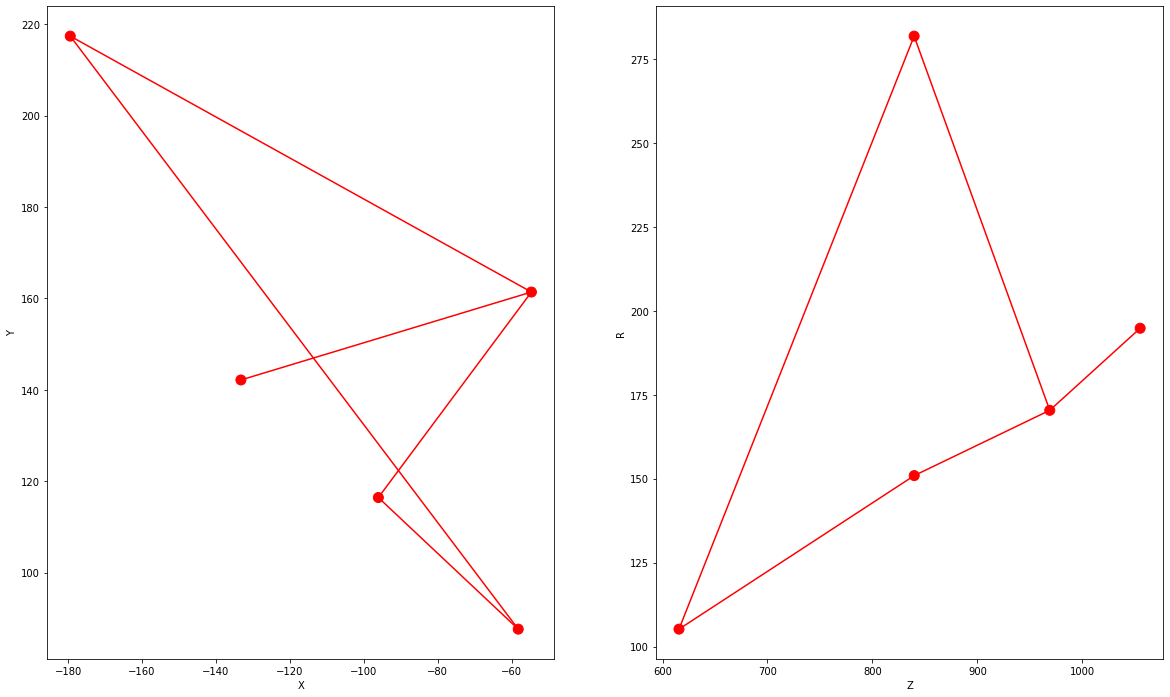

Event= 9    Sector= 14
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         7      1.0        3.0  ...   839.686462    -16.0     0.0
1         7      1.0        3.0  ...   839.768372    -16.0     0.0
2         8      1.0        3.0  ...   948.684387    -18.0     0.0
3        11      2.0        3.0  ...  1054.994995    -99.0     0.0

[4 rows x 8 columns]
Event= 9    Sector= 14


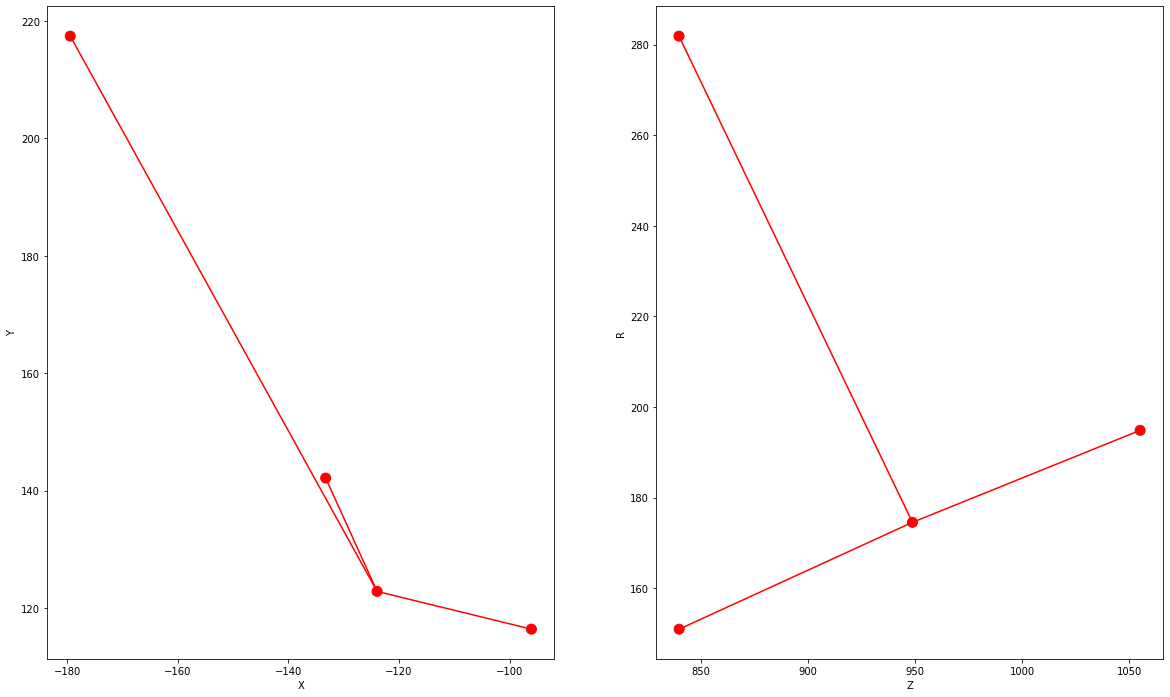

Event= 9    Sector= 15
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         0      4.0        4.0  ...   539.349976      2.0     0.0
1         2      1.0        4.0  ...   586.477966    -28.0     1.0
2         2      1.0        4.0  ...   615.714600     24.0     0.0
3         6      3.0        4.0  ...   796.001221      0.0     1.0
4         8      1.0        4.0  ...   923.946533     10.0     1.0
5         9      2.0        4.0  ...   964.500000    -99.0     1.0
6        11      2.0        4.0  ...  1054.994995    -99.0     1.0

[7 rows x 8 columns]
Event= 9    Sector= 15


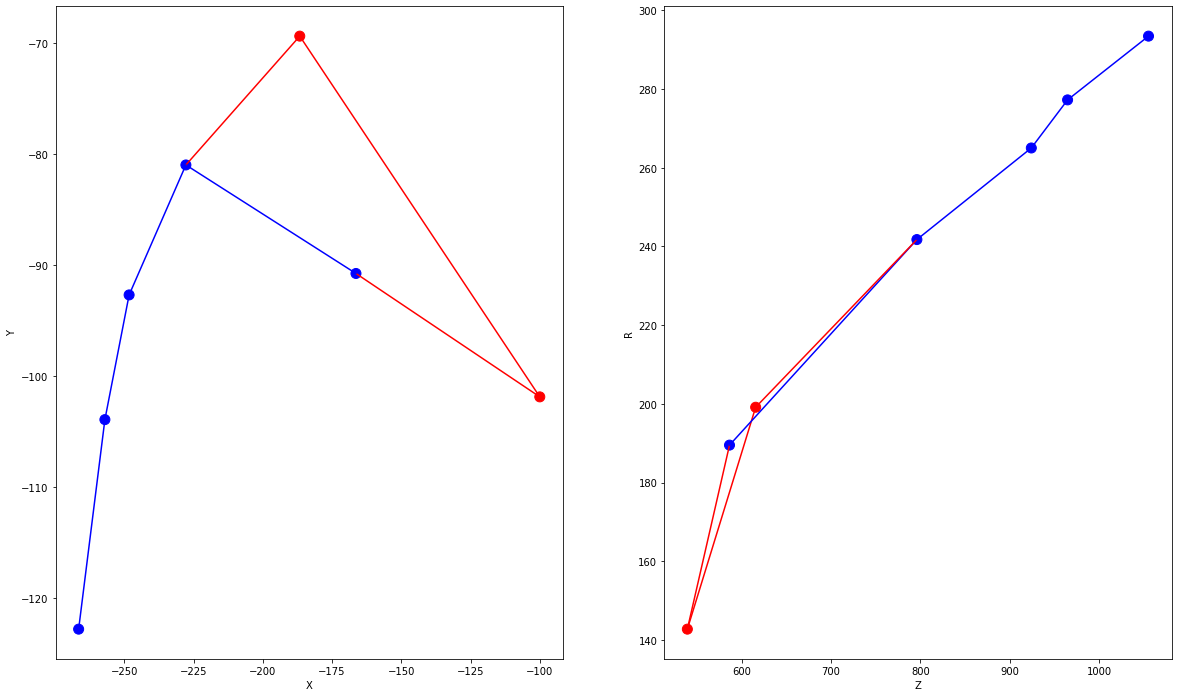

Event= 9    Sector= 16
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        5.0  ...  615.751465     23.0     0.0

[1 rows x 8 columns]
Event= 9    Sector= 17
df_hits = 
   vh_layer  vh_type  vh_sector  ...   vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ...  615.84259    -11.0     0.0

[1 rows x 8 columns]
Event= 10    Sector= 1
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         4      2.0        3.0  ... -694.934570    -99.0     0.0
1         6      3.0        3.0  ... -793.598755      0.0     0.0

[2 rows x 8 columns]
Event= 10    Sector= 2
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         3      1.0        4.0  ... -684.211548      4.0     0.0
1         4      2.0        4.0  ... -694.934570    -99.0     0.0

[2 rows x 8 columns]
Event= 10    Sector= 3
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1

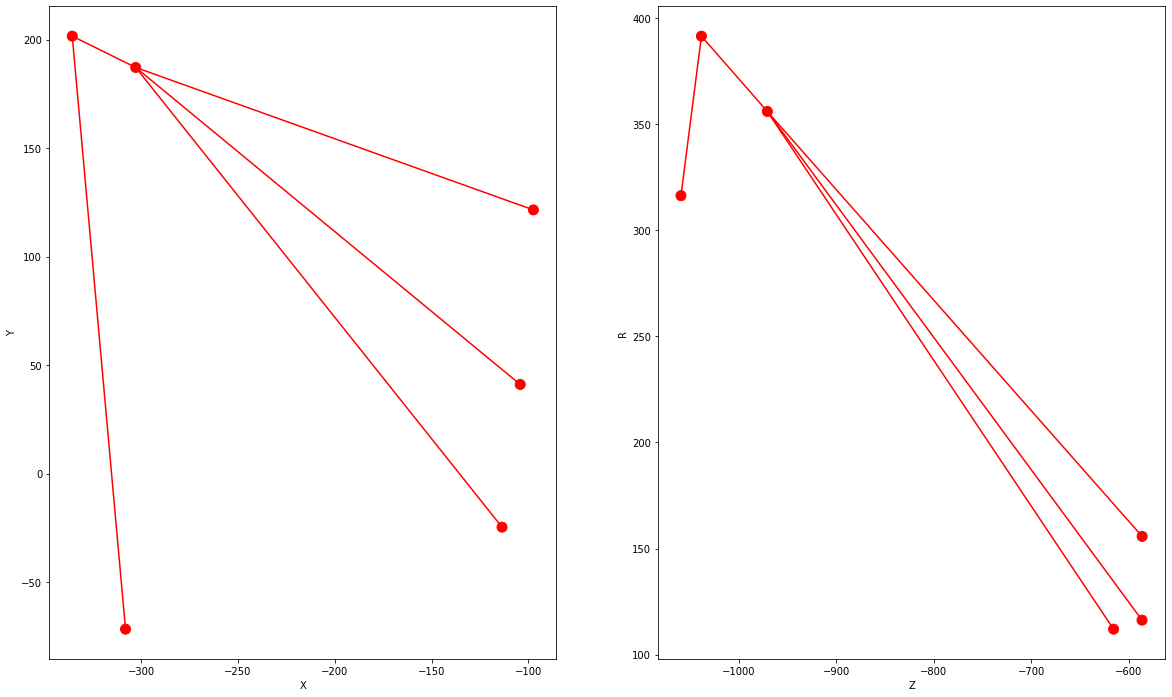

Event= 10    Sector= 5
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ...  -586.480408     26.0     0.0
1        11      2.0        4.0  ... -1059.395020    -99.0     0.0

[2 rows x 8 columns]
Event= 10    Sector= 5


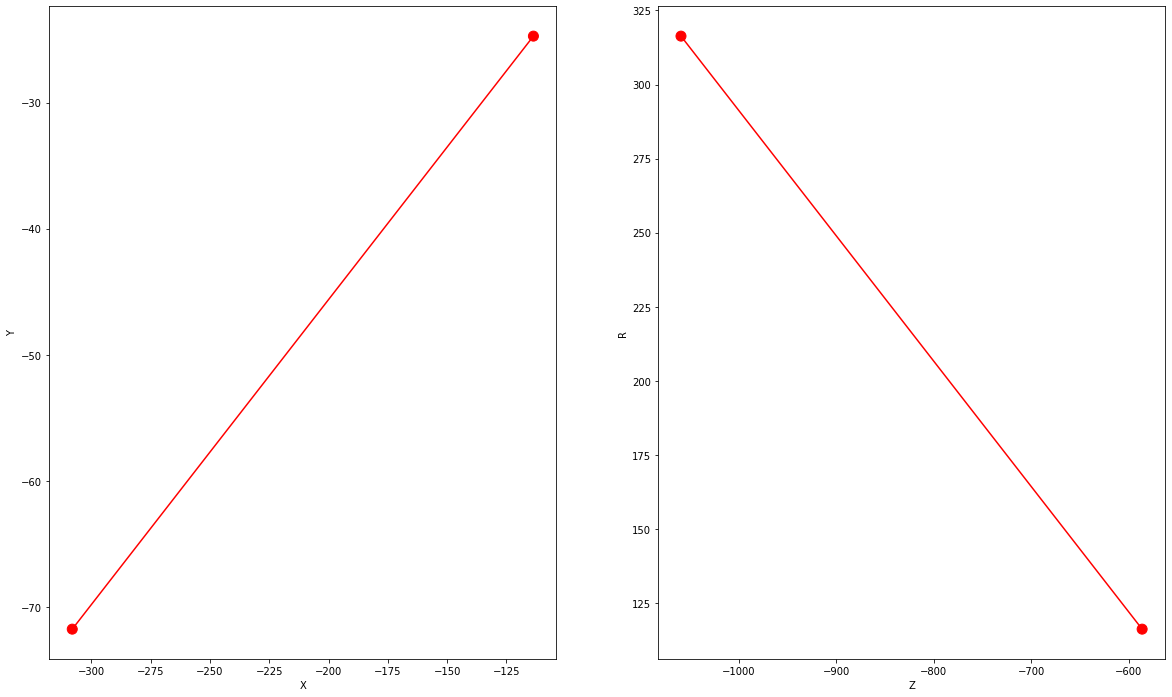

Event= 10    Sector= 6
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         0      4.0        5.0  ... -539.349976    -20.0     0.0
1         2      1.0        5.0  ... -586.400940     28.0     0.0
2         2      1.0        5.0  ... -615.613708      0.0     0.0

[3 rows x 8 columns]
Event= 10    Sector= 6


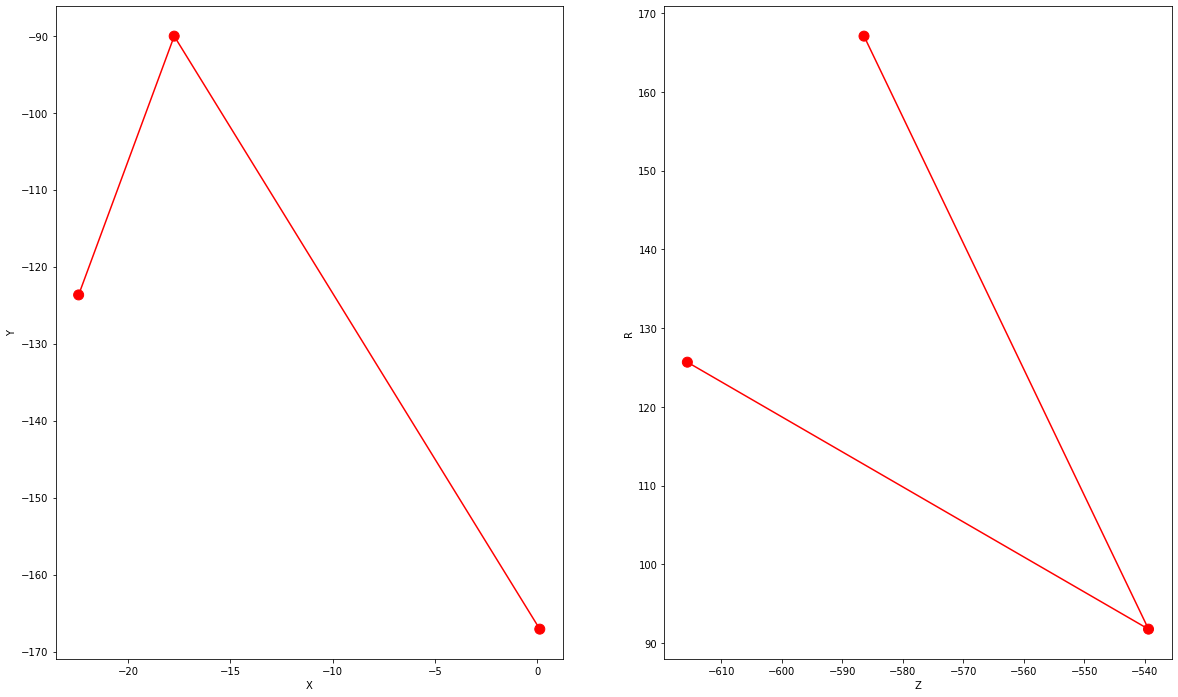

Event= 10    Sector= 7
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         4      2.0        3.0  ...  694.934570    -99.0     0.0
1         7      1.0        3.0  ...  815.296936     20.0     0.0

[2 rows x 8 columns]
Event= 10    Sector= 8
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         4      2.0        4.0  ...  694.934570    -99.0     0.0
1         7      1.0        4.0  ...  839.560669     20.0     0.0
2         7      1.0        4.0  ...  815.296936     20.0     0.0

[3 rows x 8 columns]
Event= 10    Sector= 9
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         0      4.0        1.0  ...  539.349976     23.0     0.0
1         2      1.0        1.0  ...  586.351685     18.0     0.0
2         2      1.0        1.0  ...  586.403015    -29.0     0.0
3         6      3.0        1.0  ...  796.001221      0.0     0.0
4         7      1.0        1.0  ...  839.919312     -3.0     

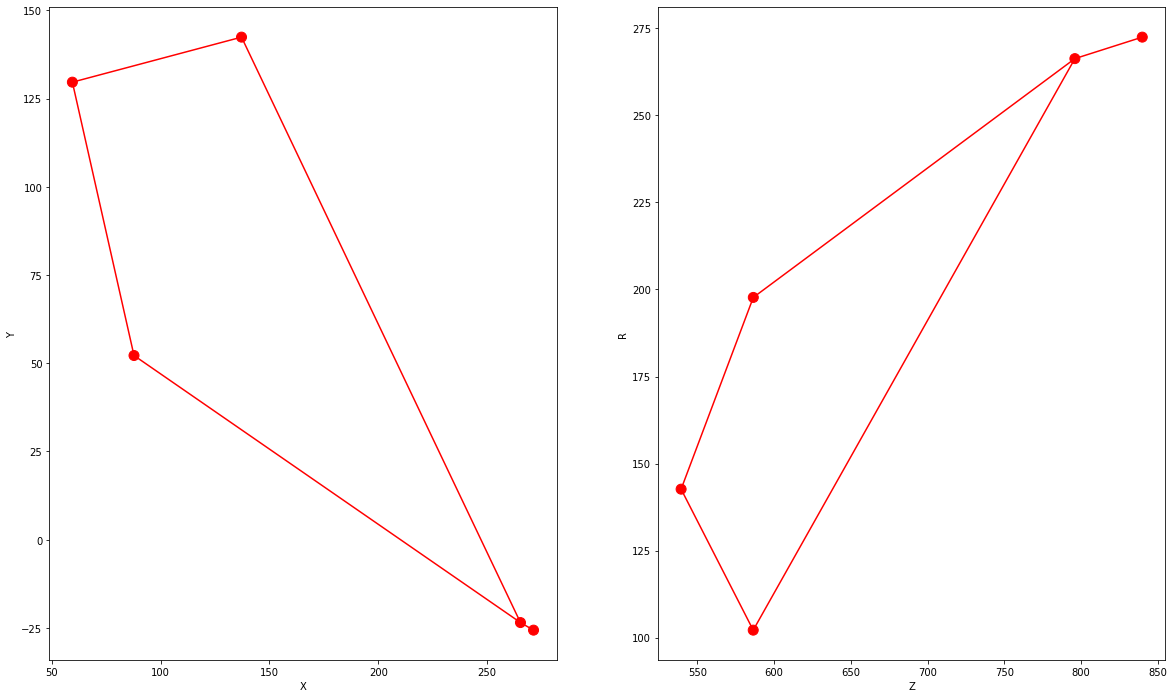

Event= 10    Sector= 10
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         0      4.0        2.0  ...   539.349976     37.0     1.0
1         0      4.0        2.0  ...   539.349976     23.0     0.0
2         1      3.0        2.0  ...   567.971252      3.0     1.0
3         2      1.0        2.0  ...   615.821045     16.0     1.0
4         2      1.0        2.0  ...   586.370056    -15.0     0.0
5         2      1.0        2.0  ...   586.466797     24.0     0.0
6         6      3.0        2.0  ...   796.001221      1.0     1.0
7         9      2.0        2.0  ...   964.500000    -99.0     1.0
8        10      1.0        2.0  ...  1013.901550      0.0     1.0
9        11      2.0        2.0  ...  1054.994995    -99.0     1.0

[10 rows x 8 columns]
Event= 10    Sector= 10


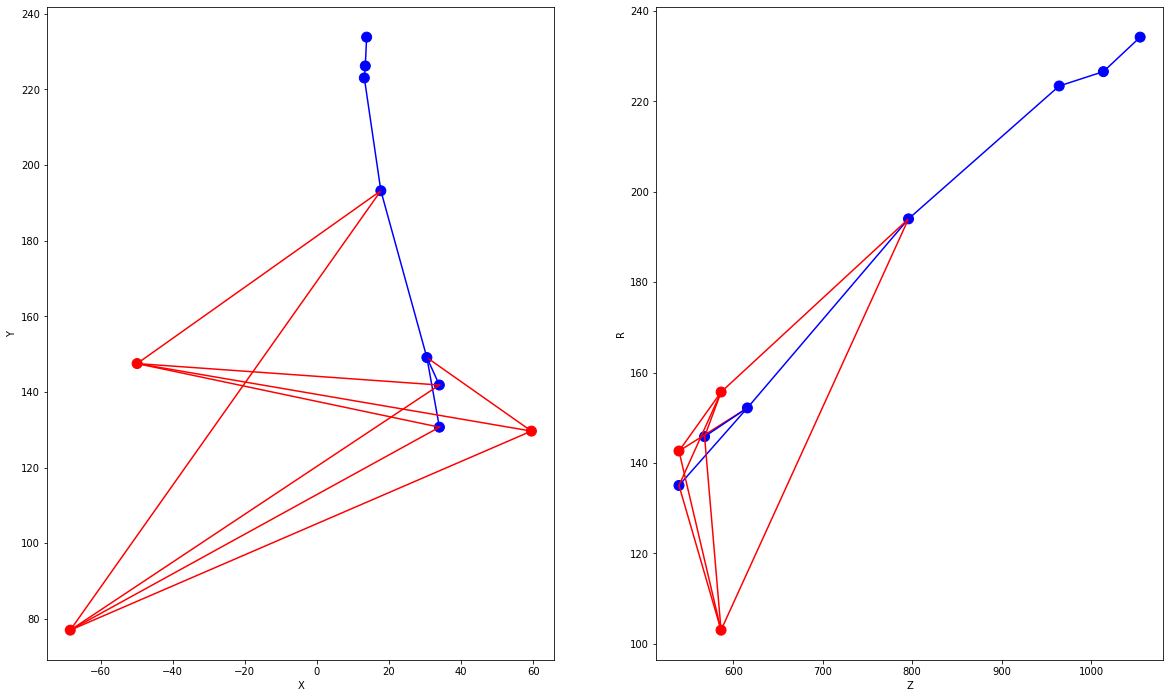

Event= 10    Sector= 11
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        3.0  ...  586.370056    -15.0     0.0

[1 rows x 8 columns]
Event= 10    Sector= 12
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ...   615.795349     -8.0     0.0
1         6      3.0        6.0  ...   796.001221      0.0     0.0
2         7      1.0        6.0  ...   815.033142      0.0     0.0
3         7      1.0        6.0  ...   839.919312     -3.0     0.0
4         8      1.0        6.0  ...   948.623169     -3.0     0.0
5         9      2.0        6.0  ...   968.900024    -99.0     0.0
6         9      2.0        6.0  ...   968.900024    -99.0     0.0
7        10      1.0        6.0  ...  1038.345459     -3.0     0.0
8        11      2.0        6.0  ...  1061.295044    -99.0     0.0
9        11      2.0        6.0  ...  1061.295044    -99.0     0.0

[10 rows x 8 columns]
Event= 10    Sec

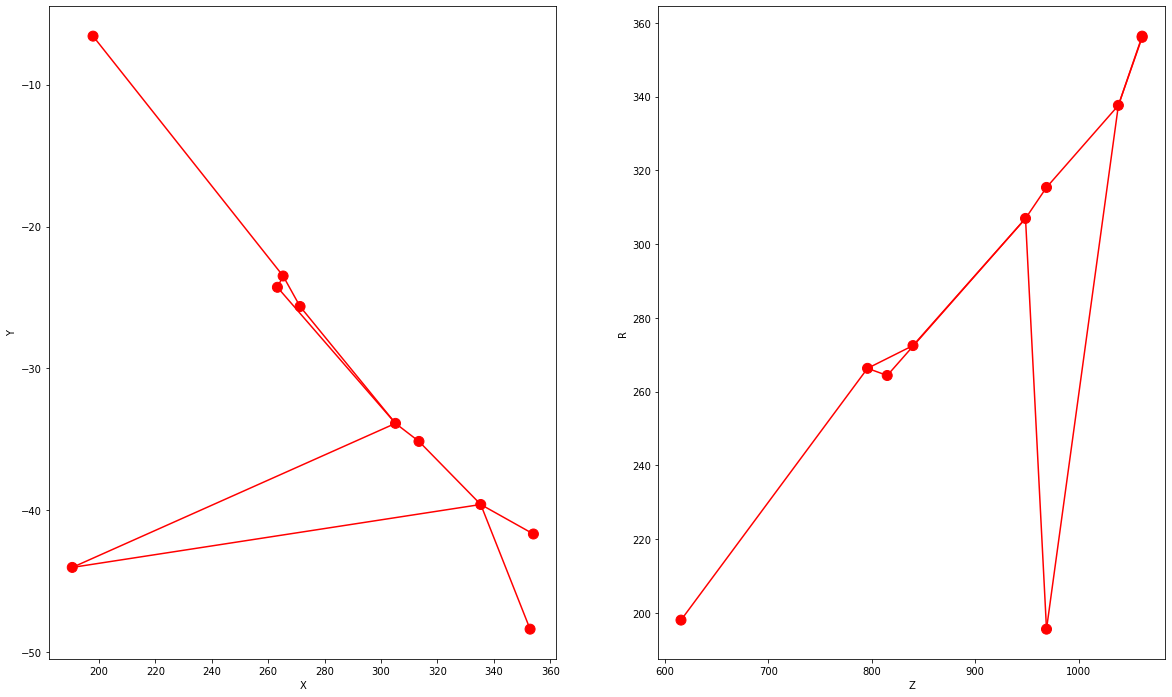

Event= 11    Sector= 1
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         5      2.0        3.0  ... -788.799988    -99.0     0.0

[1 rows x 8 columns]
Event= 11    Sector= 2
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ... -586.248596     11.0     0.0

[1 rows x 8 columns]
Event= 11    Sector= 3
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        2.0  ... -586.409729     20.0     0.0

[1 rows x 8 columns]
Event= 11    Sector= 4
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         1      3.0        3.0  ... -567.971252     -3.0     0.0
1         2      1.0        3.0  ... -615.742188      9.0     0.0
2         2      1.0        3.0  ... -586.414429    -16.0     0.0
3         2      1.0        3.0  ... -615.738708     -5.0     0.0

[4 rows x 8 columns]
Event= 11    Sector= 4


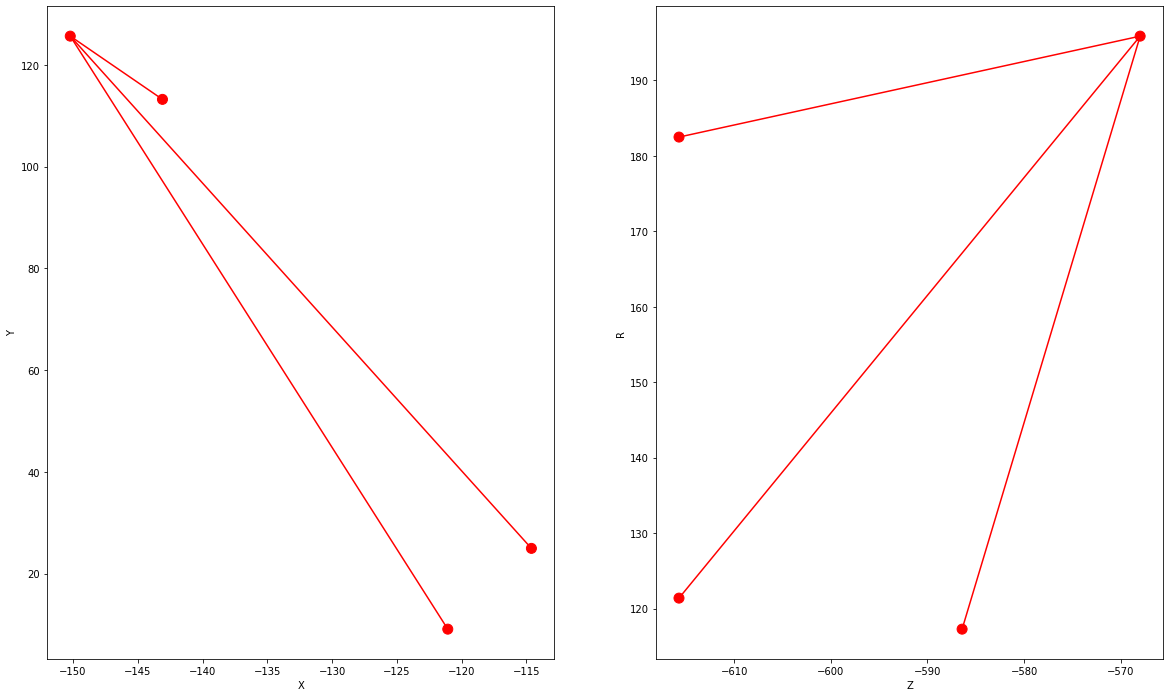

Event= 11    Sector= 5
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ... -615.669922      4.0     0.0
1         2      1.0        6.0  ... -586.466248      9.0     0.0

[2 rows x 8 columns]
Event= 11    Sector= 6
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        1.0  ...   586.471130    -10.0     0.0
1         2      1.0        1.0  ...   586.494080     28.0     0.0
2         7      1.0        1.0  ...   814.978943     -4.0     0.0
3         8      1.0        1.0  ...   948.731567     -4.0     0.0
4         9      2.0        1.0  ...   968.900024    -99.0     0.0
5        10      1.0        1.0  ...  1038.594482     -7.0     0.0
6        11      2.0        1.0  ...  1059.395020    -99.0     0.0

[7 rows x 8 columns]
Event= 11    Sector= 6


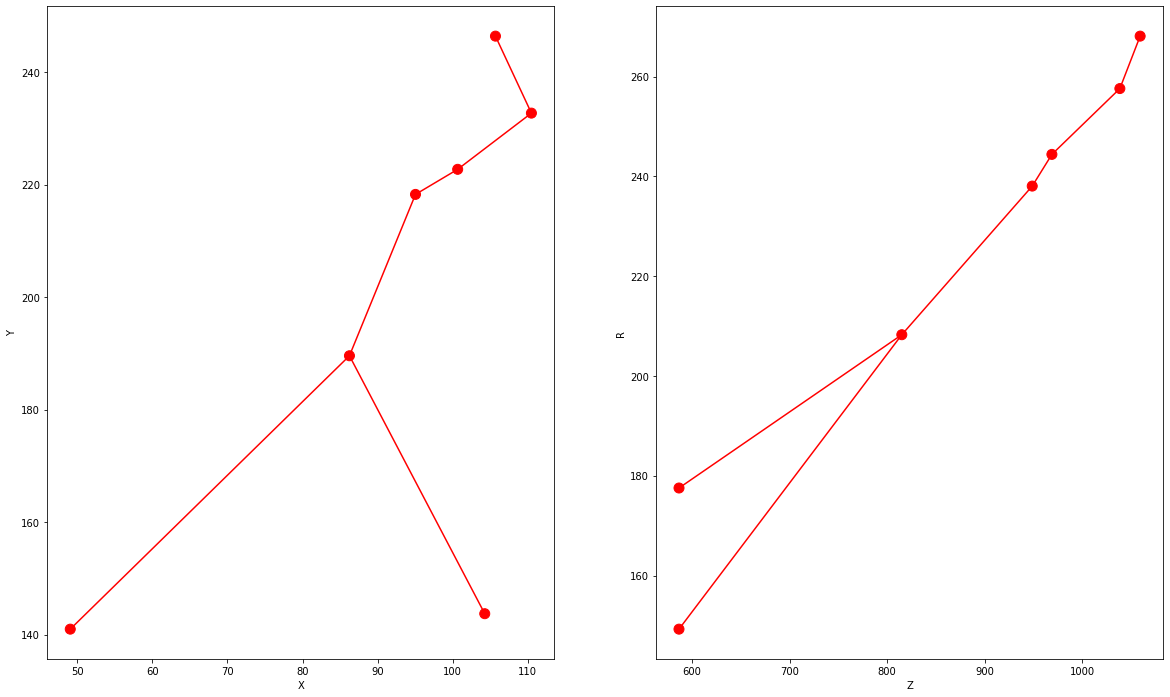

Event= 11    Sector= 7
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         0      4.0        2.0  ...   539.349976    -24.0     0.0
1         2      1.0        2.0  ...   586.471130    -10.0     0.0
2         7      1.0        2.0  ...   814.978943     -4.0     0.0
3         8      1.0        2.0  ...   948.731567     -4.0     0.0
4         9      2.0        2.0  ...   968.900024    -99.0     0.0
5        10      1.0        2.0  ...  1038.594482     -7.0     0.0
6        11      2.0        2.0  ...  1059.395020    -99.0     0.0

[7 rows x 8 columns]
Event= 11    Sector= 7


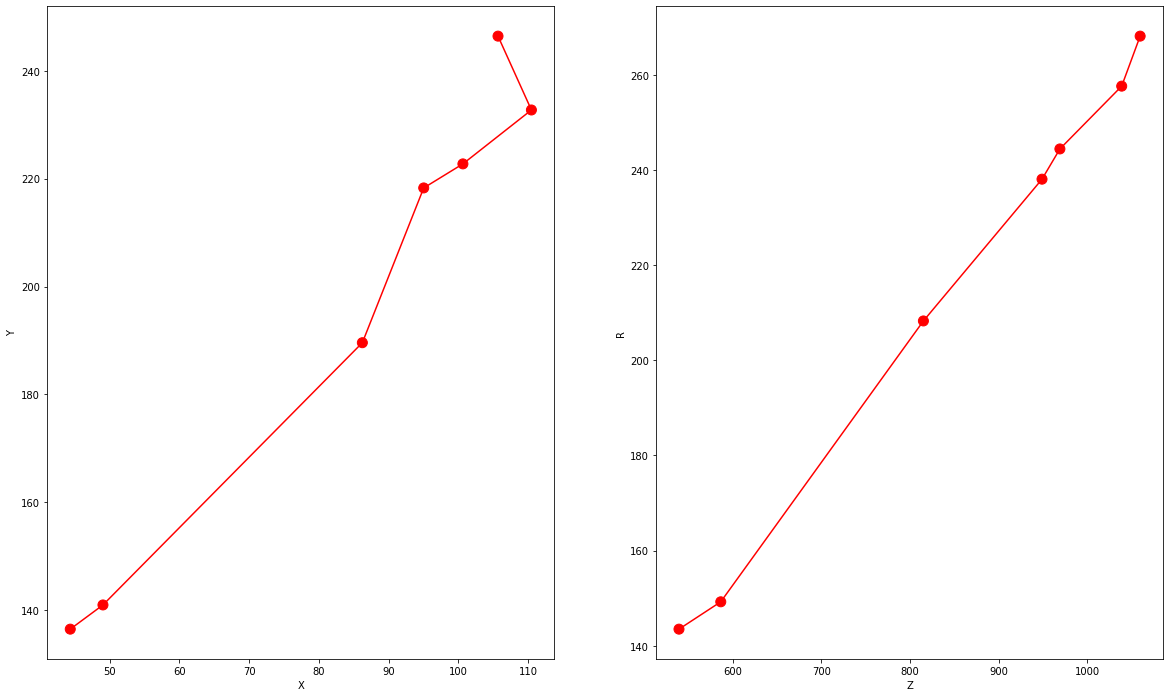

Event= 11    Sector= 8
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         0      4.0        3.0  ...   539.349976     16.0     1.0
1         2      1.0        3.0  ...   615.635681      8.0     1.0
2         6      3.0        3.0  ...   793.598755      0.0     1.0
3         7      1.0        3.0  ...   815.025391      3.0     1.0
4         8      1.0        3.0  ...   948.715576      4.0     1.0
5         8      1.0        3.0  ...   948.715515      4.0     1.0
6         9      2.0        3.0  ...   968.900024    -99.0     1.0
7        10      1.0        3.0  ...  1038.657227      3.0     1.0
8        11      2.0        3.0  ...  1059.395020    -99.0     1.0

[9 rows x 8 columns]
Event= 11    Sector= 8


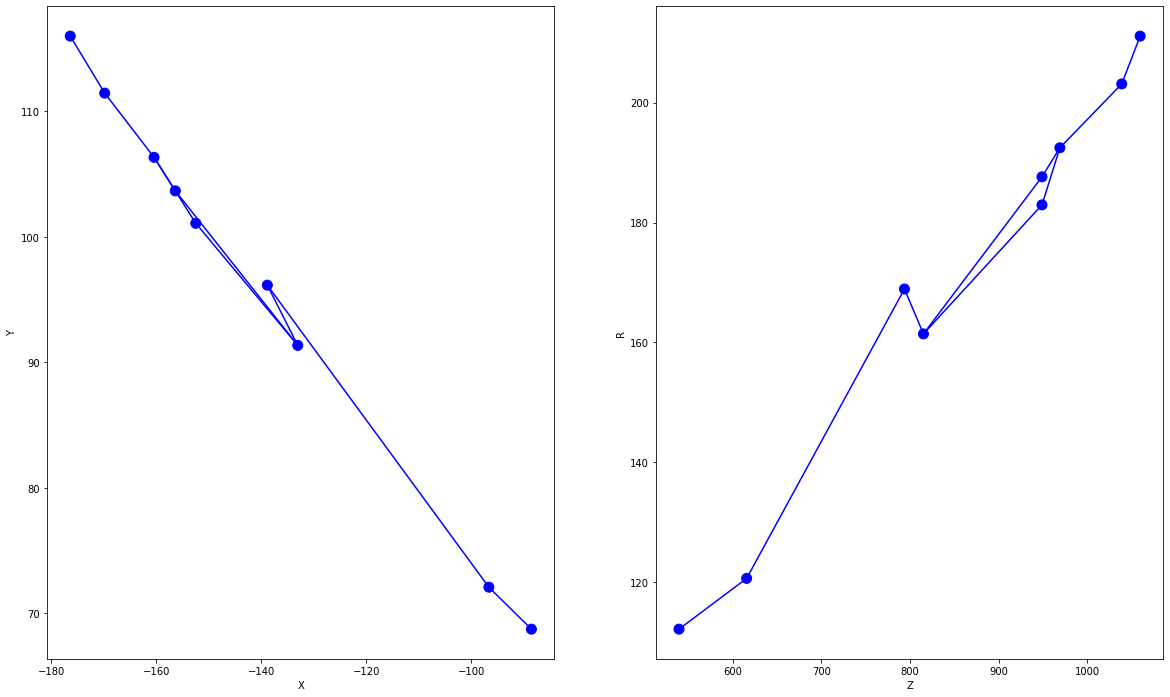

Event= 11    Sector= 9
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ...  615.737732     15.0     0.0
1         6      3.0        4.0  ...  793.598755     -1.0     0.0

[2 rows x 8 columns]
Event= 11    Sector= 9


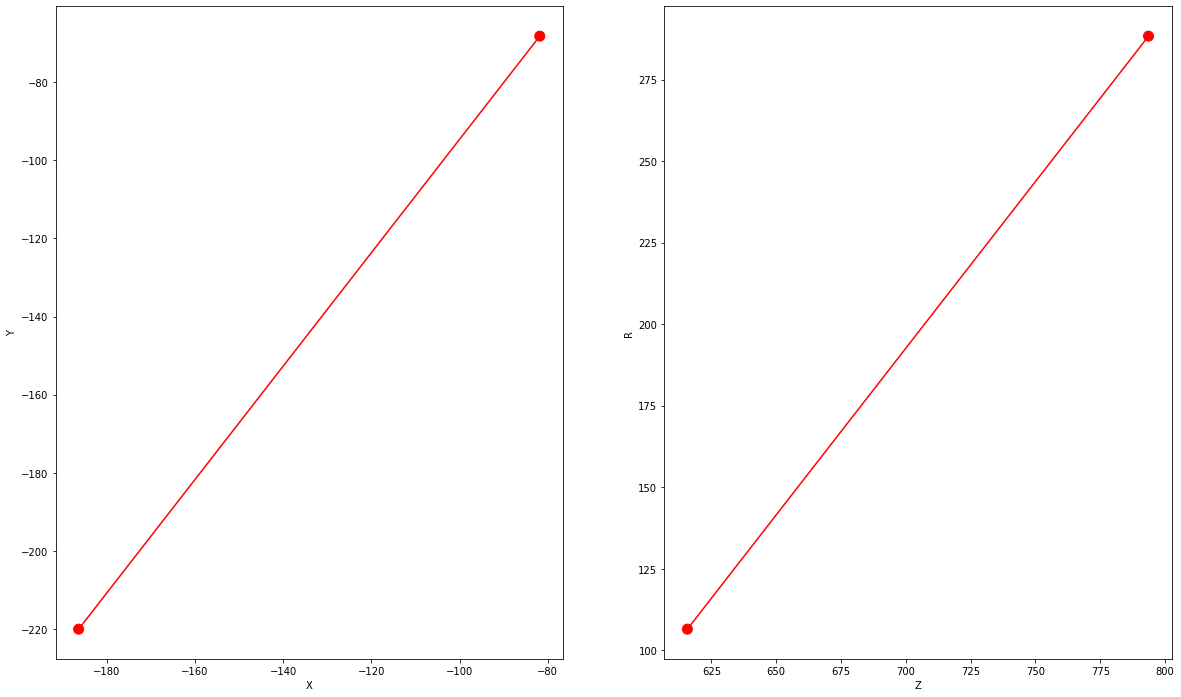

Event= 11    Sector= 10
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        5.0  ...  586.333191     16.0     0.0
1         2      1.0        5.0  ...  615.796936    -22.0     0.0
2         7      1.0        5.0  ...  814.998047    -30.0     0.0

[3 rows x 8 columns]
Event= 11    Sector= 10


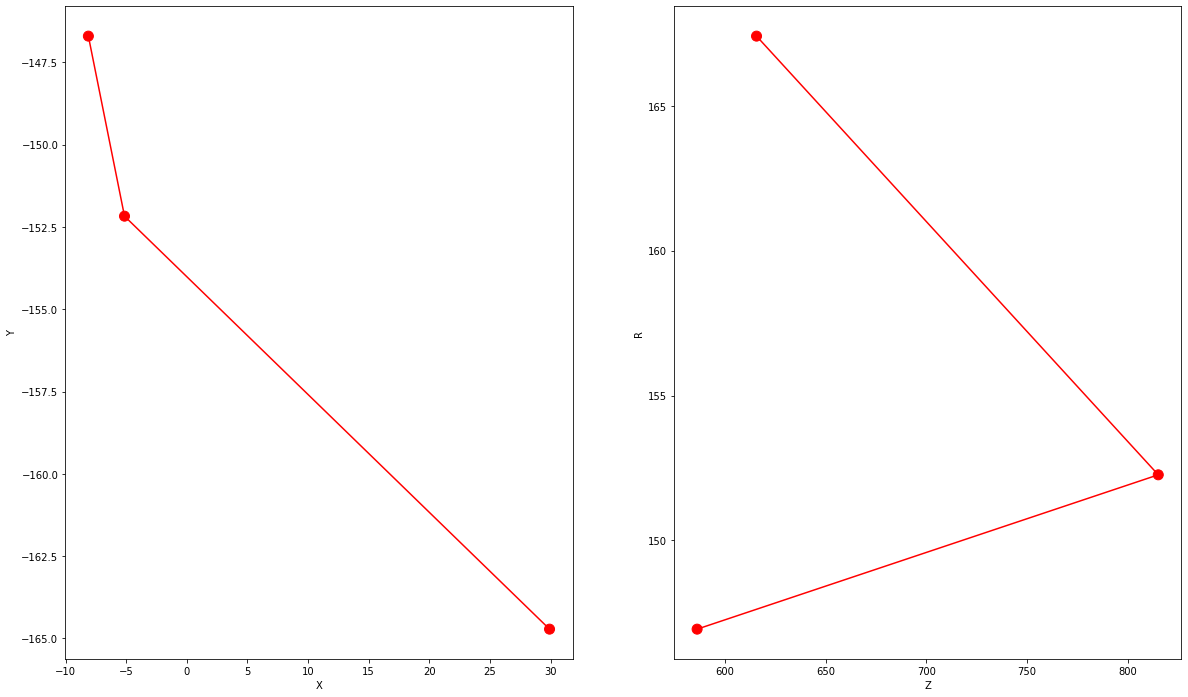

Event= 11    Sector= 11
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        6.0  ...  615.656616      8.0     0.0

[1 rows x 8 columns]
Event= 12    Sector= 1
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0        11      2.0        5.0  ... -1061.295044    -99.0     0.0

[1 rows x 8 columns]
Event= 12    Sector= 2
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        3.0  ... -615.757202    -29.0     0.0

[1 rows x 8 columns]
Event= 12    Sector= 3
df_hits = 
   vh_layer  vh_type  vh_sector  ...     vh_sim_z  vh_bend  isMuon
0         2      1.0        4.0  ...  -586.340759    -22.0     0.0
1         9      2.0        4.0  ...  -975.200012    -99.0     0.0
2        11      2.0        4.0  ... -1061.295044    -99.0     0.0

[3 rows x 8 columns]
Event= 12    Sector= 3


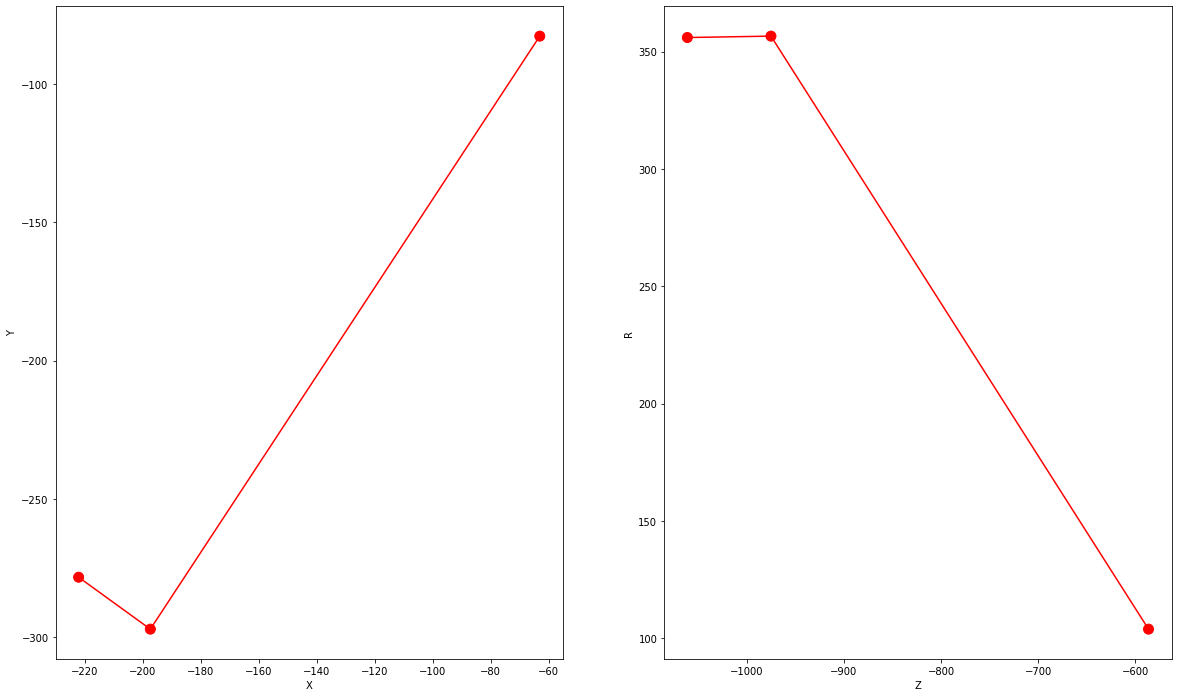

Event= 12    Sector= 4
df_hits = 
   vh_layer  vh_type  vh_sector  ...    vh_sim_z  vh_bend  isMuon
0         2      1.0        5.0  ... -615.749634     30.0     0.0
1         2      1.0        5.0  ... -586.413635     31.0     0.0
2         2      1.0        5.0  ... -586.462830     16.0     0.0
3         2      1.0        5.0  ... -586.437134    -18.0     0.0
4         2      1.0        5.0  ... -615.705078     -7.0     0.0
5         7      1.0        5.0  ... -839.635925     16.0     0.0

[6 rows x 8 columns]
Event= 12    Sector= 4


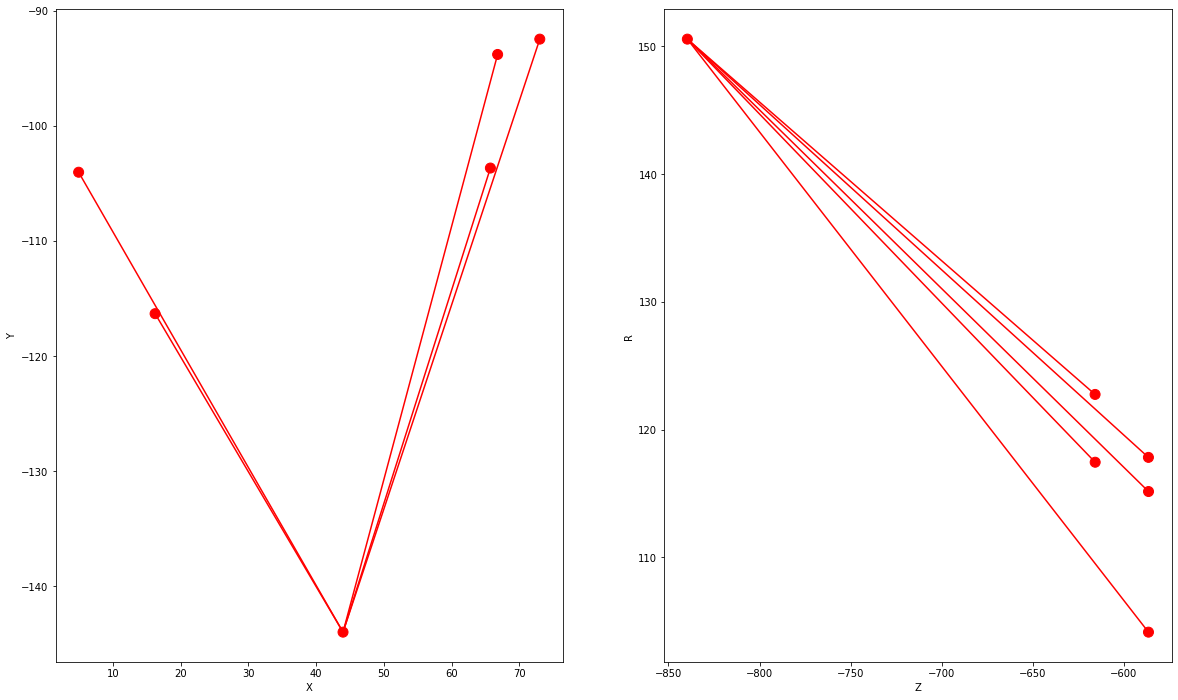

In [ ]:
# Initialize the random number generator
print('Initializing random seed=1')
random.seed(1)

# Read all EVENTS into dataframes
df_events_mu , df_events_pu = readEvents()

# Get number of events in dataframes
nmu = len(df_events_mu)
npu = len(df_events_pu)

# Loop over muon events mu 
all_segments=[] # collection of all segments
n_graphs=0
nmax=1000
for imu, event_mu in df_events_mu.iterrows():

  if imu > nmax : 
    print('Reached NMAX=',nmax)
    break

  # Pick a random pu event 
  ipu = random.randint(0,npu-1)
  event_pu = df_events_pu.iloc[ipu] 

  # Get HITS dataframe from merged muon and pileup events
  df_hits = getHits(event_mu, event_pu)
 
  # Create a list of HITS dataframe by detector Eta sign  and Phi sector
  hits_sectors = splitHits(df_hits)

  # Loop over list of HITS per sector
  for isec, df_hits_sec in enumerate(hits_sectors, start=1): 
      
    print("Event=",imu,"   Sector=",isec)
    # Build SEGMENTS ( returns modified df_hits_sec and df_segments )
    df_segments = buildSegments(df_hits_sec)

    # Skip empty segments
    if ( len(df_segments)==0 ):
#      print("Skipping empty segments",isec)
      continue 

    # Save segments in a list
    all_segments.append(df_segments) 

    # Build GRAPH
    graph = buildGraph(df_hits_sec,df_segments)

    # Convert GRAPH to a dictionary to save as NPZ
#    gdic = dict(X=graph.X, Ri=graph.Ri, Ro=graph.Ro, y=graph.y)
    gdic = dict(X=graph.X, Ri=graph.Ri, Ro=graph.Ro, y_hits=graph.y_hits, y_segs=graph.y_segs)
    
    # Save GRAPH dictionary to a NPZ file
    n_graphs+=1
    outfile = data_dir+'/graphs/graph_'+str(n_graphs)+'.npz' 
    np.savez(outfile,**gdic)

    # Visualize the graphs
    print("Event=",imu,"   Sector=",isec)
    labels = (df_hits_sec['isMuon'].values).astype(np.float32) # hits labels for plotting purposes 
    drawGraph(graph,labels)

    # Convert to SPARSE GRAPHS and save to NPZ file
#    sparse_graph = graph_to_sparse(graph) 
#    outfile = data_dir+'/graphs/sgraph_'+str(imu)+'.npz' 
#    np.savez(outfile,**sparse_graph)

    # End loop over hits per sector
  # End loop over events

# Plot SEGMENTS distribution
#plotSegments(all_segments)

